<a href="https://colab.research.google.com/github/Zhengwen-Lan/lung_predicate/blob/master/%E4%BD%BF%E7%94%A8%E7%AE%80%E5%8D%95%E7%BA%BF%E6%80%A7%E6%A8%A1%E5%9E%8B%E5%B0%9D%E8%AF%95%E6%8B%9F%E5%90%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 1: COVID-19 Cases Prediction (Regression)**

Objectives:
* Solve a regression problem with deep neural networks (DNN).
* Understand basic DNN training tips.
* Familiarize yourself with PyTorch.

If you have any questions, please contact the TAs via TA hours, NTU COOL, or email to mlta-2022-spring@googlegroups.com

# Download data
If the Google Drive links below do not work, you can download data from [Kaggle](https://www.kaggle.com/c/ml2022spring-hw1/data), and upload data manually to the workspace.

!gdown --id '1kLSW_-cW2Huj7bh84YTdimGBOJaODiOS' --output covid.train.csv
!gdown --id '1iiI5qROrAhZn-o4FPqsE97bMzDEFvIdg' --output covid.test.csv

In [1]:
!gdown --id '1kLSW_-cW2Huj7bh84YTdimGBOJaODiOS' --output covid.train.csv
!gdown --id '1iiI5qROrAhZn-o4FPqsE97bMzDEFvIdg' --output covid.test.csv

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1kLSW_-cW2Huj7bh84YTdimGBOJaODiOS
To: /content/covid.train.csv
100% 2.49M/2.49M [00:00<00:00, 242MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1iiI5qROrAhZn-o4FPqsE97bMzDEFvIdg
To: /content/covid.test.csv
100% 993k/993k [00:00<00:00, 113MB/s]


# Import packages

In [2]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# Some Utility Functions

You do not need to modify this part.

In [21]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size],
                                        generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    true = []
    for x,y in tqdm(test_loader):
        x = x.to(device)
        y = y.to(device)                        
        with torch.no_grad():                   
            pred = model(x)
            true.append(y.detach().cpu())                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()
    true = torch.cat(true, dim=0).numpy()  
    return preds,true

# Dataset

In [4]:
class COVID19Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)


    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

# Neural Network Model
Try out different model architectures by modifying the class below.

In [5]:
class My_Model(nn.Module):
    def __init__(self, input_dim):
        super(My_Model, self).__init__()
        # TODO: modify model's structure, be aware of dimensions. 
        #input_dim is the num of features we selected
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(0.2),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            
            nn.Linear(64, 16),
            nn.LeakyReLU(0.2),
            #nn.BatchNorm1d(10),
            nn.Dropout(0.1),
            
            nn.Linear(16, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

# Feature Selection
Choose features you deem useful by modifying the function below.

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

features = pd.read_csv('/content/train_unit3.csv')
x_data, y_data = features.iloc[:, 0:-2], features.iloc[:, -2]

#try choose your k best features
k = 24
selector = SelectKBest(score_func=f_regression, k=k)
result = selector.fit(x_data, y_data)

#result.scores_ inclues scores for each features
#np.argsort sort scores in ascending order by index, we reverse it to make it descending.
idx = np.argsort(result.scores_)[::-1]
print(f'Top {k} Best feature score ')
print(result.scores_[idx[:k]])

print(f'\nTop {k} Best feature index ')
print(idx[:k])

print(f'\nTop {k} Best feature name')
print(x_data.columns[idx[:k]])

selected_idx = list(np.sort(idx[:k]))
print(selected_idx)
print(x_data.columns[selected_idx])

Top 24 Best feature score 
[12.54039316  9.18562733  8.74134264  8.20898027  7.04282     5.89698183
  5.10828974  4.41529349  3.93214189  3.76961107  3.55097504  3.05184337
  2.89367774  2.84456261  2.43850815  2.37889465  2.33181354  2.16927202
  1.57379768  1.55879125  1.55829913  1.50623183  1.4923475   1.46844444]

Top 24 Best feature index 
[23  1 46  0 13  8 28 24  4  9 30 45 27 10 18 43 44  5 22 16 42 26 25 41]

Top 24 Best feature name
Index(['cardiothoracic_ratio', 'init_volume_sum_per',
       'degreeOfBoneHyperplasia', 'init_volume_sum', 'is_pleuralEffusion',
       'degreeOfAlveolarConsolidation', 'AbdominalShortDiameterOfTheSameLayer',
       'mainPulmonaryArtery', 'final_volume_sum_per', 'is_fibrotic_lesions',
       'SpleenThicknessAndDiameter', 'T12_BMD',
       'inferiorVenaCavaShortDiameter', 'is_noduleMass',
       'LeftThyroidLobeDensity', 'T10_BMD', 'T11_BMD', 'final_avg_volume',
       'Carotid_calcification', 'RightThyroidLobeDensity', 'T9_BMD', 'rate1',
       '

In [7]:
def select_feat(train_data, valid_data, test_data, select_all=True):
    '''Selects useful features to perform regression'''
    y_train, y_valid = train_data[:,-1], valid_data[:,-1]
    raw_x_train, raw_x_valid, raw_x_test = train_data[:,:-2], valid_data[:,:-2], test_data[:,:-2]

    if select_all:
        feat_idx = list(range(raw_x_train.shape[1]))
    else:
        feat_idx = selected_idx
        # TODO: Select suitable feature columns.
        
    return raw_x_train[:,feat_idx], raw_x_valid[:,feat_idx], raw_x_test[:,feat_idx], y_train, y_valid

# Training Loop

In [8]:
def trainer(train_loader, valid_loader, model, config, device):

    criterion = nn.MSELoss(reduction='mean') # Define your loss function, do not modify this.

    # Define your optimization algorithm. 
    # TODO: Please check https://pytorch.org/docs/stable/optim.html to get more available algorithms.
    # TODO: L2 regularization (optimizer(weight decay...) or implement by your self).
    #optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9) 
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate']*50,
                                 weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                        T_0=2, T_mult=2, eta_min=config['learning_rate'])

    if not os.path.isdir('./models'):
        os.mkdir('./models') # Create directory of saving models.

    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0
    
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)             
            loss = criterion(pred, y)
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})
            
        scheduler.step() 

        mean_train_loss = sum(loss_record)/len(loss_record)
        train_losses.append(mean_train_loss)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)

            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        val_losses.append(mean_valid_loss)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            break
    return train_losses, val_losses

# Configurations
`config` contains hyper-parameters for training and the path to save your model.

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
config = {
    'seed': 5201314,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 5000,     # Number of epochs.            
    'batch_size': 256, 
    'learning_rate': 1e-5,              
    'early_stop': 500,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': './models/model.ckpt'  # Your model will be saved here.
}

# Dataloader
Read data from files and set up training, validation, and testing sets. You do not need to modify this part.

In [10]:
# Set seed for reproducibility
same_seed(config['seed'])


# train_data size: 2699 x 118 (id + 37 states + 16 features x 5 days) 
# test_data size: 1078 x 117 (without last day's positive rate)
train_data, test_data = pd.read_csv('/content/train_unit3.csv').values, pd.read_csv('/content/test_unit3.csv').values
train_data, valid_data = train_valid_split(train_data, config['valid_ratio'], config['seed'])

# Print out the data size.
print(f"""train_data size: {train_data.shape} 
valid_data size: {valid_data.shape} 
test_data size: {test_data.shape}""")

# Select features
x_train, x_valid, x_test, y_train, y_valid = select_feat(train_data, valid_data, test_data, False)


#normalization
x_min, x_max = x_train.min(axis=0), x_train.max(axis=0)
x_train = (x_train - x_min) / (x_max - x_min)
x_valid = (x_valid - x_min) / (x_max - x_min)
x_test = (x_test - x_min) / (x_max - x_min)

print(f"""train_data size: {x_train.shape} 
valid_data size: {x_valid.shape} 
test_data size: {x_test.shape}""")
# Print out the number of features.
print(f'number of features: {x_train.shape[1]}')

train_dataset, valid_dataset, test_dataset = COVID19Dataset(x_train, y_train), \
                                            COVID19Dataset(x_valid, y_valid), \
                                            COVID19Dataset(x_test)

# Pytorch data loader loads pytorch dataset into batches.
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

train_data size: (335, 52) 
valid_data size: (83, 52) 
test_data size: (36, 52)
train_data size: (335, 24) 
valid_data size: (83, 24) 
test_data size: (36, 24)
number of features: 24


# Start training!

In [11]:
model = My_Model(input_dim=x_train.shape[1]).to(device) 
#put your model and data on the same computation device.
train_losses, val_losses = trainer(train_loader, valid_loader, model, config, device)

Epoch [1/5000]: 100%|██████████| 2/2 [00:03<00:00,  1.80s/it, loss=80.3]


Epoch [1/5000]: Train loss: 83.8752, Valid loss: 86.3361
Saving model with loss 86.336...


Epoch [2/5000]: 100%|██████████| 2/2 [00:00<00:00, 66.33it/s, loss=82.4]


Epoch [2/5000]: Train loss: 84.3927, Valid loss: 86.2683
Saving model with loss 86.268...


Epoch [3/5000]: 100%|██████████| 2/2 [00:00<00:00, 49.30it/s, loss=89.4]


Epoch [3/5000]: Train loss: 86.5691, Valid loss: 86.1205
Saving model with loss 86.120...


Epoch [4/5000]: 100%|██████████| 2/2 [00:00<00:00, 57.36it/s, loss=84]


Epoch [4/5000]: Train loss: 84.5847, Valid loss: 86.0090
Saving model with loss 86.009...


Epoch [5/5000]: 100%|██████████| 2/2 [00:00<00:00, 62.77it/s, loss=77.6]


Epoch [5/5000]: Train loss: 82.0677, Valid loss: 85.9682
Saving model with loss 85.968...


Epoch [6/5000]: 100%|██████████| 2/2 [00:00<00:00, 15.45it/s, loss=77.9]


Epoch [6/5000]: Train loss: 82.0078, Valid loss: 85.9897


Epoch [7/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.64it/s, loss=75.8]


Epoch [7/5000]: Train loss: 81.2792, Valid loss: 85.8424
Saving model with loss 85.842...


Epoch [8/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.85it/s, loss=84.7]


Epoch [8/5000]: Train loss: 84.2624, Valid loss: 85.6941
Saving model with loss 85.694...


Epoch [9/5000]: 100%|██████████| 2/2 [00:00<00:00, 67.65it/s, loss=88.4]


Epoch [9/5000]: Train loss: 85.2970, Valid loss: 85.5879
Saving model with loss 85.588...


Epoch [10/5000]: 100%|██████████| 2/2 [00:00<00:00, 122.94it/s, loss=79.9]


Epoch [10/5000]: Train loss: 82.3180, Valid loss: 85.4940
Saving model with loss 85.494...


Epoch [11/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.95it/s, loss=82.3]


Epoch [11/5000]: Train loss: 82.8116, Valid loss: 85.4333
Saving model with loss 85.433...


Epoch [12/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.08it/s, loss=78.7]


Epoch [12/5000]: Train loss: 81.5960, Valid loss: 85.3961
Saving model with loss 85.396...


Epoch [13/5000]: 100%|██████████| 2/2 [00:00<00:00, 117.86it/s, loss=86.5]


Epoch [13/5000]: Train loss: 84.1393, Valid loss: 85.3955
Saving model with loss 85.396...


Epoch [14/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.37it/s, loss=78.5]


Epoch [14/5000]: Train loss: 81.4050, Valid loss: 85.4087


Epoch [15/5000]: 100%|██████████| 2/2 [00:00<00:00, 65.85it/s, loss=78.4]


Epoch [15/5000]: Train loss: 81.3661, Valid loss: 85.1871
Saving model with loss 85.187...


Epoch [16/5000]: 100%|██████████| 2/2 [00:00<00:00, 50.69it/s, loss=85.8]


Epoch [16/5000]: Train loss: 83.6328, Valid loss: 84.9540
Saving model with loss 84.954...


Epoch [17/5000]: 100%|██████████| 2/2 [00:00<00:00, 53.06it/s, loss=89.8]


Epoch [17/5000]: Train loss: 84.8488, Valid loss: 84.7186
Saving model with loss 84.719...


Epoch [18/5000]: 100%|██████████| 2/2 [00:00<00:00, 41.43it/s, loss=83.1]


Epoch [18/5000]: Train loss: 82.5520, Valid loss: 84.5001
Saving model with loss 84.500...


Epoch [19/5000]: 100%|██████████| 2/2 [00:00<00:00, 66.37it/s, loss=77.1]


Epoch [19/5000]: Train loss: 80.0902, Valid loss: 84.2097
Saving model with loss 84.210...


Epoch [20/5000]: 100%|██████████| 2/2 [00:00<00:00, 63.62it/s, loss=72.3]


Epoch [20/5000]: Train loss: 78.3359, Valid loss: 83.9612
Saving model with loss 83.961...


Epoch [21/5000]: 100%|██████████| 2/2 [00:00<00:00, 64.53it/s, loss=74.8]


Epoch [21/5000]: Train loss: 79.0906, Valid loss: 83.7550
Saving model with loss 83.755...


Epoch [22/5000]: 100%|██████████| 2/2 [00:00<00:00, 59.13it/s, loss=78.6]


Epoch [22/5000]: Train loss: 80.2580, Valid loss: 83.5587
Saving model with loss 83.559...


Epoch [23/5000]: 100%|██████████| 2/2 [00:00<00:00, 44.23it/s, loss=75.1]


Epoch [23/5000]: Train loss: 78.9903, Valid loss: 83.3854
Saving model with loss 83.385...


Epoch [24/5000]: 100%|██████████| 2/2 [00:00<00:00, 75.84it/s, loss=89.5]


Epoch [24/5000]: Train loss: 83.8824, Valid loss: 83.2345
Saving model with loss 83.234...


Epoch [25/5000]: 100%|██████████| 2/2 [00:00<00:00, 48.00it/s, loss=78.1]


Epoch [25/5000]: Train loss: 79.7773, Valid loss: 83.1068
Saving model with loss 83.107...


Epoch [26/5000]: 100%|██████████| 2/2 [00:00<00:00, 67.79it/s, loss=82.7]


Epoch [26/5000]: Train loss: 81.4095, Valid loss: 83.0504
Saving model with loss 83.050...


Epoch [27/5000]: 100%|██████████| 2/2 [00:00<00:00, 47.36it/s, loss=80]


Epoch [27/5000]: Train loss: 80.2913, Valid loss: 82.9880
Saving model with loss 82.988...


Epoch [28/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.13it/s, loss=73.4]


Epoch [28/5000]: Train loss: 77.8736, Valid loss: 82.9794
Saving model with loss 82.979...


Epoch [29/5000]: 100%|██████████| 2/2 [00:00<00:00, 56.11it/s, loss=82.1]


Epoch [29/5000]: Train loss: 81.0321, Valid loss: 82.9567
Saving model with loss 82.957...


Epoch [30/5000]: 100%|██████████| 2/2 [00:00<00:00, 51.82it/s, loss=83]


Epoch [30/5000]: Train loss: 81.2755, Valid loss: 82.9589


Epoch [31/5000]: 100%|██████████| 2/2 [00:00<00:00, 74.02it/s, loss=74.6]


Epoch [31/5000]: Train loss: 78.3407, Valid loss: 82.5172
Saving model with loss 82.517...


Epoch [32/5000]: 100%|██████████| 2/2 [00:00<00:00, 63.04it/s, loss=81.6]


Epoch [32/5000]: Train loss: 80.5745, Valid loss: 82.0722
Saving model with loss 82.072...


Epoch [33/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.85it/s, loss=82]


Epoch [33/5000]: Train loss: 80.4414, Valid loss: 81.7243
Saving model with loss 81.724...


Epoch [34/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.73it/s, loss=80.4]


Epoch [34/5000]: Train loss: 79.5260, Valid loss: 81.3356
Saving model with loss 81.336...


Epoch [35/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.10it/s, loss=81.7]


Epoch [35/5000]: Train loss: 79.8573, Valid loss: 80.9000
Saving model with loss 80.900...


Epoch [36/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.39it/s, loss=76.4]


Epoch [36/5000]: Train loss: 77.9841, Valid loss: 80.5693
Saving model with loss 80.569...


Epoch [37/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.47it/s, loss=65.4]


Epoch [37/5000]: Train loss: 73.9095, Valid loss: 80.1600
Saving model with loss 80.160...


Epoch [38/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.54it/s, loss=78.6]


Epoch [38/5000]: Train loss: 78.4367, Valid loss: 79.8122
Saving model with loss 79.812...


Epoch [39/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.87it/s, loss=78.4]


Epoch [39/5000]: Train loss: 78.0423, Valid loss: 79.5422
Saving model with loss 79.542...


Epoch [40/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.93it/s, loss=71]


Epoch [40/5000]: Train loss: 75.3758, Valid loss: 79.2094
Saving model with loss 79.209...


Epoch [41/5000]: 100%|██████████| 2/2 [00:00<00:00, 70.37it/s, loss=77]


Epoch [41/5000]: Train loss: 77.1500, Valid loss: 78.9431
Saving model with loss 78.943...


Epoch [42/5000]: 100%|██████████| 2/2 [00:00<00:00, 68.14it/s, loss=73.8]


Epoch [42/5000]: Train loss: 76.1802, Valid loss: 78.7481
Saving model with loss 78.748...


Epoch [43/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.36it/s, loss=83.2]


Epoch [43/5000]: Train loss: 78.9955, Valid loss: 78.5527
Saving model with loss 78.553...


Epoch [44/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.24it/s, loss=77.1]


Epoch [44/5000]: Train loss: 76.6428, Valid loss: 78.3294
Saving model with loss 78.329...


Epoch [45/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.28it/s, loss=77.1]


Epoch [45/5000]: Train loss: 76.7469, Valid loss: 78.2122
Saving model with loss 78.212...


Epoch [46/5000]: 100%|██████████| 2/2 [00:00<00:00, 118.70it/s, loss=69.9]


Epoch [46/5000]: Train loss: 74.1147, Valid loss: 78.1136
Saving model with loss 78.114...


Epoch [47/5000]: 100%|██████████| 2/2 [00:00<00:00, 68.23it/s, loss=83.7]


Epoch [47/5000]: Train loss: 78.6013, Valid loss: 77.9499
Saving model with loss 77.950...


Epoch [48/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.91it/s, loss=78.7]


Epoch [48/5000]: Train loss: 76.4616, Valid loss: 77.7988
Saving model with loss 77.799...


Epoch [49/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.30it/s, loss=78.2]


Epoch [49/5000]: Train loss: 76.6704, Valid loss: 77.6807
Saving model with loss 77.681...


Epoch [50/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.73it/s, loss=82.4]


Epoch [50/5000]: Train loss: 77.6379, Valid loss: 77.6084
Saving model with loss 77.608...


Epoch [51/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.60it/s, loss=66]


Epoch [51/5000]: Train loss: 72.2201, Valid loss: 77.4790
Saving model with loss 77.479...


Epoch [52/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.97it/s, loss=68.2]


Epoch [52/5000]: Train loss: 72.9273, Valid loss: 77.5040


Epoch [53/5000]: 100%|██████████| 2/2 [00:00<00:00, 76.15it/s, loss=81.3]


Epoch [53/5000]: Train loss: 77.2905, Valid loss: 77.4605
Saving model with loss 77.460...


Epoch [54/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.33it/s, loss=68.4]


Epoch [54/5000]: Train loss: 72.7195, Valid loss: 77.4550
Saving model with loss 77.455...


Epoch [55/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.89it/s, loss=71.3]


Epoch [55/5000]: Train loss: 73.6936, Valid loss: 77.3679
Saving model with loss 77.368...


Epoch [56/5000]: 100%|██████████| 2/2 [00:00<00:00, 65.85it/s, loss=67.1]


Epoch [56/5000]: Train loss: 72.1882, Valid loss: 77.3558
Saving model with loss 77.356...


Epoch [57/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.67it/s, loss=77.6]


Epoch [57/5000]: Train loss: 75.5713, Valid loss: 77.3325
Saving model with loss 77.332...


Epoch [58/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.71it/s, loss=69.6]


Epoch [58/5000]: Train loss: 73.0239, Valid loss: 77.3217
Saving model with loss 77.322...


Epoch [59/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.70it/s, loss=70.8]


Epoch [59/5000]: Train loss: 73.3807, Valid loss: 77.2574
Saving model with loss 77.257...


Epoch [60/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.37it/s, loss=72.1]


Epoch [60/5000]: Train loss: 73.6770, Valid loss: 77.2723


Epoch [61/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.27it/s, loss=80]


Epoch [61/5000]: Train loss: 76.3505, Valid loss: 77.3238


Epoch [62/5000]: 100%|██████████| 2/2 [00:00<00:00, 114.78it/s, loss=71.7]


Epoch [62/5000]: Train loss: 73.7942, Valid loss: 77.4324


Epoch [63/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.13it/s, loss=84.5]


Epoch [63/5000]: Train loss: 77.7321, Valid loss: 77.0742
Saving model with loss 77.074...


Epoch [64/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.00it/s, loss=74.1]


Epoch [64/5000]: Train loss: 74.2063, Valid loss: 76.6667
Saving model with loss 76.667...


Epoch [65/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.56it/s, loss=78.3]


Epoch [65/5000]: Train loss: 75.5291, Valid loss: 76.2525
Saving model with loss 76.252...


Epoch [66/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.12it/s, loss=66.3]


Epoch [66/5000]: Train loss: 70.9569, Valid loss: 75.8334
Saving model with loss 75.833...


Epoch [67/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.31it/s, loss=71]


Epoch [67/5000]: Train loss: 72.2696, Valid loss: 75.4609
Saving model with loss 75.461...


Epoch [68/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.65it/s, loss=80]


Epoch [68/5000]: Train loss: 74.8947, Valid loss: 75.0432
Saving model with loss 75.043...


Epoch [69/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.92it/s, loss=74.5]


Epoch [69/5000]: Train loss: 72.8802, Valid loss: 74.7298
Saving model with loss 74.730...


Epoch [70/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.37it/s, loss=74]


Epoch [70/5000]: Train loss: 72.6346, Valid loss: 74.2423
Saving model with loss 74.242...


Epoch [71/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.83it/s, loss=63.5]


Epoch [71/5000]: Train loss: 68.5709, Valid loss: 73.8208
Saving model with loss 73.821...


Epoch [72/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.18it/s, loss=78.7]


Epoch [72/5000]: Train loss: 73.5317, Valid loss: 73.3267
Saving model with loss 73.327...


Epoch [73/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.86it/s, loss=65.5]


Epoch [73/5000]: Train loss: 68.6799, Valid loss: 72.8978
Saving model with loss 72.898...


Epoch [74/5000]: 100%|██████████| 2/2 [00:00<00:00, 114.56it/s, loss=71.2]


Epoch [74/5000]: Train loss: 70.3782, Valid loss: 72.4697
Saving model with loss 72.470...


Epoch [75/5000]: 100%|██████████| 2/2 [00:00<00:00, 112.75it/s, loss=78.2]


Epoch [75/5000]: Train loss: 72.1808, Valid loss: 72.0933
Saving model with loss 72.093...


Epoch [76/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.02it/s, loss=71.9]


Epoch [76/5000]: Train loss: 69.8738, Valid loss: 71.6605
Saving model with loss 71.660...


Epoch [77/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.41it/s, loss=58.7]


Epoch [77/5000]: Train loss: 65.0536, Valid loss: 71.2312
Saving model with loss 71.231...


Epoch [78/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.19it/s, loss=67.5]


Epoch [78/5000]: Train loss: 68.2736, Valid loss: 70.7514
Saving model with loss 70.751...


Epoch [79/5000]: 100%|██████████| 2/2 [00:00<00:00, 21.26it/s, loss=65.4]


Epoch [79/5000]: Train loss: 67.1371, Valid loss: 70.2358
Saving model with loss 70.236...


Epoch [80/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.88it/s, loss=64.5]


Epoch [80/5000]: Train loss: 66.5339, Valid loss: 69.8096
Saving model with loss 69.810...


Epoch [81/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.30it/s, loss=70.1]


Epoch [81/5000]: Train loss: 67.9925, Valid loss: 69.3706
Saving model with loss 69.371...


Epoch [82/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.17it/s, loss=65.6]


Epoch [82/5000]: Train loss: 66.3747, Valid loss: 69.0801
Saving model with loss 69.080...


Epoch [83/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.25it/s, loss=66.6]


Epoch [83/5000]: Train loss: 65.9740, Valid loss: 68.5233
Saving model with loss 68.523...


Epoch [84/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.35it/s, loss=65.5]


Epoch [84/5000]: Train loss: 65.6283, Valid loss: 68.1370
Saving model with loss 68.137...


Epoch [85/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.23it/s, loss=57.9]


Epoch [85/5000]: Train loss: 62.6055, Valid loss: 67.8212
Saving model with loss 67.821...


Epoch [86/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.36it/s, loss=57.5]


Epoch [86/5000]: Train loss: 62.0959, Valid loss: 67.5824
Saving model with loss 67.582...


Epoch [87/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.28it/s, loss=69.7]


Epoch [87/5000]: Train loss: 65.8819, Valid loss: 67.2154
Saving model with loss 67.215...


Epoch [88/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.60it/s, loss=65.3]


Epoch [88/5000]: Train loss: 64.2271, Valid loss: 66.9168
Saving model with loss 66.917...


Epoch [89/5000]: 100%|██████████| 2/2 [00:00<00:00, 68.65it/s, loss=61.1]


Epoch [89/5000]: Train loss: 62.4646, Valid loss: 66.4535
Saving model with loss 66.454...


Epoch [90/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.29it/s, loss=62.7]


Epoch [90/5000]: Train loss: 62.4180, Valid loss: 66.0906
Saving model with loss 66.091...


Epoch [91/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.92it/s, loss=70.5]


Epoch [91/5000]: Train loss: 65.0481, Valid loss: 65.8579
Saving model with loss 65.858...


Epoch [92/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.59it/s, loss=56.8]


Epoch [92/5000]: Train loss: 60.5480, Valid loss: 65.5104
Saving model with loss 65.510...


Epoch [93/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.26it/s, loss=65.8]


Epoch [93/5000]: Train loss: 63.2528, Valid loss: 65.1747
Saving model with loss 65.175...


Epoch [94/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.35it/s, loss=56.5]


Epoch [94/5000]: Train loss: 59.5413, Valid loss: 64.8905
Saving model with loss 64.891...


Epoch [95/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.95it/s, loss=66]


Epoch [95/5000]: Train loss: 62.8367, Valid loss: 64.5252
Saving model with loss 64.525...


Epoch [96/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.00it/s, loss=59.7]


Epoch [96/5000]: Train loss: 60.0886, Valid loss: 64.2146
Saving model with loss 64.215...


Epoch [97/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.75it/s, loss=65.7]


Epoch [97/5000]: Train loss: 62.2498, Valid loss: 63.9275
Saving model with loss 63.927...


Epoch [98/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.76it/s, loss=55.7]


Epoch [98/5000]: Train loss: 58.6718, Valid loss: 63.6357
Saving model with loss 63.636...


Epoch [99/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.14it/s, loss=55.5]


Epoch [99/5000]: Train loss: 58.1972, Valid loss: 63.2829
Saving model with loss 63.283...


Epoch [100/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.74it/s, loss=56.4]


Epoch [100/5000]: Train loss: 58.8971, Valid loss: 63.1640
Saving model with loss 63.164...


Epoch [101/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.87it/s, loss=66.1]


Epoch [101/5000]: Train loss: 61.6357, Valid loss: 62.7557
Saving model with loss 62.756...


Epoch [102/5000]: 100%|██████████| 2/2 [00:00<00:00, 80.61it/s, loss=49.7]


Epoch [102/5000]: Train loss: 56.1121, Valid loss: 62.5131
Saving model with loss 62.513...


Epoch [103/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.39it/s, loss=61.3]


Epoch [103/5000]: Train loss: 59.5515, Valid loss: 62.2736
Saving model with loss 62.274...


Epoch [104/5000]: 100%|██████████| 2/2 [00:00<00:00, 74.83it/s, loss=55.9]


Epoch [104/5000]: Train loss: 57.3121, Valid loss: 62.0220
Saving model with loss 62.022...


Epoch [105/5000]: 100%|██████████| 2/2 [00:00<00:00, 80.17it/s, loss=58.9]


Epoch [105/5000]: Train loss: 58.5879, Valid loss: 61.7168
Saving model with loss 61.717...


Epoch [106/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.20it/s, loss=55.3]


Epoch [106/5000]: Train loss: 57.1755, Valid loss: 61.5944
Saving model with loss 61.594...


Epoch [107/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.21it/s, loss=54.7]


Epoch [107/5000]: Train loss: 56.7711, Valid loss: 61.4134
Saving model with loss 61.413...


Epoch [108/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.43it/s, loss=54.4]


Epoch [108/5000]: Train loss: 56.7323, Valid loss: 61.2599
Saving model with loss 61.260...


Epoch [109/5000]: 100%|██████████| 2/2 [00:00<00:00, 80.89it/s, loss=56]


Epoch [109/5000]: Train loss: 57.2011, Valid loss: 61.1699
Saving model with loss 61.170...


Epoch [110/5000]: 100%|██████████| 2/2 [00:00<00:00, 80.55it/s, loss=58.4]


Epoch [110/5000]: Train loss: 57.7834, Valid loss: 61.1769


Epoch [111/5000]: 100%|██████████| 2/2 [00:00<00:00, 77.32it/s, loss=59.2]


Epoch [111/5000]: Train loss: 57.9133, Valid loss: 61.1233
Saving model with loss 61.123...


Epoch [112/5000]: 100%|██████████| 2/2 [00:00<00:00, 78.74it/s, loss=62.9]


Epoch [112/5000]: Train loss: 59.3764, Valid loss: 60.8235
Saving model with loss 60.823...


Epoch [113/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.01it/s, loss=54.2]


Epoch [113/5000]: Train loss: 56.2354, Valid loss: 60.5596
Saving model with loss 60.560...


Epoch [114/5000]: 100%|██████████| 2/2 [00:00<00:00, 71.54it/s, loss=62.1]


Epoch [114/5000]: Train loss: 58.7296, Valid loss: 60.4339
Saving model with loss 60.434...


Epoch [115/5000]: 100%|██████████| 2/2 [00:00<00:00, 75.00it/s, loss=56.7]


Epoch [115/5000]: Train loss: 56.3330, Valid loss: 60.4687


Epoch [116/5000]: 100%|██████████| 2/2 [00:00<00:00, 57.58it/s, loss=57.8]


Epoch [116/5000]: Train loss: 57.0520, Valid loss: 60.3101
Saving model with loss 60.310...


Epoch [117/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.84it/s, loss=53.2]


Epoch [117/5000]: Train loss: 55.8425, Valid loss: 60.1802
Saving model with loss 60.180...


Epoch [118/5000]: 100%|██████████| 2/2 [00:00<00:00, 114.15it/s, loss=49.6]


Epoch [118/5000]: Train loss: 54.3086, Valid loss: 60.1017
Saving model with loss 60.102...


Epoch [119/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.43it/s, loss=58.8]


Epoch [119/5000]: Train loss: 57.3212, Valid loss: 60.1311


Epoch [120/5000]: 100%|██████████| 2/2 [00:00<00:00, 74.06it/s, loss=54.9]


Epoch [120/5000]: Train loss: 55.9110, Valid loss: 60.0114
Saving model with loss 60.011...


Epoch [121/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.43it/s, loss=57.8]


Epoch [121/5000]: Train loss: 57.3231, Valid loss: 60.1492


Epoch [122/5000]: 100%|██████████| 2/2 [00:00<00:00, 72.51it/s, loss=62.5]


Epoch [122/5000]: Train loss: 58.4621, Valid loss: 60.1317


Epoch [123/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.60it/s, loss=56]


Epoch [123/5000]: Train loss: 56.0454, Valid loss: 60.0265


Epoch [124/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.49it/s, loss=61.7]


Epoch [124/5000]: Train loss: 58.4485, Valid loss: 60.0660


Epoch [125/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.61it/s, loss=58.6]


Epoch [125/5000]: Train loss: 56.9146, Valid loss: 60.1191


Epoch [126/5000]: 100%|██████████| 2/2 [00:00<00:00, 66.27it/s, loss=51.1]


Epoch [126/5000]: Train loss: 54.7881, Valid loss: 60.0822


Epoch [127/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.12it/s, loss=65.8]


Epoch [127/5000]: Train loss: 59.8398, Valid loss: 59.6964
Saving model with loss 59.696...


Epoch [128/5000]: 100%|██████████| 2/2 [00:00<00:00, 67.46it/s, loss=63.7]


Epoch [128/5000]: Train loss: 58.8046, Valid loss: 59.1513
Saving model with loss 59.151...


Epoch [129/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.09it/s, loss=53.2]


Epoch [129/5000]: Train loss: 54.5745, Valid loss: 58.6254
Saving model with loss 58.625...


Epoch [130/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.54it/s, loss=52.2]

Epoch [130/5000]: Train loss: 53.6395, Valid loss: 58.1236


Saving model with loss 58.124...


Epoch [131/5000]: 100%|██████████| 2/2 [00:00<00:00, 61.71it/s, loss=58.1]


Epoch [131/5000]: Train loss: 55.2240, Valid loss: 57.5746
Saving model with loss 57.575...


Epoch [132/5000]: 100%|██████████| 2/2 [00:00<00:00, 78.64it/s, loss=42.3]


Epoch [132/5000]: Train loss: 49.7362, Valid loss: 56.8300
Saving model with loss 56.830...


Epoch [133/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.35it/s, loss=44.4]


Epoch [133/5000]: Train loss: 50.3193, Valid loss: 56.1568
Saving model with loss 56.157...


Epoch [134/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.91it/s, loss=49]


Epoch [134/5000]: Train loss: 50.8210, Valid loss: 55.4243
Saving model with loss 55.424...


Epoch [135/5000]: 100%|██████████| 2/2 [00:00<00:00, 66.18it/s, loss=55.5]


Epoch [135/5000]: Train loss: 52.7159, Valid loss: 54.8681
Saving model with loss 54.868...


Epoch [136/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.57it/s, loss=51.5]


Epoch [136/5000]: Train loss: 50.9766, Valid loss: 54.3924
Saving model with loss 54.392...


Epoch [137/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.03it/s, loss=48.7]


Epoch [137/5000]: Train loss: 49.2863, Valid loss: 53.6321
Saving model with loss 53.632...


Epoch [138/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.33it/s, loss=45.7]


Epoch [138/5000]: Train loss: 48.0863, Valid loss: 53.1392
Saving model with loss 53.139...


Epoch [139/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.27it/s, loss=42.9]


Epoch [139/5000]: Train loss: 46.8227, Valid loss: 52.3921
Saving model with loss 52.392...


Epoch [140/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.29it/s, loss=45.9]


Epoch [140/5000]: Train loss: 47.1698, Valid loss: 51.6926
Saving model with loss 51.693...


Epoch [141/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.71it/s, loss=50.2]


Epoch [141/5000]: Train loss: 48.2852, Valid loss: 51.0612
Saving model with loss 51.061...


Epoch [142/5000]: 100%|██████████| 2/2 [00:00<00:00, 65.09it/s, loss=46.4]


Epoch [142/5000]: Train loss: 46.7580, Valid loss: 50.4002
Saving model with loss 50.400...


Epoch [143/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.43it/s, loss=44.6]


Epoch [143/5000]: Train loss: 45.5582, Valid loss: 50.0163
Saving model with loss 50.016...


Epoch [144/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.58it/s, loss=47.5]


Epoch [144/5000]: Train loss: 46.3248, Valid loss: 49.3924
Saving model with loss 49.392...


Epoch [145/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.89it/s, loss=46.2]


Epoch [145/5000]: Train loss: 45.6675, Valid loss: 48.6842
Saving model with loss 48.684...


Epoch [146/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.62it/s, loss=43.4]


Epoch [146/5000]: Train loss: 43.7253, Valid loss: 48.1052
Saving model with loss 48.105...


Epoch [147/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.13it/s, loss=47.3]


Epoch [147/5000]: Train loss: 44.3305, Valid loss: 47.4588
Saving model with loss 47.459...


Epoch [148/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.08it/s, loss=50.4]


Epoch [148/5000]: Train loss: 45.2620, Valid loss: 46.7972
Saving model with loss 46.797...


Epoch [149/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.57it/s, loss=48.9]


Epoch [149/5000]: Train loss: 44.3219, Valid loss: 46.0006
Saving model with loss 46.001...


Epoch [150/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.06it/s, loss=37.6]


Epoch [150/5000]: Train loss: 40.5753, Valid loss: 45.2133
Saving model with loss 45.213...


Epoch [151/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.65it/s, loss=41.5]


Epoch [151/5000]: Train loss: 41.3022, Valid loss: 44.4542
Saving model with loss 44.454...


Epoch [152/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.03it/s, loss=40.3]


Epoch [152/5000]: Train loss: 40.3686, Valid loss: 43.7890
Saving model with loss 43.789...


Epoch [153/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.85it/s, loss=37.7]


Epoch [153/5000]: Train loss: 38.4784, Valid loss: 43.0460
Saving model with loss 43.046...


Epoch [154/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.35it/s, loss=37.3]


Epoch [154/5000]: Train loss: 38.1124, Valid loss: 42.4628
Saving model with loss 42.463...


Epoch [155/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.61it/s, loss=38.8]


Epoch [155/5000]: Train loss: 38.5294, Valid loss: 41.6790
Saving model with loss 41.679...


Epoch [156/5000]: 100%|██████████| 2/2 [00:00<00:00, 73.46it/s, loss=40.8]


Epoch [156/5000]: Train loss: 38.7437, Valid loss: 40.9907
Saving model with loss 40.991...


Epoch [157/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.00it/s, loss=43.4]


Epoch [157/5000]: Train loss: 39.6550, Valid loss: 40.3336
Saving model with loss 40.334...


Epoch [158/5000]: 100%|██████████| 2/2 [00:00<00:00, 109.73it/s, loss=44.7]


Epoch [158/5000]: Train loss: 39.7862, Valid loss: 39.7431
Saving model with loss 39.743...


Epoch [159/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.80it/s, loss=34.9]


Epoch [159/5000]: Train loss: 36.0606, Valid loss: 39.4062
Saving model with loss 39.406...


Epoch [160/5000]: 100%|██████████| 2/2 [00:00<00:00, 77.02it/s, loss=36.1]


Epoch [160/5000]: Train loss: 35.4478, Valid loss: 38.7462
Saving model with loss 38.746...


Epoch [161/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.51it/s, loss=35.9]


Epoch [161/5000]: Train loss: 35.3251, Valid loss: 38.3530
Saving model with loss 38.353...


Epoch [162/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.35it/s, loss=34.8]


Epoch [162/5000]: Train loss: 35.0480, Valid loss: 37.8269
Saving model with loss 37.827...


Epoch [163/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.41it/s, loss=37.3]


Epoch [163/5000]: Train loss: 35.2805, Valid loss: 37.1557
Saving model with loss 37.156...


Epoch [164/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.37it/s, loss=28.4]


Epoch [164/5000]: Train loss: 32.6571, Valid loss: 36.4610
Saving model with loss 36.461...


Epoch [165/5000]: 100%|██████████| 2/2 [00:00<00:00, 62.97it/s, loss=33.1]


Epoch [165/5000]: Train loss: 32.6564, Valid loss: 35.9692
Saving model with loss 35.969...


Epoch [166/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.51it/s, loss=32.3]


Epoch [166/5000]: Train loss: 32.7511, Valid loss: 35.4566
Saving model with loss 35.457...


Epoch [167/5000]: 100%|██████████| 2/2 [00:00<00:00, 114.72it/s, loss=32.1]


Epoch [167/5000]: Train loss: 33.1021, Valid loss: 34.8871
Saving model with loss 34.887...


Epoch [168/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.77it/s, loss=28.6]


Epoch [168/5000]: Train loss: 31.1447, Valid loss: 34.2592
Saving model with loss 34.259...


Epoch [169/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.76it/s, loss=30.5]


Epoch [169/5000]: Train loss: 30.9725, Valid loss: 33.7156
Saving model with loss 33.716...


Epoch [170/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.07it/s, loss=28.9]


Epoch [170/5000]: Train loss: 30.8560, Valid loss: 33.1997
Saving model with loss 33.200...


Epoch [171/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.28it/s, loss=31.3]


Epoch [171/5000]: Train loss: 30.5956, Valid loss: 32.8458
Saving model with loss 32.846...


Epoch [172/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.14it/s, loss=30.4]


Epoch [172/5000]: Train loss: 30.8762, Valid loss: 32.5693
Saving model with loss 32.569...


Epoch [173/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.30it/s, loss=26.4]


Epoch [173/5000]: Train loss: 28.6146, Valid loss: 32.2575
Saving model with loss 32.258...


Epoch [174/5000]: 100%|██████████| 2/2 [00:00<00:00, 37.78it/s, loss=29.7]


Epoch [174/5000]: Train loss: 29.2757, Valid loss: 31.7401
Saving model with loss 31.740...


Epoch [175/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.32it/s, loss=25.9]


Epoch [175/5000]: Train loss: 28.2746, Valid loss: 31.2919
Saving model with loss 31.292...


Epoch [176/5000]: 100%|██████████| 2/2 [00:00<00:00, 80.11it/s, loss=23.3]


Epoch [176/5000]: Train loss: 27.3388, Valid loss: 30.9427
Saving model with loss 30.943...


Epoch [177/5000]: 100%|██████████| 2/2 [00:00<00:00, 80.00it/s, loss=31.1]


Epoch [177/5000]: Train loss: 30.0258, Valid loss: 30.6161
Saving model with loss 30.616...


Epoch [178/5000]: 100%|██████████| 2/2 [00:00<00:00, 60.35it/s, loss=35.6]


Epoch [178/5000]: Train loss: 30.8320, Valid loss: 30.1335
Saving model with loss 30.134...


Epoch [179/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.97it/s, loss=27]


Epoch [179/5000]: Train loss: 27.8426, Valid loss: 29.8503
Saving model with loss 29.850...


Epoch [180/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.50it/s, loss=30.9]


Epoch [180/5000]: Train loss: 28.1465, Valid loss: 29.5899
Saving model with loss 29.590...


Epoch [181/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.52it/s, loss=22.2]


Epoch [181/5000]: Train loss: 25.6868, Valid loss: 29.2247
Saving model with loss 29.225...


Epoch [182/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.67it/s, loss=25.8]


Epoch [182/5000]: Train loss: 27.3081, Valid loss: 28.8005
Saving model with loss 28.800...


Epoch [183/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.61it/s, loss=28.6]


Epoch [183/5000]: Train loss: 27.4849, Valid loss: 28.5090
Saving model with loss 28.509...


Epoch [184/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.49it/s, loss=32.1]


Epoch [184/5000]: Train loss: 29.0533, Valid loss: 28.2277
Saving model with loss 28.228...


Epoch [185/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.94it/s, loss=25.2]


Epoch [185/5000]: Train loss: 25.3788, Valid loss: 27.8794
Saving model with loss 27.879...


Epoch [186/5000]: 100%|██████████| 2/2 [00:00<00:00, 108.77it/s, loss=34.9]


Epoch [186/5000]: Train loss: 29.4189, Valid loss: 27.5372
Saving model with loss 27.537...


Epoch [187/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.14it/s, loss=27.9]


Epoch [187/5000]: Train loss: 27.0599, Valid loss: 27.3645
Saving model with loss 27.365...


Epoch [188/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.38it/s, loss=29.5]


Epoch [188/5000]: Train loss: 27.6343, Valid loss: 26.8529
Saving model with loss 26.853...


Epoch [189/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.40it/s, loss=24.7]


Epoch [189/5000]: Train loss: 24.9192, Valid loss: 26.6533
Saving model with loss 26.653...


Epoch [190/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.62it/s, loss=27]


Epoch [190/5000]: Train loss: 26.4405, Valid loss: 26.4947
Saving model with loss 26.495...


Epoch [191/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.17it/s, loss=21.3]


Epoch [191/5000]: Train loss: 24.5117, Valid loss: 26.2904
Saving model with loss 26.290...


Epoch [192/5000]: 100%|██████████| 2/2 [00:00<00:00, 66.22it/s, loss=22.5]


Epoch [192/5000]: Train loss: 24.6767, Valid loss: 25.9612
Saving model with loss 25.961...


Epoch [193/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.78it/s, loss=32.4]


Epoch [193/5000]: Train loss: 27.5850, Valid loss: 25.8022
Saving model with loss 25.802...


Epoch [194/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.76it/s, loss=23]


Epoch [194/5000]: Train loss: 24.1103, Valid loss: 25.6434
Saving model with loss 25.643...


Epoch [195/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.77it/s, loss=23.5]


Epoch [195/5000]: Train loss: 23.5327, Valid loss: 25.5205
Saving model with loss 25.520...


Epoch [196/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.96it/s, loss=28]


Epoch [196/5000]: Train loss: 26.0252, Valid loss: 25.3635
Saving model with loss 25.364...


Epoch [197/5000]: 100%|██████████| 2/2 [00:00<00:00, 74.22it/s, loss=23.8]


Epoch [197/5000]: Train loss: 24.8758, Valid loss: 25.0991
Saving model with loss 25.099...


Epoch [198/5000]: 100%|██████████| 2/2 [00:00<00:00, 74.14it/s, loss=24.7]


Epoch [198/5000]: Train loss: 24.0027, Valid loss: 24.9368
Saving model with loss 24.937...


Epoch [199/5000]: 100%|██████████| 2/2 [00:00<00:00, 66.42it/s, loss=25.3]


Epoch [199/5000]: Train loss: 25.7241, Valid loss: 24.8746
Saving model with loss 24.875...


Epoch [200/5000]: 100%|██████████| 2/2 [00:00<00:00, 75.13it/s, loss=22.8]


Epoch [200/5000]: Train loss: 23.5932, Valid loss: 24.7232
Saving model with loss 24.723...


Epoch [201/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.76it/s, loss=21.5]


Epoch [201/5000]: Train loss: 23.1724, Valid loss: 24.6899
Saving model with loss 24.690...


Epoch [202/5000]: 100%|██████████| 2/2 [00:00<00:00, 109.76it/s, loss=23.8]


Epoch [202/5000]: Train loss: 23.8454, Valid loss: 24.4743
Saving model with loss 24.474...


Epoch [203/5000]: 100%|██████████| 2/2 [00:00<00:00, 43.89it/s, loss=24.4]


Epoch [203/5000]: Train loss: 24.1677, Valid loss: 24.3263
Saving model with loss 24.326...


Epoch [204/5000]: 100%|██████████| 2/2 [00:00<00:00, 63.30it/s, loss=22.8]


Epoch [204/5000]: Train loss: 24.2190, Valid loss: 24.2794
Saving model with loss 24.279...


Epoch [205/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.04it/s, loss=23.3]


Epoch [205/5000]: Train loss: 23.7433, Valid loss: 24.1832
Saving model with loss 24.183...


Epoch [206/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.07it/s, loss=22.1]


Epoch [206/5000]: Train loss: 23.3436, Valid loss: 24.1129
Saving model with loss 24.113...


Epoch [207/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.85it/s, loss=18]


Epoch [207/5000]: Train loss: 21.0023, Valid loss: 23.9283
Saving model with loss 23.928...


Epoch [208/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.99it/s, loss=26.4]


Epoch [208/5000]: Train loss: 24.6890, Valid loss: 23.7805
Saving model with loss 23.780...


Epoch [209/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.37it/s, loss=23.7]


Epoch [209/5000]: Train loss: 23.8679, Valid loss: 23.7238
Saving model with loss 23.724...


Epoch [210/5000]: 100%|██████████| 2/2 [00:00<00:00, 71.85it/s, loss=23.7]


Epoch [210/5000]: Train loss: 23.5719, Valid loss: 23.6534
Saving model with loss 23.653...


Epoch [211/5000]: 100%|██████████| 2/2 [00:00<00:00, 76.89it/s, loss=24.5]


Epoch [211/5000]: Train loss: 23.7849, Valid loss: 23.4401
Saving model with loss 23.440...


Epoch [212/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.16it/s, loss=21.6]


Epoch [212/5000]: Train loss: 22.8589, Valid loss: 23.3676
Saving model with loss 23.368...


Epoch [213/5000]: 100%|██████████| 2/2 [00:00<00:00, 71.60it/s, loss=24.6]


Epoch [213/5000]: Train loss: 23.8263, Valid loss: 23.3179
Saving model with loss 23.318...


Epoch [214/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.98it/s, loss=24]


Epoch [214/5000]: Train loss: 22.6900, Valid loss: 23.2135
Saving model with loss 23.213...


Epoch [215/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.44it/s, loss=23.1]


Epoch [215/5000]: Train loss: 22.4479, Valid loss: 23.0816
Saving model with loss 23.082...


Epoch [216/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.23it/s, loss=25.9]


Epoch [216/5000]: Train loss: 23.8469, Valid loss: 23.1146


Epoch [217/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.11it/s, loss=25.3]


Epoch [217/5000]: Train loss: 23.6992, Valid loss: 23.0859


Epoch [218/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.16it/s, loss=23.7]


Epoch [218/5000]: Train loss: 24.0681, Valid loss: 22.9914
Saving model with loss 22.991...


Epoch [219/5000]: 100%|██████████| 2/2 [00:00<00:00, 112.28it/s, loss=25.5]


Epoch [219/5000]: Train loss: 23.5746, Valid loss: 22.8629
Saving model with loss 22.863...


Epoch [220/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.56it/s, loss=25.8]


Epoch [220/5000]: Train loss: 24.3127, Valid loss: 22.8239
Saving model with loss 22.824...


Epoch [221/5000]: 100%|██████████| 2/2 [00:00<00:00, 109.70it/s, loss=23.5]


Epoch [221/5000]: Train loss: 23.6608, Valid loss: 22.7950
Saving model with loss 22.795...


Epoch [222/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.58it/s, loss=20.8]


Epoch [222/5000]: Train loss: 21.9584, Valid loss: 22.6968
Saving model with loss 22.697...


Epoch [223/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.99it/s, loss=21.4]


Epoch [223/5000]: Train loss: 21.8130, Valid loss: 22.5492
Saving model with loss 22.549...


Epoch [224/5000]: 100%|██████████| 2/2 [00:00<00:00, 119.38it/s, loss=19.5]


Epoch [224/5000]: Train loss: 22.0084, Valid loss: 22.5905


Epoch [225/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.16it/s, loss=19.4]


Epoch [225/5000]: Train loss: 21.0420, Valid loss: 22.6011


Epoch [226/5000]: 100%|██████████| 2/2 [00:00<00:00, 118.02it/s, loss=23.7]


Epoch [226/5000]: Train loss: 23.9917, Valid loss: 22.5967


Epoch [227/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.25it/s, loss=25.3]


Epoch [227/5000]: Train loss: 23.5115, Valid loss: 22.4786
Saving model with loss 22.479...


Epoch [228/5000]: 100%|██████████| 2/2 [00:00<00:00, 140.46it/s, loss=15.8]


Epoch [228/5000]: Train loss: 20.1999, Valid loss: 22.4619
Saving model with loss 22.462...


Epoch [229/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.72it/s, loss=28.6]


Epoch [229/5000]: Train loss: 24.7452, Valid loss: 22.3981
Saving model with loss 22.398...


Epoch [230/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.18it/s, loss=23.4]


Epoch [230/5000]: Train loss: 23.3621, Valid loss: 22.3927
Saving model with loss 22.393...


Epoch [231/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.14it/s, loss=20]


Epoch [231/5000]: Train loss: 21.8832, Valid loss: 22.3855
Saving model with loss 22.385...


Epoch [232/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.92it/s, loss=24.5]


Epoch [232/5000]: Train loss: 22.9975, Valid loss: 22.3476
Saving model with loss 22.348...


Epoch [233/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.84it/s, loss=27.8]


Epoch [233/5000]: Train loss: 24.0194, Valid loss: 22.2581
Saving model with loss 22.258...


Epoch [234/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.35it/s, loss=25.4]


Epoch [234/5000]: Train loss: 23.3769, Valid loss: 22.2222
Saving model with loss 22.222...


Epoch [235/5000]: 100%|██████████| 2/2 [00:00<00:00, 113.63it/s, loss=18.8]


Epoch [235/5000]: Train loss: 20.9535, Valid loss: 22.1416
Saving model with loss 22.142...


Epoch [236/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.60it/s, loss=24.9]


Epoch [236/5000]: Train loss: 23.4212, Valid loss: 22.0940
Saving model with loss 22.094...


Epoch [237/5000]: 100%|██████████| 2/2 [00:00<00:00, 113.00it/s, loss=25.2]


Epoch [237/5000]: Train loss: 24.2829, Valid loss: 22.1084


Epoch [238/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.90it/s, loss=26.1]


Epoch [238/5000]: Train loss: 23.5804, Valid loss: 22.0855
Saving model with loss 22.085...


Epoch [239/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.21it/s, loss=24.8]


Epoch [239/5000]: Train loss: 23.6221, Valid loss: 21.9510
Saving model with loss 21.951...


Epoch [240/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.88it/s, loss=20.2]


Epoch [240/5000]: Train loss: 21.3125, Valid loss: 22.0189


Epoch [241/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.67it/s, loss=21.9]


Epoch [241/5000]: Train loss: 21.5830, Valid loss: 22.1169


Epoch [242/5000]: 100%|██████████| 2/2 [00:00<00:00, 74.18it/s, loss=18.9]


Epoch [242/5000]: Train loss: 20.3150, Valid loss: 22.0656


Epoch [243/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.52it/s, loss=20.5]


Epoch [243/5000]: Train loss: 21.0117, Valid loss: 22.0657


Epoch [244/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.97it/s, loss=25.3]


Epoch [244/5000]: Train loss: 23.3141, Valid loss: 22.0069


Epoch [245/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.48it/s, loss=22.8]


Epoch [245/5000]: Train loss: 22.5987, Valid loss: 21.8754
Saving model with loss 21.875...


Epoch [246/5000]: 100%|██████████| 2/2 [00:00<00:00, 121.22it/s, loss=26.1]


Epoch [246/5000]: Train loss: 23.3294, Valid loss: 21.7210
Saving model with loss 21.721...


Epoch [247/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.82it/s, loss=20.1]


Epoch [247/5000]: Train loss: 21.7457, Valid loss: 21.7634


Epoch [248/5000]: 100%|██████████| 2/2 [00:00<00:00, 108.66it/s, loss=21.4]


Epoch [248/5000]: Train loss: 22.3938, Valid loss: 21.8204


Epoch [249/5000]: 100%|██████████| 2/2 [00:00<00:00, 114.58it/s, loss=22]


Epoch [249/5000]: Train loss: 21.5884, Valid loss: 21.8988


Epoch [250/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.51it/s, loss=18.5]


Epoch [250/5000]: Train loss: 20.0107, Valid loss: 21.9708


Epoch [251/5000]: 100%|██████████| 2/2 [00:00<00:00, 114.16it/s, loss=23.5]


Epoch [251/5000]: Train loss: 22.5074, Valid loss: 22.0117


Epoch [252/5000]: 100%|██████████| 2/2 [00:00<00:00, 13.33it/s, loss=17.1]


Epoch [252/5000]: Train loss: 19.9948, Valid loss: 21.9137


Epoch [253/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.23it/s, loss=28.3]


Epoch [253/5000]: Train loss: 24.6590, Valid loss: 21.9373


Epoch [254/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.18it/s, loss=19.6]


Epoch [254/5000]: Train loss: 21.7032, Valid loss: 21.9407


Epoch [255/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.64it/s, loss=18.7]


Epoch [255/5000]: Train loss: 20.3499, Valid loss: 21.9300


Epoch [256/5000]: 100%|██████████| 2/2 [00:00<00:00, 70.95it/s, loss=18.1]


Epoch [256/5000]: Train loss: 20.3752, Valid loss: 21.8420


Epoch [257/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.62it/s, loss=19.4]


Epoch [257/5000]: Train loss: 21.2985, Valid loss: 21.7997


Epoch [258/5000]: 100%|██████████| 2/2 [00:00<00:00, 70.20it/s, loss=18.2]


Epoch [258/5000]: Train loss: 20.4239, Valid loss: 21.7172
Saving model with loss 21.717...


Epoch [259/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.01it/s, loss=19.7]


Epoch [259/5000]: Train loss: 21.1061, Valid loss: 21.5356
Saving model with loss 21.536...


Epoch [260/5000]: 100%|██████████| 2/2 [00:00<00:00, 72.38it/s, loss=22.2]


Epoch [260/5000]: Train loss: 21.7065, Valid loss: 21.4974
Saving model with loss 21.497...


Epoch [261/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.13it/s, loss=18.8]


Epoch [261/5000]: Train loss: 20.2619, Valid loss: 21.2649
Saving model with loss 21.265...


Epoch [262/5000]: 100%|██████████| 2/2 [00:00<00:00, 80.91it/s, loss=19.6]


Epoch [262/5000]: Train loss: 20.0055, Valid loss: 21.0203
Saving model with loss 21.020...


Epoch [263/5000]: 100%|██████████| 2/2 [00:00<00:00, 67.88it/s, loss=20.7]


Epoch [263/5000]: Train loss: 20.4756, Valid loss: 20.8346
Saving model with loss 20.835...


Epoch [264/5000]: 100%|██████████| 2/2 [00:00<00:00, 65.97it/s, loss=17.5]


Epoch [264/5000]: Train loss: 19.1635, Valid loss: 20.6894
Saving model with loss 20.689...


Epoch [265/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.62it/s, loss=20.5]


Epoch [265/5000]: Train loss: 20.1841, Valid loss: 20.4374
Saving model with loss 20.437...


Epoch [266/5000]: 100%|██████████| 2/2 [00:00<00:00, 61.50it/s, loss=17.3]


Epoch [266/5000]: Train loss: 18.9937, Valid loss: 20.3104
Saving model with loss 20.310...


Epoch [267/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.00it/s, loss=21.1]


Epoch [267/5000]: Train loss: 20.3602, Valid loss: 20.0669
Saving model with loss 20.067...


Epoch [268/5000]: 100%|██████████| 2/2 [00:00<00:00, 64.90it/s, loss=16.4]


Epoch [268/5000]: Train loss: 17.5752, Valid loss: 19.8444
Saving model with loss 19.844...


Epoch [269/5000]: 100%|██████████| 2/2 [00:00<00:00, 70.43it/s, loss=15.7]


Epoch [269/5000]: Train loss: 17.5794, Valid loss: 19.6226
Saving model with loss 19.623...


Epoch [270/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.81it/s, loss=18.1]


Epoch [270/5000]: Train loss: 19.8975, Valid loss: 19.4570
Saving model with loss 19.457...


Epoch [271/5000]: 100%|██████████| 2/2 [00:00<00:00, 73.47it/s, loss=17.3]


Epoch [271/5000]: Train loss: 18.5077, Valid loss: 19.2885
Saving model with loss 19.289...


Epoch [272/5000]: 100%|██████████| 2/2 [00:00<00:00, 66.80it/s, loss=21.2]


Epoch [272/5000]: Train loss: 19.3513, Valid loss: 19.0561
Saving model with loss 19.056...


Epoch [273/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.61it/s, loss=17.3]


Epoch [273/5000]: Train loss: 17.6287, Valid loss: 18.8525
Saving model with loss 18.852...


Epoch [274/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.32it/s, loss=22.9]


Epoch [274/5000]: Train loss: 20.1799, Valid loss: 18.6276
Saving model with loss 18.628...


Epoch [275/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.39it/s, loss=14.8]


Epoch [275/5000]: Train loss: 17.3095, Valid loss: 18.4918
Saving model with loss 18.492...


Epoch [276/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.20it/s, loss=21.3]


Epoch [276/5000]: Train loss: 19.5121, Valid loss: 18.3559
Saving model with loss 18.356...


Epoch [277/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.32it/s, loss=16.5]


Epoch [277/5000]: Train loss: 17.4816, Valid loss: 18.2816
Saving model with loss 18.282...


Epoch [278/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.51it/s, loss=18.2]


Epoch [278/5000]: Train loss: 18.5924, Valid loss: 18.1159
Saving model with loss 18.116...


Epoch [279/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.00it/s, loss=15.7]


Epoch [279/5000]: Train loss: 17.9902, Valid loss: 17.9423
Saving model with loss 17.942...


Epoch [280/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.23it/s, loss=20.4]


Epoch [280/5000]: Train loss: 18.6547, Valid loss: 17.8459
Saving model with loss 17.846...


Epoch [281/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.58it/s, loss=19.8]


Epoch [281/5000]: Train loss: 18.2517, Valid loss: 17.7848
Saving model with loss 17.785...


Epoch [282/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.13it/s, loss=16.5]


Epoch [282/5000]: Train loss: 17.5755, Valid loss: 17.7137
Saving model with loss 17.714...


Epoch [283/5000]: 100%|██████████| 2/2 [00:00<00:00, 71.08it/s, loss=16.4]


Epoch [283/5000]: Train loss: 16.1372, Valid loss: 17.7001
Saving model with loss 17.700...


Epoch [284/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.91it/s, loss=16.5]


Epoch [284/5000]: Train loss: 18.2058, Valid loss: 17.5677
Saving model with loss 17.568...


Epoch [285/5000]: 100%|██████████| 2/2 [00:00<00:00, 71.74it/s, loss=15.9]


Epoch [285/5000]: Train loss: 16.7363, Valid loss: 17.4271
Saving model with loss 17.427...


Epoch [286/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.55it/s, loss=17]


Epoch [286/5000]: Train loss: 17.0158, Valid loss: 17.3535
Saving model with loss 17.353...


Epoch [287/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.36it/s, loss=16.5]


Epoch [287/5000]: Train loss: 17.5612, Valid loss: 17.1031
Saving model with loss 17.103...


Epoch [288/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.94it/s, loss=13.7]


Epoch [288/5000]: Train loss: 15.4632, Valid loss: 17.0129
Saving model with loss 17.013...


Epoch [289/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.20it/s, loss=15.2]


Epoch [289/5000]: Train loss: 16.1467, Valid loss: 16.8727
Saving model with loss 16.873...


Epoch [290/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.81it/s, loss=14.8]


Epoch [290/5000]: Train loss: 15.5791, Valid loss: 16.8139
Saving model with loss 16.814...


Epoch [291/5000]: 100%|██████████| 2/2 [00:00<00:00, 63.41it/s, loss=17.1]


Epoch [291/5000]: Train loss: 17.2133, Valid loss: 16.8289


Epoch [292/5000]: 100%|██████████| 2/2 [00:00<00:00, 61.70it/s, loss=16.2]


Epoch [292/5000]: Train loss: 16.4138, Valid loss: 16.8278


Epoch [293/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.77it/s, loss=15.8]


Epoch [293/5000]: Train loss: 16.0042, Valid loss: 16.7551
Saving model with loss 16.755...


Epoch [294/5000]: 100%|██████████| 2/2 [00:00<00:00, 67.72it/s, loss=20]


Epoch [294/5000]: Train loss: 18.4413, Valid loss: 16.8609


Epoch [295/5000]: 100%|██████████| 2/2 [00:00<00:00, 71.44it/s, loss=11.3]


Epoch [295/5000]: Train loss: 14.2976, Valid loss: 16.9380


Epoch [296/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.12it/s, loss=15.6]


Epoch [296/5000]: Train loss: 15.9336, Valid loss: 16.8710


Epoch [297/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.60it/s, loss=11.6]


Epoch [297/5000]: Train loss: 14.4495, Valid loss: 16.6736
Saving model with loss 16.674...


Epoch [298/5000]: 100%|██████████| 2/2 [00:00<00:00, 114.82it/s, loss=12.7]


Epoch [298/5000]: Train loss: 15.4987, Valid loss: 16.5800
Saving model with loss 16.580...


Epoch [299/5000]: 100%|██████████| 2/2 [00:00<00:00, 108.29it/s, loss=12.4]


Epoch [299/5000]: Train loss: 14.9962, Valid loss: 16.4518
Saving model with loss 16.452...


Epoch [300/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.62it/s, loss=14.1]


Epoch [300/5000]: Train loss: 16.1354, Valid loss: 16.3160
Saving model with loss 16.316...


Epoch [301/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.03it/s, loss=17.2]


Epoch [301/5000]: Train loss: 16.6187, Valid loss: 16.1631
Saving model with loss 16.163...


Epoch [302/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.98it/s, loss=15.9]


Epoch [302/5000]: Train loss: 15.5812, Valid loss: 16.1186
Saving model with loss 16.119...


Epoch [303/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.13it/s, loss=14.7]


Epoch [303/5000]: Train loss: 14.7015, Valid loss: 16.0376
Saving model with loss 16.038...


Epoch [304/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.06it/s, loss=21.1]


Epoch [304/5000]: Train loss: 17.8189, Valid loss: 16.0547


Epoch [305/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.93it/s, loss=12.5]


Epoch [305/5000]: Train loss: 14.8989, Valid loss: 15.9320
Saving model with loss 15.932...


Epoch [306/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.07it/s, loss=16.7]


Epoch [306/5000]: Train loss: 15.6082, Valid loss: 15.8745
Saving model with loss 15.875...


Epoch [307/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.16it/s, loss=13.9]


Epoch [307/5000]: Train loss: 15.1506, Valid loss: 15.8206
Saving model with loss 15.821...


Epoch [308/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.32it/s, loss=11.6]


Epoch [308/5000]: Train loss: 13.6904, Valid loss: 15.8065
Saving model with loss 15.806...


Epoch [309/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.40it/s, loss=16.1]


Epoch [309/5000]: Train loss: 15.2153, Valid loss: 15.7538
Saving model with loss 15.754...


Epoch [310/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.34it/s, loss=15.9]


Epoch [310/5000]: Train loss: 15.3549, Valid loss: 15.6780
Saving model with loss 15.678...


Epoch [311/5000]: 100%|██████████| 2/2 [00:00<00:00, 80.57it/s, loss=14.9]


Epoch [311/5000]: Train loss: 15.3767, Valid loss: 15.7085


Epoch [312/5000]: 100%|██████████| 2/2 [00:00<00:00, 115.33it/s, loss=15]


Epoch [312/5000]: Train loss: 14.6141, Valid loss: 15.6878


Epoch [313/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.34it/s, loss=9.54]


Epoch [313/5000]: Train loss: 12.8161, Valid loss: 15.6614
Saving model with loss 15.661...


Epoch [314/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.82it/s, loss=13.1]


Epoch [314/5000]: Train loss: 13.8448, Valid loss: 15.5879
Saving model with loss 15.588...


Epoch [315/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.83it/s, loss=15.4]


Epoch [315/5000]: Train loss: 14.8067, Valid loss: 15.5691
Saving model with loss 15.569...


Epoch [316/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.14it/s, loss=18.9]


Epoch [316/5000]: Train loss: 16.7945, Valid loss: 15.5123
Saving model with loss 15.512...


Epoch [317/5000]: 100%|██████████| 2/2 [00:00<00:00, 115.14it/s, loss=16.5]


Epoch [317/5000]: Train loss: 15.1426, Valid loss: 15.5073
Saving model with loss 15.507...


Epoch [318/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.90it/s, loss=13.8]


Epoch [318/5000]: Train loss: 14.2435, Valid loss: 15.4746
Saving model with loss 15.475...


Epoch [319/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.85it/s, loss=13.2]


Epoch [319/5000]: Train loss: 13.6709, Valid loss: 15.5240


Epoch [320/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.66it/s, loss=19.4]


Epoch [320/5000]: Train loss: 16.2682, Valid loss: 15.6238


Epoch [321/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.42it/s, loss=15.3]


Epoch [321/5000]: Train loss: 14.7605, Valid loss: 15.6873


Epoch [322/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.34it/s, loss=17]


Epoch [322/5000]: Train loss: 15.0265, Valid loss: 15.7341


Epoch [323/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.23it/s, loss=13.1]


Epoch [323/5000]: Train loss: 14.2045, Valid loss: 15.6565


Epoch [324/5000]: 100%|██████████| 2/2 [00:00<00:00, 117.13it/s, loss=17]


Epoch [324/5000]: Train loss: 15.7614, Valid loss: 15.4857


Epoch [325/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.79it/s, loss=15.9]


Epoch [325/5000]: Train loss: 16.5919, Valid loss: 15.2787
Saving model with loss 15.279...


Epoch [326/5000]: 100%|██████████| 2/2 [00:00<00:00, 108.05it/s, loss=13.2]


Epoch [326/5000]: Train loss: 13.2943, Valid loss: 15.1116
Saving model with loss 15.112...


Epoch [327/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.33it/s, loss=11]


Epoch [327/5000]: Train loss: 12.5851, Valid loss: 14.9917
Saving model with loss 14.992...


Epoch [328/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.42it/s, loss=10.7]


Epoch [328/5000]: Train loss: 13.4416, Valid loss: 14.8840
Saving model with loss 14.884...


Epoch [329/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.13it/s, loss=14.8]


Epoch [329/5000]: Train loss: 14.0611, Valid loss: 14.8442
Saving model with loss 14.844...


Epoch [330/5000]: 100%|██████████| 2/2 [00:00<00:00, 73.95it/s, loss=11.5]


Epoch [330/5000]: Train loss: 13.2630, Valid loss: 14.7314
Saving model with loss 14.731...


Epoch [331/5000]: 100%|██████████| 2/2 [00:00<00:00, 69.21it/s, loss=14.4]


Epoch [331/5000]: Train loss: 14.3067, Valid loss: 14.6817
Saving model with loss 14.682...


Epoch [332/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.38it/s, loss=13.4]


Epoch [332/5000]: Train loss: 13.4020, Valid loss: 14.6823


Epoch [333/5000]: 100%|██████████| 2/2 [00:00<00:00, 117.67it/s, loss=13.2]


Epoch [333/5000]: Train loss: 13.3402, Valid loss: 14.5755
Saving model with loss 14.576...


Epoch [334/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.73it/s, loss=10.7]


Epoch [334/5000]: Train loss: 11.9940, Valid loss: 14.4740
Saving model with loss 14.474...


Epoch [335/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.88it/s, loss=11.3]


Epoch [335/5000]: Train loss: 12.2653, Valid loss: 14.4456
Saving model with loss 14.446...


Epoch [336/5000]: 100%|██████████| 2/2 [00:00<00:00, 109.07it/s, loss=20.8]


Epoch [336/5000]: Train loss: 16.5850, Valid loss: 14.4091
Saving model with loss 14.409...


Epoch [337/5000]: 100%|██████████| 2/2 [00:00<00:00, 77.58it/s, loss=12.3]


Epoch [337/5000]: Train loss: 13.2782, Valid loss: 14.2908
Saving model with loss 14.291...


Epoch [338/5000]: 100%|██████████| 2/2 [00:00<00:00, 116.11it/s, loss=13.5]


Epoch [338/5000]: Train loss: 13.4178, Valid loss: 14.1886
Saving model with loss 14.189...


Epoch [339/5000]: 100%|██████████| 2/2 [00:00<00:00, 115.94it/s, loss=17.5]


Epoch [339/5000]: Train loss: 15.8136, Valid loss: 14.1609
Saving model with loss 14.161...


Epoch [340/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.59it/s, loss=15.6]


Epoch [340/5000]: Train loss: 14.1909, Valid loss: 14.2171


Epoch [341/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.13it/s, loss=11.6]


Epoch [341/5000]: Train loss: 12.8291, Valid loss: 14.2122


Epoch [342/5000]: 100%|██████████| 2/2 [00:00<00:00, 121.28it/s, loss=16.3]


Epoch [342/5000]: Train loss: 14.0284, Valid loss: 14.1753


Epoch [343/5000]: 100%|██████████| 2/2 [00:00<00:00, 114.63it/s, loss=10.9]


Epoch [343/5000]: Train loss: 13.0087, Valid loss: 14.1254
Saving model with loss 14.125...


Epoch [344/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.55it/s, loss=14.8]


Epoch [344/5000]: Train loss: 14.6063, Valid loss: 14.0757
Saving model with loss 14.076...


Epoch [345/5000]: 100%|██████████| 2/2 [00:00<00:00, 73.76it/s, loss=12.4]


Epoch [345/5000]: Train loss: 12.6660, Valid loss: 13.9379
Saving model with loss 13.938...


Epoch [346/5000]: 100%|██████████| 2/2 [00:00<00:00, 73.42it/s, loss=12.8]


Epoch [346/5000]: Train loss: 13.2056, Valid loss: 13.8113
Saving model with loss 13.811...


Epoch [347/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.41it/s, loss=12.8]


Epoch [347/5000]: Train loss: 12.6190, Valid loss: 13.6860
Saving model with loss 13.686...


Epoch [348/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.67it/s, loss=15.2]


Epoch [348/5000]: Train loss: 13.6723, Valid loss: 13.6206
Saving model with loss 13.621...


Epoch [349/5000]: 100%|██████████| 2/2 [00:00<00:00, 113.78it/s, loss=17.2]


Epoch [349/5000]: Train loss: 14.1740, Valid loss: 13.5522
Saving model with loss 13.552...


Epoch [350/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.10it/s, loss=13.5]


Epoch [350/5000]: Train loss: 12.7728, Valid loss: 13.4568
Saving model with loss 13.457...


Epoch [351/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.01it/s, loss=10.9]


Epoch [351/5000]: Train loss: 11.5674, Valid loss: 13.3251
Saving model with loss 13.325...


Epoch [352/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.74it/s, loss=11.1]


Epoch [352/5000]: Train loss: 12.6021, Valid loss: 13.2419
Saving model with loss 13.242...


Epoch [353/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.59it/s, loss=12.6]


Epoch [353/5000]: Train loss: 12.9954, Valid loss: 13.2399
Saving model with loss 13.240...


Epoch [354/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.40it/s, loss=12.9]


Epoch [354/5000]: Train loss: 13.0021, Valid loss: 13.2531


Epoch [355/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.92it/s, loss=11.9]


Epoch [355/5000]: Train loss: 13.3742, Valid loss: 13.2863


Epoch [356/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.47it/s, loss=11.4]


Epoch [356/5000]: Train loss: 12.3978, Valid loss: 13.2451


Epoch [357/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.28it/s, loss=9.06]


Epoch [357/5000]: Train loss: 11.6126, Valid loss: 13.2118
Saving model with loss 13.212...


Epoch [358/5000]: 100%|██████████| 2/2 [00:00<00:00, 122.06it/s, loss=12.3]


Epoch [358/5000]: Train loss: 12.4798, Valid loss: 13.1516
Saving model with loss 13.152...


Epoch [359/5000]: 100%|██████████| 2/2 [00:00<00:00, 109.90it/s, loss=13.9]


Epoch [359/5000]: Train loss: 13.6392, Valid loss: 13.1012
Saving model with loss 13.101...


Epoch [360/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.01it/s, loss=12.4]


Epoch [360/5000]: Train loss: 12.5569, Valid loss: 13.0391
Saving model with loss 13.039...


Epoch [361/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.19it/s, loss=13.7]


Epoch [361/5000]: Train loss: 13.4243, Valid loss: 12.8703
Saving model with loss 12.870...


Epoch [362/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.78it/s, loss=12.2]


Epoch [362/5000]: Train loss: 13.4742, Valid loss: 12.8572
Saving model with loss 12.857...


Epoch [363/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.05it/s, loss=12.8]


Epoch [363/5000]: Train loss: 12.5942, Valid loss: 12.7531
Saving model with loss 12.753...


Epoch [364/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.92it/s, loss=16.9]


Epoch [364/5000]: Train loss: 14.6618, Valid loss: 12.6625
Saving model with loss 12.663...


Epoch [365/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.81it/s, loss=9.4]


Epoch [365/5000]: Train loss: 11.1431, Valid loss: 12.6318
Saving model with loss 12.632...


Epoch [366/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.02it/s, loss=13.1]


Epoch [366/5000]: Train loss: 12.6345, Valid loss: 12.5883
Saving model with loss 12.588...


Epoch [367/5000]: 100%|██████████| 2/2 [00:00<00:00, 114.90it/s, loss=11.6]


Epoch [367/5000]: Train loss: 11.9419, Valid loss: 12.5396
Saving model with loss 12.540...


Epoch [368/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.61it/s, loss=12.1]


Epoch [368/5000]: Train loss: 12.8038, Valid loss: 12.5429


Epoch [369/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.10it/s, loss=11.6]


Epoch [369/5000]: Train loss: 12.3200, Valid loss: 12.5165
Saving model with loss 12.516...


Epoch [370/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.55it/s, loss=16.1]


Epoch [370/5000]: Train loss: 14.1922, Valid loss: 12.4757
Saving model with loss 12.476...


Epoch [371/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.89it/s, loss=12.6]


Epoch [371/5000]: Train loss: 11.9384, Valid loss: 12.4544
Saving model with loss 12.454...


Epoch [372/5000]: 100%|██████████| 2/2 [00:00<00:00, 114.98it/s, loss=15.9]


Epoch [372/5000]: Train loss: 13.4112, Valid loss: 12.5153


Epoch [373/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.16it/s, loss=14.1]


Epoch [373/5000]: Train loss: 13.3094, Valid loss: 12.5347


Epoch [374/5000]: 100%|██████████| 2/2 [00:00<00:00, 126.99it/s, loss=14.5]


Epoch [374/5000]: Train loss: 13.3496, Valid loss: 12.5877


Epoch [375/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.92it/s, loss=13.4]


Epoch [375/5000]: Train loss: 13.8516, Valid loss: 12.6590


Epoch [376/5000]: 100%|██████████| 2/2 [00:00<00:00, 124.53it/s, loss=11.5]


Epoch [376/5000]: Train loss: 11.6397, Valid loss: 12.7286


Epoch [377/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.21it/s, loss=12.4]


Epoch [377/5000]: Train loss: 12.1370, Valid loss: 12.7641


Epoch [378/5000]: 100%|██████████| 2/2 [00:00<00:00, 125.11it/s, loss=11.9]


Epoch [378/5000]: Train loss: 11.8157, Valid loss: 12.8216


Epoch [379/5000]: 100%|██████████| 2/2 [00:00<00:00, 112.10it/s, loss=14.1]


Epoch [379/5000]: Train loss: 13.3600, Valid loss: 12.8538


Epoch [380/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.33it/s, loss=10.8]


Epoch [380/5000]: Train loss: 11.9281, Valid loss: 12.8240


Epoch [381/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.79it/s, loss=13.6]


Epoch [381/5000]: Train loss: 12.8200, Valid loss: 12.7503


Epoch [382/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.49it/s, loss=14]


Epoch [382/5000]: Train loss: 13.4027, Valid loss: 12.6187


Epoch [383/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.45it/s, loss=11.1]


Epoch [383/5000]: Train loss: 11.4162, Valid loss: 12.4715


Epoch [384/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.33it/s, loss=13.6]


Epoch [384/5000]: Train loss: 12.8293, Valid loss: 12.4190
Saving model with loss 12.419...


Epoch [385/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.09it/s, loss=12.2]


Epoch [385/5000]: Train loss: 12.6968, Valid loss: 12.3254
Saving model with loss 12.325...


Epoch [386/5000]: 100%|██████████| 2/2 [00:00<00:00, 80.78it/s, loss=12.4]


Epoch [386/5000]: Train loss: 11.9238, Valid loss: 12.2737
Saving model with loss 12.274...


Epoch [387/5000]: 100%|██████████| 2/2 [00:00<00:00, 109.13it/s, loss=13.9]


Epoch [387/5000]: Train loss: 12.1291, Valid loss: 12.2203
Saving model with loss 12.220...


Epoch [388/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.51it/s, loss=13.5]


Epoch [388/5000]: Train loss: 12.8415, Valid loss: 12.2033
Saving model with loss 12.203...


Epoch [389/5000]: 100%|██████████| 2/2 [00:00<00:00, 108.23it/s, loss=12.2]


Epoch [389/5000]: Train loss: 11.7610, Valid loss: 12.1242
Saving model with loss 12.124...


Epoch [390/5000]: 100%|██████████| 2/2 [00:00<00:00, 113.30it/s, loss=10.4]


Epoch [390/5000]: Train loss: 10.6759, Valid loss: 12.0911
Saving model with loss 12.091...


Epoch [391/5000]: 100%|██████████| 2/2 [00:00<00:00, 115.27it/s, loss=13.2]


Epoch [391/5000]: Train loss: 12.8190, Valid loss: 12.0501
Saving model with loss 12.050...


Epoch [392/5000]: 100%|██████████| 2/2 [00:00<00:00, 108.78it/s, loss=14.7]


Epoch [392/5000]: Train loss: 12.9824, Valid loss: 12.0638


Epoch [393/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.50it/s, loss=12.5]


Epoch [393/5000]: Train loss: 12.0385, Valid loss: 11.9935
Saving model with loss 11.993...


Epoch [394/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.68it/s, loss=13]


Epoch [394/5000]: Train loss: 12.5866, Valid loss: 12.0315


Epoch [395/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.03it/s, loss=13.4]


Epoch [395/5000]: Train loss: 12.7703, Valid loss: 12.0580


Epoch [396/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.66it/s, loss=11.8]


Epoch [396/5000]: Train loss: 11.8162, Valid loss: 12.1110


Epoch [397/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.61it/s, loss=12.7]


Epoch [397/5000]: Train loss: 12.5432, Valid loss: 12.1051


Epoch [398/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.90it/s, loss=13.2]


Epoch [398/5000]: Train loss: 13.2862, Valid loss: 12.1337


Epoch [399/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.64it/s, loss=13.8]


Epoch [399/5000]: Train loss: 12.2800, Valid loss: 12.1360


Epoch [400/5000]: 100%|██████████| 2/2 [00:00<00:00, 114.19it/s, loss=10.2]


Epoch [400/5000]: Train loss: 10.7191, Valid loss: 12.1385


Epoch [401/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.99it/s, loss=15.5]


Epoch [401/5000]: Train loss: 14.0255, Valid loss: 12.1292


Epoch [402/5000]: 100%|██████████| 2/2 [00:00<00:00, 74.51it/s, loss=14]


Epoch [402/5000]: Train loss: 12.8664, Valid loss: 12.1220


Epoch [403/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.32it/s, loss=10.7]


Epoch [403/5000]: Train loss: 11.5131, Valid loss: 12.0968


Epoch [404/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.96it/s, loss=11.1]


Epoch [404/5000]: Train loss: 11.7624, Valid loss: 12.0841


Epoch [405/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.84it/s, loss=12.6]


Epoch [405/5000]: Train loss: 12.6237, Valid loss: 12.0637


Epoch [406/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.87it/s, loss=11.4]


Epoch [406/5000]: Train loss: 11.3101, Valid loss: 12.0978


Epoch [407/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.13it/s, loss=10.3]


Epoch [407/5000]: Train loss: 12.1197, Valid loss: 12.1188


Epoch [408/5000]: 100%|██████████| 2/2 [00:00<00:00,  5.71it/s, loss=15.3]


Epoch [408/5000]: Train loss: 13.6101, Valid loss: 12.0062


Epoch [409/5000]: 100%|██████████| 2/2 [00:00<00:00, 72.27it/s, loss=11.2]


Epoch [409/5000]: Train loss: 10.9154, Valid loss: 11.9470
Saving model with loss 11.947...


Epoch [410/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.90it/s, loss=12.1]


Epoch [410/5000]: Train loss: 11.7238, Valid loss: 11.8952
Saving model with loss 11.895...


Epoch [411/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.34it/s, loss=16.2]


Epoch [411/5000]: Train loss: 14.4163, Valid loss: 11.8337
Saving model with loss 11.834...


Epoch [412/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.31it/s, loss=15.2]


Epoch [412/5000]: Train loss: 13.5962, Valid loss: 11.8590


Epoch [413/5000]: 100%|██████████| 2/2 [00:00<00:00, 69.71it/s, loss=11.6]


Epoch [413/5000]: Train loss: 11.7351, Valid loss: 11.8828


Epoch [414/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.07it/s, loss=12.5]


Epoch [414/5000]: Train loss: 12.7459, Valid loss: 11.8788


Epoch [415/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.48it/s, loss=10.6]


Epoch [415/5000]: Train loss: 11.5066, Valid loss: 11.8683


Epoch [416/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.78it/s, loss=15.2]


Epoch [416/5000]: Train loss: 13.0097, Valid loss: 11.8582


Epoch [417/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.34it/s, loss=12.4]


Epoch [417/5000]: Train loss: 12.6827, Valid loss: 11.8644


Epoch [418/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.33it/s, loss=12.5]


Epoch [418/5000]: Train loss: 12.4303, Valid loss: 11.8230
Saving model with loss 11.823...


Epoch [419/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.04it/s, loss=13.3]


Epoch [419/5000]: Train loss: 12.6306, Valid loss: 11.7840
Saving model with loss 11.784...


Epoch [420/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.97it/s, loss=12.2]


Epoch [420/5000]: Train loss: 11.6521, Valid loss: 11.7664
Saving model with loss 11.766...


Epoch [421/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.01it/s, loss=11.3]


Epoch [421/5000]: Train loss: 12.2140, Valid loss: 11.7774


Epoch [422/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.30it/s, loss=15.4]


Epoch [422/5000]: Train loss: 13.8862, Valid loss: 11.6856
Saving model with loss 11.686...


Epoch [423/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.75it/s, loss=8.55]


Epoch [423/5000]: Train loss: 10.4808, Valid loss: 11.6253
Saving model with loss 11.625...


Epoch [424/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.66it/s, loss=11.2]


Epoch [424/5000]: Train loss: 11.7112, Valid loss: 11.6141
Saving model with loss 11.614...


Epoch [425/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.17it/s, loss=14.1]


Epoch [425/5000]: Train loss: 13.4170, Valid loss: 11.6335


Epoch [426/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.08it/s, loss=12]


Epoch [426/5000]: Train loss: 11.9764, Valid loss: 11.6006
Saving model with loss 11.601...


Epoch [427/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.68it/s, loss=10.6]


Epoch [427/5000]: Train loss: 11.5504, Valid loss: 11.6112


Epoch [428/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.56it/s, loss=13.2]


Epoch [428/5000]: Train loss: 12.5561, Valid loss: 11.6227


Epoch [429/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.29it/s, loss=11.1]


Epoch [429/5000]: Train loss: 12.3819, Valid loss: 11.6421


Epoch [430/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.88it/s, loss=14.4]


Epoch [430/5000]: Train loss: 13.2259, Valid loss: 11.6326


Epoch [431/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.17it/s, loss=11.1]


Epoch [431/5000]: Train loss: 11.8313, Valid loss: 11.6487


Epoch [432/5000]: 100%|██████████| 2/2 [00:00<00:00, 75.78it/s, loss=12.4]


Epoch [432/5000]: Train loss: 12.5260, Valid loss: 11.6356


Epoch [433/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.44it/s, loss=11.1]


Epoch [433/5000]: Train loss: 11.8912, Valid loss: 11.6037


Epoch [434/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.11it/s, loss=13.3]


Epoch [434/5000]: Train loss: 12.7789, Valid loss: 11.5758
Saving model with loss 11.576...


Epoch [435/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.67it/s, loss=14.7]


Epoch [435/5000]: Train loss: 12.7585, Valid loss: 11.5928


Epoch [436/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.09it/s, loss=11.1]


Epoch [436/5000]: Train loss: 11.2031, Valid loss: 11.6254


Epoch [437/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.15it/s, loss=11.4]


Epoch [437/5000]: Train loss: 11.5006, Valid loss: 11.6055


Epoch [438/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.80it/s, loss=16.4]


Epoch [438/5000]: Train loss: 14.1815, Valid loss: 11.5298
Saving model with loss 11.530...


Epoch [439/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.97it/s, loss=16.1]


Epoch [439/5000]: Train loss: 13.9584, Valid loss: 11.5810


Epoch [440/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.97it/s, loss=12.1]


Epoch [440/5000]: Train loss: 12.3757, Valid loss: 11.5315


Epoch [441/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.53it/s, loss=10.9]


Epoch [441/5000]: Train loss: 10.9781, Valid loss: 11.4697
Saving model with loss 11.470...


Epoch [442/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.05it/s, loss=12.3]


Epoch [442/5000]: Train loss: 12.6635, Valid loss: 11.4526
Saving model with loss 11.453...


Epoch [443/5000]: 100%|██████████| 2/2 [00:00<00:00, 77.59it/s, loss=14.9]


Epoch [443/5000]: Train loss: 13.8111, Valid loss: 11.4096
Saving model with loss 11.410...


Epoch [444/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.21it/s, loss=12.7]


Epoch [444/5000]: Train loss: 12.7675, Valid loss: 11.3424
Saving model with loss 11.342...


Epoch [445/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.16it/s, loss=14.4]


Epoch [445/5000]: Train loss: 13.2818, Valid loss: 11.3539


Epoch [446/5000]: 100%|██████████| 2/2 [00:00<00:00, 69.35it/s, loss=14.6]


Epoch [446/5000]: Train loss: 12.7239, Valid loss: 11.3439


Epoch [447/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.66it/s, loss=11.2]


Epoch [447/5000]: Train loss: 12.0704, Valid loss: 11.4156


Epoch [448/5000]: 100%|██████████| 2/2 [00:00<00:00, 70.51it/s, loss=12.9]


Epoch [448/5000]: Train loss: 12.9527, Valid loss: 11.3988


Epoch [449/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.95it/s, loss=11]


Epoch [449/5000]: Train loss: 11.0398, Valid loss: 11.4306


Epoch [450/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.63it/s, loss=15.3]


Epoch [450/5000]: Train loss: 13.7399, Valid loss: 11.4048


Epoch [451/5000]: 100%|██████████| 2/2 [00:00<00:00, 12.32it/s, loss=10.1]


Epoch [451/5000]: Train loss: 11.3848, Valid loss: 11.4142


Epoch [452/5000]: 100%|██████████| 2/2 [00:00<00:00, 68.34it/s, loss=10.8]


Epoch [452/5000]: Train loss: 10.9331, Valid loss: 11.4162


Epoch [453/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.57it/s, loss=16.8]


Epoch [453/5000]: Train loss: 13.8610, Valid loss: 11.4824


Epoch [454/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.87it/s, loss=12]


Epoch [454/5000]: Train loss: 11.9378, Valid loss: 11.5147


Epoch [455/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.15it/s, loss=14.1]


Epoch [455/5000]: Train loss: 12.7668, Valid loss: 11.5126


Epoch [456/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.81it/s, loss=12.1]


Epoch [456/5000]: Train loss: 12.3992, Valid loss: 11.4908


Epoch [457/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.56it/s, loss=11.9]


Epoch [457/5000]: Train loss: 12.2469, Valid loss: 11.4780


Epoch [458/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.93it/s, loss=11.7]


Epoch [458/5000]: Train loss: 12.2552, Valid loss: 11.4207


Epoch [459/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.28it/s, loss=10.9]


Epoch [459/5000]: Train loss: 10.7219, Valid loss: 11.4399


Epoch [460/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.58it/s, loss=11.9]


Epoch [460/5000]: Train loss: 12.3949, Valid loss: 11.4204


Epoch [461/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.90it/s, loss=15.3]


Epoch [461/5000]: Train loss: 13.6045, Valid loss: 11.3972


Epoch [462/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.38it/s, loss=11.4]


Epoch [462/5000]: Train loss: 11.6594, Valid loss: 11.3864


Epoch [463/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.60it/s, loss=9.54]


Epoch [463/5000]: Train loss: 10.5502, Valid loss: 11.3468


Epoch [464/5000]: 100%|██████████| 2/2 [00:00<00:00, 73.26it/s, loss=12.5]


Epoch [464/5000]: Train loss: 11.9583, Valid loss: 11.3606


Epoch [465/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.11it/s, loss=11.7]


Epoch [465/5000]: Train loss: 11.6865, Valid loss: 11.3502


Epoch [466/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.25it/s, loss=12]


Epoch [466/5000]: Train loss: 12.6967, Valid loss: 11.4158


Epoch [467/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.97it/s, loss=12.3]


Epoch [467/5000]: Train loss: 12.1169, Valid loss: 11.4503


Epoch [468/5000]: 100%|██████████| 2/2 [00:00<00:00, 74.04it/s, loss=11.6]


Epoch [468/5000]: Train loss: 11.5198, Valid loss: 11.4738


Epoch [469/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.29it/s, loss=14.1]


Epoch [469/5000]: Train loss: 13.4228, Valid loss: 11.4895


Epoch [470/5000]: 100%|██████████| 2/2 [00:00<00:00, 78.15it/s, loss=12]


Epoch [470/5000]: Train loss: 11.3063, Valid loss: 11.4571


Epoch [471/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.92it/s, loss=10.3]


Epoch [471/5000]: Train loss: 11.5169, Valid loss: 11.4569


Epoch [472/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.61it/s, loss=13.2]


Epoch [472/5000]: Train loss: 12.1048, Valid loss: 11.4753


Epoch [473/5000]: 100%|██████████| 2/2 [00:00<00:00, 62.63it/s, loss=9.71]


Epoch [473/5000]: Train loss: 10.7835, Valid loss: 11.5092


Epoch [474/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.52it/s, loss=12.1]


Epoch [474/5000]: Train loss: 12.3931, Valid loss: 11.4662


Epoch [475/5000]: 100%|██████████| 2/2 [00:00<00:00, 129.93it/s, loss=11]


Epoch [475/5000]: Train loss: 11.8991, Valid loss: 11.4807


Epoch [476/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.35it/s, loss=11.5]


Epoch [476/5000]: Train loss: 12.1409, Valid loss: 11.4455


Epoch [477/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.91it/s, loss=10.1]


Epoch [477/5000]: Train loss: 11.0262, Valid loss: 11.4256


Epoch [478/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.55it/s, loss=15.1]


Epoch [478/5000]: Train loss: 13.9413, Valid loss: 11.3842


Epoch [479/5000]: 100%|██████████| 2/2 [00:00<00:00, 123.13it/s, loss=11.1]


Epoch [479/5000]: Train loss: 11.4585, Valid loss: 11.4212


Epoch [480/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.20it/s, loss=11.1]


Epoch [480/5000]: Train loss: 11.2340, Valid loss: 11.3763


Epoch [481/5000]: 100%|██████████| 2/2 [00:00<00:00, 117.49it/s, loss=9.87]


Epoch [481/5000]: Train loss: 11.6373, Valid loss: 11.4105


Epoch [482/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.26it/s, loss=13.1]


Epoch [482/5000]: Train loss: 12.1961, Valid loss: 11.4943


Epoch [483/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.79it/s, loss=11.9]


Epoch [483/5000]: Train loss: 11.6194, Valid loss: 11.5473


Epoch [484/5000]: 100%|██████████| 2/2 [00:00<00:00, 141.83it/s, loss=12.9]


Epoch [484/5000]: Train loss: 12.2165, Valid loss: 11.5136


Epoch [485/5000]: 100%|██████████| 2/2 [00:00<00:00, 115.98it/s, loss=14.4]


Epoch [485/5000]: Train loss: 12.4167, Valid loss: 11.5313


Epoch [486/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.75it/s, loss=13.8]


Epoch [486/5000]: Train loss: 13.3510, Valid loss: 11.5572


Epoch [487/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.44it/s, loss=15]


Epoch [487/5000]: Train loss: 12.9184, Valid loss: 11.5351


Epoch [488/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.99it/s, loss=15.2]


Epoch [488/5000]: Train loss: 13.4444, Valid loss: 11.5433


Epoch [489/5000]: 100%|██████████| 2/2 [00:00<00:00, 115.36it/s, loss=13.7]


Epoch [489/5000]: Train loss: 12.9652, Valid loss: 11.4927


Epoch [490/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.55it/s, loss=12.3]


Epoch [490/5000]: Train loss: 12.1125, Valid loss: 11.5220


Epoch [491/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.24it/s, loss=13.2]


Epoch [491/5000]: Train loss: 12.0892, Valid loss: 11.4477


Epoch [492/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.22it/s, loss=17.4]


Epoch [492/5000]: Train loss: 14.5587, Valid loss: 11.4109


Epoch [493/5000]: 100%|██████████| 2/2 [00:00<00:00, 119.19it/s, loss=9.86]


Epoch [493/5000]: Train loss: 10.7686, Valid loss: 11.4106


Epoch [494/5000]: 100%|██████████| 2/2 [00:00<00:00, 113.03it/s, loss=13.3]


Epoch [494/5000]: Train loss: 11.5737, Valid loss: 11.4472


Epoch [495/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.66it/s, loss=12.2]


Epoch [495/5000]: Train loss: 12.9912, Valid loss: 11.4595


Epoch [496/5000]: 100%|██████████| 2/2 [00:00<00:00, 108.63it/s, loss=10.1]


Epoch [496/5000]: Train loss: 10.5035, Valid loss: 11.4912


Epoch [497/5000]: 100%|██████████| 2/2 [00:00<00:00, 113.48it/s, loss=12.9]


Epoch [497/5000]: Train loss: 12.1559, Valid loss: 11.4065


Epoch [498/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.87it/s, loss=10.3]


Epoch [498/5000]: Train loss: 11.2036, Valid loss: 11.4248


Epoch [499/5000]: 100%|██████████| 2/2 [00:00<00:00, 137.30it/s, loss=10.4]


Epoch [499/5000]: Train loss: 11.0543, Valid loss: 11.4647


Epoch [500/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.55it/s, loss=12.9]


Epoch [500/5000]: Train loss: 12.0181, Valid loss: 11.4652


Epoch [501/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.20it/s, loss=9.82]


Epoch [501/5000]: Train loss: 11.2137, Valid loss: 11.4624


Epoch [502/5000]: 100%|██████████| 2/2 [00:00<00:00, 120.82it/s, loss=12]


Epoch [502/5000]: Train loss: 12.2691, Valid loss: 11.4631


Epoch [503/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.48it/s, loss=12.9]


Epoch [503/5000]: Train loss: 11.3739, Valid loss: 11.4959


Epoch [504/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.84it/s, loss=16.9]


Epoch [504/5000]: Train loss: 13.9182, Valid loss: 11.4279


Epoch [505/5000]: 100%|██████████| 2/2 [00:00<00:00, 128.99it/s, loss=9.93]


Epoch [505/5000]: Train loss: 10.9633, Valid loss: 11.4925


Epoch [506/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.37it/s, loss=14.4]


Epoch [506/5000]: Train loss: 12.8949, Valid loss: 11.5253


Epoch [507/5000]: 100%|██████████| 2/2 [00:00<00:00, 128.94it/s, loss=10.6]


Epoch [507/5000]: Train loss: 11.2109, Valid loss: 11.4986


Epoch [508/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.56it/s, loss=9.72]


Epoch [508/5000]: Train loss: 10.3273, Valid loss: 11.4366


Epoch [509/5000]: 100%|██████████| 2/2 [00:00<00:00, 130.57it/s, loss=13.2]


Epoch [509/5000]: Train loss: 12.8047, Valid loss: 11.4034


Epoch [510/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.93it/s, loss=12.4]


Epoch [510/5000]: Train loss: 12.6915, Valid loss: 11.3595


Epoch [511/5000]: 100%|██████████| 2/2 [00:00<00:00, 133.57it/s, loss=11.8]


Epoch [511/5000]: Train loss: 11.2334, Valid loss: 11.2806
Saving model with loss 11.281...


Epoch [512/5000]: 100%|██████████| 2/2 [00:00<00:00, 131.13it/s, loss=11.5]


Epoch [512/5000]: Train loss: 12.1100, Valid loss: 11.2196
Saving model with loss 11.220...


Epoch [513/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.90it/s, loss=12.1]


Epoch [513/5000]: Train loss: 11.1656, Valid loss: 11.2605


Epoch [514/5000]: 100%|██████████| 2/2 [00:00<00:00, 114.59it/s, loss=10.8]


Epoch [514/5000]: Train loss: 12.3795, Valid loss: 11.3147


Epoch [515/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.82it/s, loss=16.5]


Epoch [515/5000]: Train loss: 13.5304, Valid loss: 11.3696


Epoch [516/5000]: 100%|██████████| 2/2 [00:00<00:00, 127.07it/s, loss=13]


Epoch [516/5000]: Train loss: 12.8973, Valid loss: 11.4309


Epoch [517/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.70it/s, loss=13.3]


Epoch [517/5000]: Train loss: 12.4583, Valid loss: 11.4385


Epoch [518/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.19it/s, loss=12.9]


Epoch [518/5000]: Train loss: 12.2899, Valid loss: 11.4897


Epoch [519/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.09it/s, loss=8.82]


Epoch [519/5000]: Train loss: 10.8570, Valid loss: 11.5260


Epoch [520/5000]: 100%|██████████| 2/2 [00:00<00:00, 109.59it/s, loss=11.5]


Epoch [520/5000]: Train loss: 10.6235, Valid loss: 11.5258


Epoch [521/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.67it/s, loss=10.3]


Epoch [521/5000]: Train loss: 11.7054, Valid loss: 11.5284


Epoch [522/5000]: 100%|██████████| 2/2 [00:00<00:00, 125.30it/s, loss=12.9]


Epoch [522/5000]: Train loss: 12.0421, Valid loss: 11.6072


Epoch [523/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.99it/s, loss=11.3]


Epoch [523/5000]: Train loss: 11.8697, Valid loss: 11.5233


Epoch [524/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.51it/s, loss=15.7]


Epoch [524/5000]: Train loss: 13.4180, Valid loss: 11.4528


Epoch [525/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.40it/s, loss=9.27]


Epoch [525/5000]: Train loss: 11.2088, Valid loss: 11.3956


Epoch [526/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.08it/s, loss=13.1]


Epoch [526/5000]: Train loss: 12.1033, Valid loss: 11.4089


Epoch [527/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.16it/s, loss=14.4]


Epoch [527/5000]: Train loss: 12.6316, Valid loss: 11.3690


Epoch [528/5000]: 100%|██████████| 2/2 [00:00<00:00, 128.28it/s, loss=9.57]


Epoch [528/5000]: Train loss: 10.9008, Valid loss: 11.3170


Epoch [529/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.10it/s, loss=8.61]


Epoch [529/5000]: Train loss: 10.9623, Valid loss: 11.2438


Epoch [530/5000]: 100%|██████████| 2/2 [00:00<00:00, 115.84it/s, loss=13.1]


Epoch [530/5000]: Train loss: 12.5202, Valid loss: 11.1570
Saving model with loss 11.157...


Epoch [531/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.39it/s, loss=13.6]


Epoch [531/5000]: Train loss: 13.1358, Valid loss: 11.1105
Saving model with loss 11.110...


Epoch [532/5000]: 100%|██████████| 2/2 [00:00<00:00, 115.54it/s, loss=11.4]


Epoch [532/5000]: Train loss: 11.3160, Valid loss: 10.9902
Saving model with loss 10.990...


Epoch [533/5000]: 100%|██████████| 2/2 [00:00<00:00, 128.80it/s, loss=14.9]


Epoch [533/5000]: Train loss: 12.9416, Valid loss: 10.8634
Saving model with loss 10.863...


Epoch [534/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.94it/s, loss=12.2]


Epoch [534/5000]: Train loss: 11.5071, Valid loss: 10.8288
Saving model with loss 10.829...


Epoch [535/5000]: 100%|██████████| 2/2 [00:00<00:00, 109.75it/s, loss=8.37]


Epoch [535/5000]: Train loss: 10.7780, Valid loss: 10.8733


Epoch [536/5000]: 100%|██████████| 2/2 [00:00<00:00, 119.53it/s, loss=13.4]


Epoch [536/5000]: Train loss: 12.9103, Valid loss: 10.7970
Saving model with loss 10.797...


Epoch [537/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.31it/s, loss=11.4]


Epoch [537/5000]: Train loss: 11.4949, Valid loss: 10.7600
Saving model with loss 10.760...


Epoch [538/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.21it/s, loss=12.5]


Epoch [538/5000]: Train loss: 11.6902, Valid loss: 10.7750


Epoch [539/5000]: 100%|██████████| 2/2 [00:00<00:00, 114.28it/s, loss=9.91]


Epoch [539/5000]: Train loss: 10.8903, Valid loss: 10.8176


Epoch [540/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.80it/s, loss=11.5]


Epoch [540/5000]: Train loss: 12.2044, Valid loss: 10.8847


Epoch [541/5000]: 100%|██████████| 2/2 [00:00<00:00, 108.99it/s, loss=13.6]


Epoch [541/5000]: Train loss: 12.2255, Valid loss: 11.0112


Epoch [542/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.57it/s, loss=13.9]


Epoch [542/5000]: Train loss: 12.7151, Valid loss: 11.0967


Epoch [543/5000]: 100%|██████████| 2/2 [00:00<00:00, 129.09it/s, loss=13.1]


Epoch [543/5000]: Train loss: 11.9832, Valid loss: 11.2008


Epoch [544/5000]: 100%|██████████| 2/2 [00:00<00:00, 127.47it/s, loss=12.1]


Epoch [544/5000]: Train loss: 11.8506, Valid loss: 11.2526


Epoch [545/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.01it/s, loss=11.8]


Epoch [545/5000]: Train loss: 11.2315, Valid loss: 11.2906


Epoch [546/5000]: 100%|██████████| 2/2 [00:00<00:00, 122.53it/s, loss=10.1]


Epoch [546/5000]: Train loss: 10.1792, Valid loss: 11.2298


Epoch [547/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.59it/s, loss=11.8]


Epoch [547/5000]: Train loss: 11.6693, Valid loss: 11.2249


Epoch [548/5000]: 100%|██████████| 2/2 [00:00<00:00, 74.28it/s, loss=10.1]


Epoch [548/5000]: Train loss: 10.7878, Valid loss: 11.1589


Epoch [549/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.00it/s, loss=8.66]


Epoch [549/5000]: Train loss: 10.5899, Valid loss: 11.0047


Epoch [550/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.27it/s, loss=9.79]


Epoch [550/5000]: Train loss: 10.5425, Valid loss: 10.9813


Epoch [551/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.55it/s, loss=11.7]


Epoch [551/5000]: Train loss: 11.0206, Valid loss: 11.0157


Epoch [552/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.80it/s, loss=12.2]


Epoch [552/5000]: Train loss: 12.2175, Valid loss: 11.0789


Epoch [553/5000]: 100%|██████████| 2/2 [00:00<00:00, 108.91it/s, loss=13.6]


Epoch [553/5000]: Train loss: 11.9850, Valid loss: 11.1468


Epoch [554/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.98it/s, loss=12.7]


Epoch [554/5000]: Train loss: 11.6248, Valid loss: 11.3004


Epoch [555/5000]: 100%|██████████| 2/2 [00:00<00:00, 116.34it/s, loss=13.7]


Epoch [555/5000]: Train loss: 12.9620, Valid loss: 11.4516


Epoch [556/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.43it/s, loss=9.57]


Epoch [556/5000]: Train loss: 10.9575, Valid loss: 11.5478


Epoch [557/5000]: 100%|██████████| 2/2 [00:00<00:00, 121.83it/s, loss=11.2]


Epoch [557/5000]: Train loss: 11.0180, Valid loss: 11.5477


Epoch [558/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.82it/s, loss=8.19]


Epoch [558/5000]: Train loss: 10.3285, Valid loss: 11.4659


Epoch [559/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.14it/s, loss=14.2]


Epoch [559/5000]: Train loss: 12.7822, Valid loss: 11.5786


Epoch [560/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.19it/s, loss=15.1]


Epoch [560/5000]: Train loss: 13.1125, Valid loss: 11.5899


Epoch [561/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.20it/s, loss=14.5]


Epoch [561/5000]: Train loss: 13.1008, Valid loss: 11.4964


Epoch [562/5000]: 100%|██████████| 2/2 [00:00<00:00, 125.08it/s, loss=11.4]


Epoch [562/5000]: Train loss: 10.7124, Valid loss: 11.4757


Epoch [563/5000]: 100%|██████████| 2/2 [00:00<00:00, 80.38it/s, loss=16.2]


Epoch [563/5000]: Train loss: 13.6725, Valid loss: 11.4581


Epoch [564/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.14it/s, loss=13.7]


Epoch [564/5000]: Train loss: 12.5349, Valid loss: 11.4203


Epoch [565/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.73it/s, loss=12.7]


Epoch [565/5000]: Train loss: 11.4411, Valid loss: 11.2583


Epoch [566/5000]: 100%|██████████| 2/2 [00:00<00:00, 114.84it/s, loss=11.9]


Epoch [566/5000]: Train loss: 11.0604, Valid loss: 11.0929


Epoch [567/5000]: 100%|██████████| 2/2 [00:00<00:00, 23.86it/s, loss=8.87]


Epoch [567/5000]: Train loss: 10.3747, Valid loss: 11.0031


Epoch [568/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.74it/s, loss=13.8]


Epoch [568/5000]: Train loss: 12.4461, Valid loss: 10.8321


Epoch [569/5000]: 100%|██████████| 2/2 [00:00<00:00, 116.67it/s, loss=11.2]


Epoch [569/5000]: Train loss: 11.1382, Valid loss: 10.8748


Epoch [570/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.89it/s, loss=10.8]


Epoch [570/5000]: Train loss: 10.8007, Valid loss: 10.8637


Epoch [571/5000]: 100%|██████████| 2/2 [00:00<00:00, 80.91it/s, loss=12]


Epoch [571/5000]: Train loss: 11.7604, Valid loss: 10.9282


Epoch [572/5000]: 100%|██████████| 2/2 [00:00<00:00, 52.00it/s, loss=11.2]


Epoch [572/5000]: Train loss: 11.3001, Valid loss: 10.9657


Epoch [573/5000]: 100%|██████████| 2/2 [00:00<00:00,  6.54it/s, loss=10.1]


Epoch [573/5000]: Train loss: 9.8407, Valid loss: 10.9078


Epoch [574/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.19it/s, loss=11]


Epoch [574/5000]: Train loss: 10.5517, Valid loss: 10.8966


Epoch [575/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.08it/s, loss=12.9]


Epoch [575/5000]: Train loss: 12.4518, Valid loss: 10.9164


Epoch [576/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.38it/s, loss=11.8]


Epoch [576/5000]: Train loss: 12.0670, Valid loss: 10.8455


Epoch [577/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.91it/s, loss=9.87]


Epoch [577/5000]: Train loss: 10.3528, Valid loss: 10.8477


Epoch [578/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.80it/s, loss=13.8]


Epoch [578/5000]: Train loss: 11.6289, Valid loss: 10.8656


Epoch [579/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.82it/s, loss=12.5]


Epoch [579/5000]: Train loss: 12.1103, Valid loss: 10.9145


Epoch [580/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.96it/s, loss=12.6]


Epoch [580/5000]: Train loss: 11.5394, Valid loss: 10.9978


Epoch [581/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.26it/s, loss=8.03]


Epoch [581/5000]: Train loss: 9.9144, Valid loss: 11.0629


Epoch [582/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.19it/s, loss=9.69]


Epoch [582/5000]: Train loss: 11.0521, Valid loss: 11.1315


Epoch [583/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.22it/s, loss=8.68]


Epoch [583/5000]: Train loss: 10.2064, Valid loss: 11.2393


Epoch [584/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.99it/s, loss=12.7]


Epoch [584/5000]: Train loss: 11.7792, Valid loss: 11.1838


Epoch [585/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.90it/s, loss=10.1]


Epoch [585/5000]: Train loss: 10.7566, Valid loss: 11.1001


Epoch [586/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.92it/s, loss=9.3]


Epoch [586/5000]: Train loss: 10.5739, Valid loss: 11.0618


Epoch [587/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.56it/s, loss=7.79]


Epoch [587/5000]: Train loss: 8.7391, Valid loss: 11.0373


Epoch [588/5000]: 100%|██████████| 2/2 [00:00<00:00, 75.72it/s, loss=12.8]


Epoch [588/5000]: Train loss: 12.0205, Valid loss: 10.8562


Epoch [589/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.71it/s, loss=11.4]


Epoch [589/5000]: Train loss: 11.2313, Valid loss: 10.7444
Saving model with loss 10.744...


Epoch [590/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.36it/s, loss=13.8]

Epoch [590/5000]: Train loss: 11.9775, Valid loss: 10.6693


Saving model with loss 10.669...


Epoch [591/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.59it/s, loss=11.1]


Epoch [591/5000]: Train loss: 11.8012, Valid loss: 10.6214
Saving model with loss 10.621...


Epoch [592/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.66it/s, loss=12.2]


Epoch [592/5000]: Train loss: 11.4519, Valid loss: 10.6205
Saving model with loss 10.620...


Epoch [593/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.08it/s, loss=10.5]


Epoch [593/5000]: Train loss: 10.2156, Valid loss: 10.6105
Saving model with loss 10.611...


Epoch [594/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.94it/s, loss=9.85]


Epoch [594/5000]: Train loss: 10.0335, Valid loss: 10.5665
Saving model with loss 10.566...


Epoch [595/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.02it/s, loss=11.1]


Epoch [595/5000]: Train loss: 11.0521, Valid loss: 10.6191


Epoch [596/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.56it/s, loss=8.97]


Epoch [596/5000]: Train loss: 8.9841, Valid loss: 10.7075


Epoch [597/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.44it/s, loss=14.5]


Epoch [597/5000]: Train loss: 12.8843, Valid loss: 10.6908


Epoch [598/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.12it/s, loss=11.9]


Epoch [598/5000]: Train loss: 11.3199, Valid loss: 10.7594


Epoch [599/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.70it/s, loss=11.7]


Epoch [599/5000]: Train loss: 11.5720, Valid loss: 10.8341


Epoch [600/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.51it/s, loss=11.4]


Epoch [600/5000]: Train loss: 11.1071, Valid loss: 10.8141


Epoch [601/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.93it/s, loss=9.27]


Epoch [601/5000]: Train loss: 9.6361, Valid loss: 10.8301


Epoch [602/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.25it/s, loss=11.6]


Epoch [602/5000]: Train loss: 10.2003, Valid loss: 10.7735


Epoch [603/5000]: 100%|██████████| 2/2 [00:00<00:00, 68.38it/s, loss=9.39]


Epoch [603/5000]: Train loss: 10.3775, Valid loss: 10.7536


Epoch [604/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.33it/s, loss=13.3]

Epoch [604/5000]: Train loss: 12.5821, Valid loss: 10.6978

Epoch [605/5000]: 100%|██████████| 2/2 [00:00<00:00, 71.34it/s, loss=12]


Epoch [605/5000]: Train loss: 11.5289, Valid loss: 10.6250


Epoch [606/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.69it/s, loss=12.5]


Epoch [606/5000]: Train loss: 11.6469, Valid loss: 10.5537
Saving model with loss 10.554...


Epoch [607/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.52it/s, loss=9.79]


Epoch [607/5000]: Train loss: 10.5709, Valid loss: 10.6146


Epoch [608/5000]: 100%|██████████| 2/2 [00:00<00:00, 76.76it/s, loss=9.2]


Epoch [608/5000]: Train loss: 9.2417, Valid loss: 10.6799


Epoch [609/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.76it/s, loss=10.6]


Epoch [609/5000]: Train loss: 11.1544, Valid loss: 10.6490


Epoch [610/5000]: 100%|██████████| 2/2 [00:00<00:00, 80.24it/s, loss=11.8]


Epoch [610/5000]: Train loss: 11.2437, Valid loss: 10.5902


Epoch [611/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.53it/s, loss=11.6]


Epoch [611/5000]: Train loss: 11.0567, Valid loss: 10.5292
Saving model with loss 10.529...


Epoch [612/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.33it/s, loss=10.4]


Epoch [612/5000]: Train loss: 10.4168, Valid loss: 10.4214
Saving model with loss 10.421...


Epoch [613/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.74it/s, loss=11.8]


Epoch [613/5000]: Train loss: 10.6374, Valid loss: 10.3740
Saving model with loss 10.374...


Epoch [614/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.49it/s, loss=9.53]


Epoch [614/5000]: Train loss: 10.7181, Valid loss: 10.3342
Saving model with loss 10.334...


Epoch [615/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.52it/s, loss=9.35]


Epoch [615/5000]: Train loss: 9.7577, Valid loss: 10.3993


Epoch [616/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.98it/s, loss=12.3]


Epoch [616/5000]: Train loss: 11.2555, Valid loss: 10.3245
Saving model with loss 10.325...


Epoch [617/5000]: 100%|██████████| 2/2 [00:00<00:00, 74.95it/s, loss=10.4]


Epoch [617/5000]: Train loss: 11.2164, Valid loss: 10.3873


Epoch [618/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.58it/s, loss=8.52]


Epoch [618/5000]: Train loss: 9.7672, Valid loss: 10.3996


Epoch [619/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.23it/s, loss=18.3]


Epoch [619/5000]: Train loss: 14.8324, Valid loss: 10.5145


Epoch [620/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.95it/s, loss=8.86]


Epoch [620/5000]: Train loss: 9.3706, Valid loss: 10.5399


Epoch [621/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.49it/s, loss=8.45]


Epoch [621/5000]: Train loss: 9.8220, Valid loss: 10.5823


Epoch [622/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.35it/s, loss=17.1]


Epoch [622/5000]: Train loss: 13.8345, Valid loss: 10.7031


Epoch [623/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.11it/s, loss=12.4]


Epoch [623/5000]: Train loss: 11.1877, Valid loss: 10.7214


Epoch [624/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.37it/s, loss=10]


Epoch [624/5000]: Train loss: 10.7627, Valid loss: 10.7415


Epoch [625/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.73it/s, loss=10.4]


Epoch [625/5000]: Train loss: 10.9225, Valid loss: 10.7938


Epoch [626/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.13it/s, loss=13.6]


Epoch [626/5000]: Train loss: 12.0480, Valid loss: 10.7613


Epoch [627/5000]: 100%|██████████| 2/2 [00:00<00:00, 80.42it/s, loss=8.36]


Epoch [627/5000]: Train loss: 9.4531, Valid loss: 10.7858


Epoch [628/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.43it/s, loss=10.7]


Epoch [628/5000]: Train loss: 10.6932, Valid loss: 10.6452


Epoch [629/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.69it/s, loss=10.7]


Epoch [629/5000]: Train loss: 10.8433, Valid loss: 10.5843


Epoch [630/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.70it/s, loss=12.2]


Epoch [630/5000]: Train loss: 10.8025, Valid loss: 10.4525


Epoch [631/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.37it/s, loss=14]


Epoch [631/5000]: Train loss: 12.6453, Valid loss: 10.4030


Epoch [632/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.96it/s, loss=12.8]


Epoch [632/5000]: Train loss: 12.8828, Valid loss: 10.2917
Saving model with loss 10.292...


Epoch [633/5000]: 100%|██████████| 2/2 [00:00<00:00, 70.35it/s, loss=11.7]


Epoch [633/5000]: Train loss: 11.1807, Valid loss: 10.2925


Epoch [634/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.68it/s, loss=11.3]


Epoch [634/5000]: Train loss: 10.5724, Valid loss: 10.3418


Epoch [635/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.84it/s, loss=10]


Epoch [635/5000]: Train loss: 10.4160, Valid loss: 10.3084


Epoch [636/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.82it/s, loss=8.88]


Epoch [636/5000]: Train loss: 9.6183, Valid loss: 10.3359


Epoch [637/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.02it/s, loss=13.7]


Epoch [637/5000]: Train loss: 11.6782, Valid loss: 10.3497


Epoch [638/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.96it/s, loss=12.7]


Epoch [638/5000]: Train loss: 12.2386, Valid loss: 10.4056


Epoch [639/5000]: 100%|██████████| 2/2 [00:00<00:00, 125.97it/s, loss=11.7]


Epoch [639/5000]: Train loss: 11.3122, Valid loss: 10.4429


Epoch [640/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.95it/s, loss=13.8]


Epoch [640/5000]: Train loss: 11.8621, Valid loss: 10.5582


Epoch [641/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.57it/s, loss=12.4]


Epoch [641/5000]: Train loss: 11.3751, Valid loss: 10.5008


Epoch [642/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.76it/s, loss=11.6]


Epoch [642/5000]: Train loss: 10.8898, Valid loss: 10.5782


Epoch [643/5000]: 100%|██████████| 2/2 [00:00<00:00, 109.31it/s, loss=12.6]


Epoch [643/5000]: Train loss: 11.5056, Valid loss: 10.6333


Epoch [644/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.93it/s, loss=12.1]


Epoch [644/5000]: Train loss: 12.0285, Valid loss: 10.7589


Epoch [645/5000]: 100%|██████████| 2/2 [00:00<00:00, 109.50it/s, loss=9.44]


Epoch [645/5000]: Train loss: 10.0640, Valid loss: 10.7731


Epoch [646/5000]: 100%|██████████| 2/2 [00:00<00:00, 108.00it/s, loss=9.29]


Epoch [646/5000]: Train loss: 9.7552, Valid loss: 10.6872


Epoch [647/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.87it/s, loss=9.63]


Epoch [647/5000]: Train loss: 9.9815, Valid loss: 10.6023


Epoch [648/5000]: 100%|██████████| 2/2 [00:00<00:00, 128.13it/s, loss=10.4]


Epoch [648/5000]: Train loss: 10.5273, Valid loss: 10.5650


Epoch [649/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.03it/s, loss=10.2]


Epoch [649/5000]: Train loss: 10.0617, Valid loss: 10.5094


Epoch [650/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.77it/s, loss=9.26]


Epoch [650/5000]: Train loss: 10.5680, Valid loss: 10.4751


Epoch [651/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.55it/s, loss=11.1]


Epoch [651/5000]: Train loss: 10.6627, Valid loss: 10.3823


Epoch [652/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.98it/s, loss=12.7]


Epoch [652/5000]: Train loss: 10.9085, Valid loss: 10.2355
Saving model with loss 10.236...


Epoch [653/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.38it/s, loss=12.4]


Epoch [653/5000]: Train loss: 11.0170, Valid loss: 10.2337
Saving model with loss 10.234...


Epoch [654/5000]: 100%|██████████| 2/2 [00:00<00:00, 128.08it/s, loss=10.5]


Epoch [654/5000]: Train loss: 10.8163, Valid loss: 10.2338


Epoch [655/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.92it/s, loss=9.77]


Epoch [655/5000]: Train loss: 11.0206, Valid loss: 10.1148
Saving model with loss 10.115...


Epoch [656/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.11it/s, loss=10.8]


Epoch [656/5000]: Train loss: 10.9544, Valid loss: 10.1123
Saving model with loss 10.112...


Epoch [657/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.09it/s, loss=10.6]


Epoch [657/5000]: Train loss: 10.8950, Valid loss: 10.1526


Epoch [658/5000]: 100%|██████████| 2/2 [00:00<00:00, 128.35it/s, loss=10.3]


Epoch [658/5000]: Train loss: 10.8845, Valid loss: 10.2184


Epoch [659/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.06it/s, loss=10.2]


Epoch [659/5000]: Train loss: 11.1882, Valid loss: 10.2046


Epoch [660/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.22it/s, loss=11.3]


Epoch [660/5000]: Train loss: 11.3601, Valid loss: 10.1984


Epoch [661/5000]: 100%|██████████| 2/2 [00:00<00:00, 127.50it/s, loss=14.2]


Epoch [661/5000]: Train loss: 12.4722, Valid loss: 10.2941


Epoch [662/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.86it/s, loss=9.48]


Epoch [662/5000]: Train loss: 9.9731, Valid loss: 10.3071


Epoch [663/5000]: 100%|██████████| 2/2 [00:00<00:00, 23.56it/s, loss=12.4]


Epoch [663/5000]: Train loss: 11.7049, Valid loss: 10.3037


Epoch [664/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.81it/s, loss=10.6]


Epoch [664/5000]: Train loss: 10.3864, Valid loss: 10.3190


Epoch [665/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.77it/s, loss=14]


Epoch [665/5000]: Train loss: 12.5157, Valid loss: 10.3300


Epoch [666/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.37it/s, loss=13.1]


Epoch [666/5000]: Train loss: 11.2478, Valid loss: 10.2262


Epoch [667/5000]: 100%|██████████| 2/2 [00:00<00:00, 127.57it/s, loss=9.85]


Epoch [667/5000]: Train loss: 10.2925, Valid loss: 10.2606


Epoch [668/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.80it/s, loss=10.8]


Epoch [668/5000]: Train loss: 10.8915, Valid loss: 10.3338


Epoch [669/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.58it/s, loss=11.9]


Epoch [669/5000]: Train loss: 11.3829, Valid loss: 10.3154


Epoch [670/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.37it/s, loss=11.4]


Epoch [670/5000]: Train loss: 10.5249, Valid loss: 10.2757


Epoch [671/5000]: 100%|██████████| 2/2 [00:00<00:00, 133.20it/s, loss=10.1]


Epoch [671/5000]: Train loss: 10.3297, Valid loss: 10.1569


Epoch [672/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.14it/s, loss=11]


Epoch [672/5000]: Train loss: 10.8305, Valid loss: 10.0663
Saving model with loss 10.066...


Epoch [673/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.48it/s, loss=10.3]


Epoch [673/5000]: Train loss: 9.7733, Valid loss: 10.0524
Saving model with loss 10.052...


Epoch [674/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.89it/s, loss=6.34]


Epoch [674/5000]: Train loss: 8.7461, Valid loss: 10.0297
Saving model with loss 10.030...


Epoch [675/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.08it/s, loss=9.18]


Epoch [675/5000]: Train loss: 10.6086, Valid loss: 10.1041


Epoch [676/5000]: 100%|██████████| 2/2 [00:00<00:00, 131.38it/s, loss=8.49]


Epoch [676/5000]: Train loss: 9.3491, Valid loss: 10.2196


Epoch [677/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.72it/s, loss=12.3]


Epoch [677/5000]: Train loss: 11.1376, Valid loss: 10.3252


Epoch [678/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.78it/s, loss=8.52]


Epoch [678/5000]: Train loss: 9.1949, Valid loss: 10.3485


Epoch [679/5000]: 100%|██████████| 2/2 [00:00<00:00, 126.96it/s, loss=14.2]


Epoch [679/5000]: Train loss: 11.4755, Valid loss: 10.4001


Epoch [680/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.34it/s, loss=12.2]


Epoch [680/5000]: Train loss: 10.7182, Valid loss: 10.3874


Epoch [681/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.57it/s, loss=15.7]


Epoch [681/5000]: Train loss: 13.1497, Valid loss: 10.2346


Epoch [682/5000]: 100%|██████████| 2/2 [00:00<00:00, 127.67it/s, loss=10.5]


Epoch [682/5000]: Train loss: 10.2375, Valid loss: 10.1498


Epoch [683/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.02it/s, loss=10.6]


Epoch [683/5000]: Train loss: 10.8129, Valid loss: 10.2008


Epoch [684/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.95it/s, loss=10.8]


Epoch [684/5000]: Train loss: 11.1872, Valid loss: 10.0612


Epoch [685/5000]: 100%|██████████| 2/2 [00:00<00:00, 125.47it/s, loss=13.1]


Epoch [685/5000]: Train loss: 11.6728, Valid loss: 10.0388


Epoch [686/5000]: 100%|██████████| 2/2 [00:00<00:00, 77.18it/s, loss=13.6]


Epoch [686/5000]: Train loss: 12.1743, Valid loss: 9.9951
Saving model with loss 9.995...


Epoch [687/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.39it/s, loss=9.15]


Epoch [687/5000]: Train loss: 9.4657, Valid loss: 9.9529
Saving model with loss 9.953...


Epoch [688/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.19it/s, loss=8.52]


Epoch [688/5000]: Train loss: 10.3013, Valid loss: 9.9066
Saving model with loss 9.907...


Epoch [689/5000]: 100%|██████████| 2/2 [00:00<00:00, 74.11it/s, loss=12.2]


Epoch [689/5000]: Train loss: 11.9923, Valid loss: 9.9458


Epoch [690/5000]: 100%|██████████| 2/2 [00:00<00:00, 128.88it/s, loss=11]


Epoch [690/5000]: Train loss: 10.6542, Valid loss: 10.0491


Epoch [691/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.13it/s, loss=10.7]


Epoch [691/5000]: Train loss: 10.3449, Valid loss: 10.2034


Epoch [692/5000]: 100%|██████████| 2/2 [00:00<00:00, 132.84it/s, loss=11.6]


Epoch [692/5000]: Train loss: 10.7516, Valid loss: 10.2436


Epoch [693/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.42it/s, loss=8.88]


Epoch [693/5000]: Train loss: 9.8403, Valid loss: 10.2141


Epoch [694/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.30it/s, loss=9.95]


Epoch [694/5000]: Train loss: 10.1030, Valid loss: 10.2063


Epoch [695/5000]: 100%|██████████| 2/2 [00:00<00:00, 129.41it/s, loss=9.68]


Epoch [695/5000]: Train loss: 9.7988, Valid loss: 10.1506


Epoch [696/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.06it/s, loss=13.6]


Epoch [696/5000]: Train loss: 11.2884, Valid loss: 10.2645


Epoch [697/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.93it/s, loss=8.68]


Epoch [697/5000]: Train loss: 9.0925, Valid loss: 10.2802


Epoch [698/5000]: 100%|██████████| 2/2 [00:00<00:00, 128.90it/s, loss=9.19]


Epoch [698/5000]: Train loss: 9.6566, Valid loss: 10.2670


Epoch [699/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.59it/s, loss=14.1]


Epoch [699/5000]: Train loss: 11.8387, Valid loss: 10.2467


Epoch [700/5000]: 100%|██████████| 2/2 [00:00<00:00, 136.75it/s, loss=10.3]


Epoch [700/5000]: Train loss: 10.4491, Valid loss: 10.1342


Epoch [701/5000]: 100%|██████████| 2/2 [00:00<00:00, 77.90it/s, loss=11.1]


Epoch [701/5000]: Train loss: 10.6309, Valid loss: 10.0589


Epoch [702/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.02it/s, loss=12.8]


Epoch [702/5000]: Train loss: 11.6350, Valid loss: 10.0280


Epoch [703/5000]: 100%|██████████| 2/2 [00:00<00:00, 76.15it/s, loss=13.9]


Epoch [703/5000]: Train loss: 12.0062, Valid loss: 9.9422


Epoch [704/5000]: 100%|██████████| 2/2 [00:00<00:00, 136.54it/s, loss=9.49]


Epoch [704/5000]: Train loss: 10.4410, Valid loss: 9.8998
Saving model with loss 9.900...


Epoch [705/5000]: 100%|██████████| 2/2 [00:00<00:00, 131.85it/s, loss=8.85]


Epoch [705/5000]: Train loss: 10.6329, Valid loss: 9.8379
Saving model with loss 9.838...


Epoch [706/5000]: 100%|██████████| 2/2 [00:00<00:00, 136.33it/s, loss=7.74]


Epoch [706/5000]: Train loss: 9.0528, Valid loss: 9.8267
Saving model with loss 9.827...


Epoch [707/5000]: 100%|██████████| 2/2 [00:00<00:00,  9.67it/s, loss=9.4]


Epoch [707/5000]: Train loss: 9.6132, Valid loss: 9.8041
Saving model with loss 9.804...


Epoch [708/5000]: 100%|██████████| 2/2 [00:00<00:00, 78.04it/s, loss=13.4]


Epoch [708/5000]: Train loss: 11.7963, Valid loss: 9.8460


Epoch [709/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.18it/s, loss=8.1]


Epoch [709/5000]: Train loss: 8.9805, Valid loss: 9.8214


Epoch [710/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.41it/s, loss=11.1]


Epoch [710/5000]: Train loss: 10.6603, Valid loss: 9.8927


Epoch [711/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.07it/s, loss=12.5]


Epoch [711/5000]: Train loss: 11.2043, Valid loss: 9.9268


Epoch [712/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.94it/s, loss=9.74]


Epoch [712/5000]: Train loss: 10.9422, Valid loss: 9.9166


Epoch [713/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.15it/s, loss=12.6]


Epoch [713/5000]: Train loss: 11.0452, Valid loss: 10.0130


Epoch [714/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.74it/s, loss=11.2]


Epoch [714/5000]: Train loss: 10.3378, Valid loss: 10.0659


Epoch [715/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.28it/s, loss=12]


Epoch [715/5000]: Train loss: 11.4200, Valid loss: 10.1012


Epoch [716/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.85it/s, loss=10.9]


Epoch [716/5000]: Train loss: 11.4134, Valid loss: 10.1374


Epoch [717/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.39it/s, loss=11.8]


Epoch [717/5000]: Train loss: 11.1997, Valid loss: 10.1903


Epoch [718/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.30it/s, loss=12]


Epoch [718/5000]: Train loss: 11.4482, Valid loss: 10.1375


Epoch [719/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.38it/s, loss=10.8]


Epoch [719/5000]: Train loss: 9.9169, Valid loss: 10.1484


Epoch [720/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.49it/s, loss=8.68]


Epoch [720/5000]: Train loss: 9.3798, Valid loss: 10.1544


Epoch [721/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.56it/s, loss=12.8]


Epoch [721/5000]: Train loss: 11.3418, Valid loss: 10.1589


Epoch [722/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.18it/s, loss=11.3]


Epoch [722/5000]: Train loss: 10.8310, Valid loss: 10.1315


Epoch [723/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.23it/s, loss=9.48]


Epoch [723/5000]: Train loss: 9.4800, Valid loss: 10.1314


Epoch [724/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.39it/s, loss=10.2]


Epoch [724/5000]: Train loss: 10.5234, Valid loss: 10.1352


Epoch [725/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.34it/s, loss=13.5]


Epoch [725/5000]: Train loss: 11.3589, Valid loss: 10.0791


Epoch [726/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.46it/s, loss=10.4]

Epoch [726/5000]: Train loss: 10.4194, Valid loss: 10.1065

Epoch [727/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.33it/s, loss=9.51]


Epoch [727/5000]: Train loss: 10.0151, Valid loss: 10.0824


Epoch [728/5000]: 100%|██████████| 2/2 [00:00<00:00, 76.82it/s, loss=10.6]


Epoch [728/5000]: Train loss: 9.4429, Valid loss: 10.0615


Epoch [729/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.34it/s, loss=7.52]


Epoch [729/5000]: Train loss: 9.6773, Valid loss: 9.9999


Epoch [730/5000]: 100%|██████████| 2/2 [00:00<00:00, 73.17it/s, loss=13.8]


Epoch [730/5000]: Train loss: 12.1210, Valid loss: 10.0089


Epoch [731/5000]: 100%|██████████| 2/2 [00:00<00:00, 74.10it/s, loss=11]


Epoch [731/5000]: Train loss: 11.1749, Valid loss: 10.0214


Epoch [732/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.66it/s, loss=8.78]


Epoch [732/5000]: Train loss: 9.4950, Valid loss: 10.0790


Epoch [733/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.47it/s, loss=11.3]


Epoch [733/5000]: Train loss: 11.2128, Valid loss: 10.1408


Epoch [734/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.41it/s, loss=17.2]


Epoch [734/5000]: Train loss: 13.9619, Valid loss: 10.1600


Epoch [735/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.01it/s, loss=8.96]


Epoch [735/5000]: Train loss: 9.4598, Valid loss: 10.1088


Epoch [736/5000]: 100%|██████████| 2/2 [00:00<00:00, 78.49it/s, loss=13.7]


Epoch [736/5000]: Train loss: 12.1710, Valid loss: 10.0577


Epoch [737/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.86it/s, loss=9.69]


Epoch [737/5000]: Train loss: 9.7809, Valid loss: 10.0958


Epoch [738/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.83it/s, loss=8.37]


Epoch [738/5000]: Train loss: 9.1448, Valid loss: 10.1527


Epoch [739/5000]: 100%|██████████| 2/2 [00:00<00:00, 78.22it/s, loss=9.04]


Epoch [739/5000]: Train loss: 9.0848, Valid loss: 10.2065


Epoch [740/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.26it/s, loss=11.7]


Epoch [740/5000]: Train loss: 11.2413, Valid loss: 10.2329


Epoch [741/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.15it/s, loss=8.92]


Epoch [741/5000]: Train loss: 9.8097, Valid loss: 10.2316


Epoch [742/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.11it/s, loss=10.8]


Epoch [742/5000]: Train loss: 10.4300, Valid loss: 10.2337


Epoch [743/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.01it/s, loss=9.8]


Epoch [743/5000]: Train loss: 10.6007, Valid loss: 10.2614


Epoch [744/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.68it/s, loss=9.21]


Epoch [744/5000]: Train loss: 10.0565, Valid loss: 10.2647


Epoch [745/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.95it/s, loss=9.9]


Epoch [745/5000]: Train loss: 10.0027, Valid loss: 10.2315


Epoch [746/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.43it/s, loss=9.81]


Epoch [746/5000]: Train loss: 9.7368, Valid loss: 10.2421


Epoch [747/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.16it/s, loss=11]


Epoch [747/5000]: Train loss: 10.8164, Valid loss: 10.1984


Epoch [748/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.96it/s, loss=13.9]


Epoch [748/5000]: Train loss: 11.1659, Valid loss: 10.2565


Epoch [749/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.17it/s, loss=10.3]


Epoch [749/5000]: Train loss: 9.8645, Valid loss: 10.2179


Epoch [750/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.31it/s, loss=14.1]


Epoch [750/5000]: Train loss: 12.7206, Valid loss: 10.1938


Epoch [751/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.67it/s, loss=12.9]


Epoch [751/5000]: Train loss: 11.9321, Valid loss: 10.2087


Epoch [752/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.08it/s, loss=10.1]


Epoch [752/5000]: Train loss: 10.2316, Valid loss: 10.2094


Epoch [753/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.17it/s, loss=8.9]


Epoch [753/5000]: Train loss: 9.1734, Valid loss: 10.0979


Epoch [754/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.90it/s, loss=9.46]


Epoch [754/5000]: Train loss: 9.4898, Valid loss: 10.0891


Epoch [755/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.81it/s, loss=10.4]


Epoch [755/5000]: Train loss: 10.1220, Valid loss: 10.0784


Epoch [756/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.73it/s, loss=7.75]


Epoch [756/5000]: Train loss: 9.8058, Valid loss: 10.1133


Epoch [757/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.69it/s, loss=11.2]


Epoch [757/5000]: Train loss: 10.1044, Valid loss: 10.0508


Epoch [758/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.98it/s, loss=12]


Epoch [758/5000]: Train loss: 11.7786, Valid loss: 10.0944


Epoch [759/5000]: 100%|██████████| 2/2 [00:00<00:00, 80.23it/s, loss=13.7]


Epoch [759/5000]: Train loss: 12.0728, Valid loss: 10.1436


Epoch [760/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.49it/s, loss=7.61]


Epoch [760/5000]: Train loss: 8.8487, Valid loss: 10.1715


Epoch [761/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.91it/s, loss=8.47]


Epoch [761/5000]: Train loss: 9.5303, Valid loss: 10.1707


Epoch [762/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.94it/s, loss=9.8]


Epoch [762/5000]: Train loss: 9.7081, Valid loss: 10.0859


Epoch [763/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.43it/s, loss=9.75]


Epoch [763/5000]: Train loss: 10.0124, Valid loss: 10.1155


Epoch [764/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.17it/s, loss=11.1]


Epoch [764/5000]: Train loss: 11.2329, Valid loss: 10.1085


Epoch [765/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.26it/s, loss=11.4]


Epoch [765/5000]: Train loss: 10.4968, Valid loss: 10.1647


Epoch [766/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.43it/s, loss=7.72]


Epoch [766/5000]: Train loss: 8.9173, Valid loss: 10.1704


Epoch [767/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.50it/s, loss=8.32]


Epoch [767/5000]: Train loss: 9.5864, Valid loss: 10.1600


Epoch [768/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.23it/s, loss=10.2]


Epoch [768/5000]: Train loss: 11.0785, Valid loss: 10.0931


Epoch [769/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.03it/s, loss=10.6]


Epoch [769/5000]: Train loss: 10.2238, Valid loss: 10.0053


Epoch [770/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.19it/s, loss=13.8]


Epoch [770/5000]: Train loss: 11.3380, Valid loss: 9.9583


Epoch [771/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.65it/s, loss=14.4]


Epoch [771/5000]: Train loss: 11.8469, Valid loss: 9.9808


Epoch [772/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.94it/s, loss=10.5]


Epoch [772/5000]: Train loss: 9.8156, Valid loss: 10.0161


Epoch [773/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.05it/s, loss=10.9]


Epoch [773/5000]: Train loss: 11.3669, Valid loss: 9.9703


Epoch [774/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.56it/s, loss=12.3]


Epoch [774/5000]: Train loss: 11.6274, Valid loss: 9.9159


Epoch [775/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.52it/s, loss=10.3]


Epoch [775/5000]: Train loss: 10.4680, Valid loss: 9.9347


Epoch [776/5000]: 100%|██████████| 2/2 [00:00<00:00, 73.63it/s, loss=8.03]


Epoch [776/5000]: Train loss: 9.4594, Valid loss: 9.9329


Epoch [777/5000]: 100%|██████████| 2/2 [00:00<00:00, 72.83it/s, loss=13.4]


Epoch [777/5000]: Train loss: 11.3181, Valid loss: 9.9402


Epoch [778/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.44it/s, loss=13.8]


Epoch [778/5000]: Train loss: 11.1818, Valid loss: 9.9291


Epoch [779/5000]: 100%|██████████| 2/2 [00:00<00:00, 78.20it/s, loss=7.64]


Epoch [779/5000]: Train loss: 9.1783, Valid loss: 9.9104


Epoch [780/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.76it/s, loss=11.8]


Epoch [780/5000]: Train loss: 10.4025, Valid loss: 9.9316


Epoch [781/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.09it/s, loss=9.34]


Epoch [781/5000]: Train loss: 9.9177, Valid loss: 9.9567


Epoch [782/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.32it/s, loss=11.2]


Epoch [782/5000]: Train loss: 10.5101, Valid loss: 10.0183


Epoch [783/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.19it/s, loss=9.42]


Epoch [783/5000]: Train loss: 10.2277, Valid loss: 10.0881


Epoch [784/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.28it/s, loss=12.6]


Epoch [784/5000]: Train loss: 11.2540, Valid loss: 10.1618


Epoch [785/5000]: 100%|██████████| 2/2 [00:00<00:00, 77.07it/s, loss=12.1]


Epoch [785/5000]: Train loss: 11.1507, Valid loss: 10.1985


Epoch [786/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.24it/s, loss=12.1]


Epoch [786/5000]: Train loss: 10.7453, Valid loss: 10.2568


Epoch [787/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.75it/s, loss=10.2]


Epoch [787/5000]: Train loss: 9.7911, Valid loss: 10.2172


Epoch [788/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.43it/s, loss=13.4]


Epoch [788/5000]: Train loss: 11.3790, Valid loss: 10.2250


Epoch [789/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.42it/s, loss=8.09]


Epoch [789/5000]: Train loss: 9.0009, Valid loss: 10.1696


Epoch [790/5000]: 100%|██████████| 2/2 [00:00<00:00, 77.02it/s, loss=11.1]


Epoch [790/5000]: Train loss: 11.1256, Valid loss: 10.1682


Epoch [791/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.59it/s, loss=10.9]


Epoch [791/5000]: Train loss: 10.4117, Valid loss: 10.1929


Epoch [792/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.63it/s, loss=8.04]


Epoch [792/5000]: Train loss: 8.9782, Valid loss: 10.1844


Epoch [793/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.47it/s, loss=7.81]


Epoch [793/5000]: Train loss: 8.6829, Valid loss: 10.2034


Epoch [794/5000]: 100%|██████████| 2/2 [00:00<00:00, 76.76it/s, loss=9.96]


Epoch [794/5000]: Train loss: 9.9605, Valid loss: 10.1913


Epoch [795/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.73it/s, loss=9.58]


Epoch [795/5000]: Train loss: 10.2047, Valid loss: 10.1927


Epoch [796/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.24it/s, loss=9.98]


Epoch [796/5000]: Train loss: 10.1210, Valid loss: 10.1293


Epoch [797/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.50it/s, loss=11.5]


Epoch [797/5000]: Train loss: 10.6951, Valid loss: 10.0754


Epoch [798/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.84it/s, loss=10]


Epoch [798/5000]: Train loss: 9.9196, Valid loss: 10.0579


Epoch [799/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.24it/s, loss=11.3]


Epoch [799/5000]: Train loss: 10.7218, Valid loss: 10.0108


Epoch [800/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.39it/s, loss=16.8]


Epoch [800/5000]: Train loss: 12.9428, Valid loss: 10.0352


Epoch [801/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.75it/s, loss=10.8]


Epoch [801/5000]: Train loss: 10.5956, Valid loss: 10.1492


Epoch [802/5000]: 100%|██████████| 2/2 [00:00<00:00, 74.65it/s, loss=9.8]


Epoch [802/5000]: Train loss: 9.9365, Valid loss: 10.2007


Epoch [803/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.36it/s, loss=11.6]


Epoch [803/5000]: Train loss: 9.8929, Valid loss: 10.1905


Epoch [804/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.43it/s, loss=7.92]


Epoch [804/5000]: Train loss: 9.8138, Valid loss: 10.1359


Epoch [805/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.84it/s, loss=7.61]


Epoch [805/5000]: Train loss: 9.6478, Valid loss: 10.0920


Epoch [806/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.95it/s, loss=11.9]


Epoch [806/5000]: Train loss: 10.2149, Valid loss: 10.0215


Epoch [807/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.65it/s, loss=12.3]


Epoch [807/5000]: Train loss: 10.6936, Valid loss: 10.0339


Epoch [808/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.37it/s, loss=12.9]


Epoch [808/5000]: Train loss: 11.0944, Valid loss: 9.9805


Epoch [809/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.64it/s, loss=8]


Epoch [809/5000]: Train loss: 9.1795, Valid loss: 9.9108


Epoch [810/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.79it/s, loss=7.83]


Epoch [810/5000]: Train loss: 9.3768, Valid loss: 9.9027


Epoch [811/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.60it/s, loss=9.93]


Epoch [811/5000]: Train loss: 9.8292, Valid loss: 9.9262


Epoch [812/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.84it/s, loss=8.36]


Epoch [812/5000]: Train loss: 8.7558, Valid loss: 9.9872


Epoch [813/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.86it/s, loss=11.6]


Epoch [813/5000]: Train loss: 10.2664, Valid loss: 9.9686


Epoch [814/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.67it/s, loss=11.5]


Epoch [814/5000]: Train loss: 10.3054, Valid loss: 9.9674


Epoch [815/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.34it/s, loss=13.8]


Epoch [815/5000]: Train loss: 12.3090, Valid loss: 10.0102


Epoch [816/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.95it/s, loss=7.67]


Epoch [816/5000]: Train loss: 8.8705, Valid loss: 9.9907


Epoch [817/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.30it/s, loss=11.7]


Epoch [817/5000]: Train loss: 10.8015, Valid loss: 9.9701


Epoch [818/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.67it/s, loss=10.4]


Epoch [818/5000]: Train loss: 10.6218, Valid loss: 9.9293


Epoch [819/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.72it/s, loss=10.8]


Epoch [819/5000]: Train loss: 9.8626, Valid loss: 9.9238


Epoch [820/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.80it/s, loss=8.49]


Epoch [820/5000]: Train loss: 9.0740, Valid loss: 9.9807


Epoch [821/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.72it/s, loss=11.9]


Epoch [821/5000]: Train loss: 10.7975, Valid loss: 10.0415


Epoch [822/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.76it/s, loss=10.8]


Epoch [822/5000]: Train loss: 10.5359, Valid loss: 10.0233


Epoch [823/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.77it/s, loss=9.85]


Epoch [823/5000]: Train loss: 10.5746, Valid loss: 10.0586


Epoch [824/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.05it/s, loss=9.11]


Epoch [824/5000]: Train loss: 9.6707, Valid loss: 10.0728


Epoch [825/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.51it/s, loss=14.3]


Epoch [825/5000]: Train loss: 11.9669, Valid loss: 10.0011


Epoch [826/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.08it/s, loss=10.9]


Epoch [826/5000]: Train loss: 10.5101, Valid loss: 9.9555


Epoch [827/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.62it/s, loss=8.85]


Epoch [827/5000]: Train loss: 9.2412, Valid loss: 9.9844


Epoch [828/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.76it/s, loss=12.4]


Epoch [828/5000]: Train loss: 11.3394, Valid loss: 10.0084


Epoch [829/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.67it/s, loss=8.47]


Epoch [829/5000]: Train loss: 9.1332, Valid loss: 10.0354


Epoch [830/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.54it/s, loss=12.2]


Epoch [830/5000]: Train loss: 11.1986, Valid loss: 10.0514


Epoch [831/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.55it/s, loss=9.34]


Epoch [831/5000]: Train loss: 9.6821, Valid loss: 10.0748


Epoch [832/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.80it/s, loss=11.2]


Epoch [832/5000]: Train loss: 10.4868, Valid loss: 10.0615


Epoch [833/5000]: 100%|██████████| 2/2 [00:00<00:00, 134.94it/s, loss=7.08]


Epoch [833/5000]: Train loss: 8.9901, Valid loss: 10.1191


Epoch [834/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.58it/s, loss=11]


Epoch [834/5000]: Train loss: 11.1958, Valid loss: 10.1419


Epoch [835/5000]: 100%|██████████| 2/2 [00:00<00:00, 77.63it/s, loss=11.3]


Epoch [835/5000]: Train loss: 10.9348, Valid loss: 10.1194


Epoch [836/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.69it/s, loss=9.56]


Epoch [836/5000]: Train loss: 9.5414, Valid loss: 10.1393


Epoch [837/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.48it/s, loss=15.5]


Epoch [837/5000]: Train loss: 12.5240, Valid loss: 10.0718


Epoch [838/5000]: 100%|██████████| 2/2 [00:00<00:00, 28.13it/s, loss=12.5]


Epoch [838/5000]: Train loss: 11.2738, Valid loss: 10.0487


Epoch [839/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.98it/s, loss=7.67]


Epoch [839/5000]: Train loss: 8.9111, Valid loss: 10.0984


Epoch [840/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.45it/s, loss=12]


Epoch [840/5000]: Train loss: 11.4589, Valid loss: 10.1232


Epoch [841/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.33it/s, loss=11.4]


Epoch [841/5000]: Train loss: 11.2055, Valid loss: 10.1624


Epoch [842/5000]: 100%|██████████| 2/2 [00:00<00:00, 138.59it/s, loss=10.5]


Epoch [842/5000]: Train loss: 10.6696, Valid loss: 10.1796


Epoch [843/5000]: 100%|██████████| 2/2 [00:00<00:00, 77.45it/s, loss=11.6]


Epoch [843/5000]: Train loss: 10.7844, Valid loss: 10.1038


Epoch [844/5000]: 100%|██████████| 2/2 [00:00<00:00, 38.37it/s, loss=12.1]


Epoch [844/5000]: Train loss: 11.3472, Valid loss: 10.1420


Epoch [845/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.11it/s, loss=9.8]


Epoch [845/5000]: Train loss: 10.2214, Valid loss: 10.0687


Epoch [846/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.33it/s, loss=10.4]


Epoch [846/5000]: Train loss: 10.2869, Valid loss: 9.9761


Epoch [847/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.15it/s, loss=9.91]


Epoch [847/5000]: Train loss: 9.6274, Valid loss: 9.9202


Epoch [848/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.91it/s, loss=10.1]


Epoch [848/5000]: Train loss: 9.7997, Valid loss: 9.8686


Epoch [849/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.01it/s, loss=11]


Epoch [849/5000]: Train loss: 10.6568, Valid loss: 9.8150


Epoch [850/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.90it/s, loss=9.52]


Epoch [850/5000]: Train loss: 9.8057, Valid loss: 9.7977
Saving model with loss 9.798...


Epoch [851/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.17it/s, loss=11.7]


Epoch [851/5000]: Train loss: 9.8748, Valid loss: 9.7775
Saving model with loss 9.778...


Epoch [852/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.04it/s, loss=11.5]


Epoch [852/5000]: Train loss: 10.9084, Valid loss: 9.7729
Saving model with loss 9.773...


Epoch [853/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.54it/s, loss=13.2]


Epoch [853/5000]: Train loss: 11.2985, Valid loss: 9.7566
Saving model with loss 9.757...


Epoch [854/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.29it/s, loss=11.5]


Epoch [854/5000]: Train loss: 10.8215, Valid loss: 9.8395


Epoch [855/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.59it/s, loss=10.4]


Epoch [855/5000]: Train loss: 10.1804, Valid loss: 9.8286


Epoch [856/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.27it/s, loss=10.4]


Epoch [856/5000]: Train loss: 10.7090, Valid loss: 9.8234


Epoch [857/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.05it/s, loss=14.6]


Epoch [857/5000]: Train loss: 12.4209, Valid loss: 9.8847


Epoch [858/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.90it/s, loss=12.2]


Epoch [858/5000]: Train loss: 11.0670, Valid loss: 9.9422


Epoch [859/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.45it/s, loss=11.2]


Epoch [859/5000]: Train loss: 10.5996, Valid loss: 9.9246


Epoch [860/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.94it/s, loss=11]


Epoch [860/5000]: Train loss: 10.6038, Valid loss: 9.8826


Epoch [861/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.07it/s, loss=10.7]


Epoch [861/5000]: Train loss: 9.7680, Valid loss: 9.9565


Epoch [862/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.30it/s, loss=16.2]


Epoch [862/5000]: Train loss: 12.4007, Valid loss: 9.9888


Epoch [863/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.80it/s, loss=9.06]


Epoch [863/5000]: Train loss: 9.4123, Valid loss: 9.9367


Epoch [864/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.04it/s, loss=8.51]


Epoch [864/5000]: Train loss: 9.5224, Valid loss: 10.0122


Epoch [865/5000]: 100%|██████████| 2/2 [00:00<00:00, 76.19it/s, loss=13.9]


Epoch [865/5000]: Train loss: 11.8728, Valid loss: 10.0386


Epoch [866/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.49it/s, loss=9.18]


Epoch [866/5000]: Train loss: 10.1984, Valid loss: 9.9803


Epoch [867/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.94it/s, loss=10.5]


Epoch [867/5000]: Train loss: 10.6200, Valid loss: 9.9538


Epoch [868/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.73it/s, loss=9.74]


Epoch [868/5000]: Train loss: 9.6416, Valid loss: 10.0299


Epoch [869/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.58it/s, loss=7.84]


Epoch [869/5000]: Train loss: 8.8107, Valid loss: 10.0051


Epoch [870/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.92it/s, loss=10.5]


Epoch [870/5000]: Train loss: 9.8397, Valid loss: 9.9949


Epoch [871/5000]: 100%|██████████| 2/2 [00:00<00:00, 80.42it/s, loss=13.9]


Epoch [871/5000]: Train loss: 12.2751, Valid loss: 9.9487


Epoch [872/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.41it/s, loss=7.8]


Epoch [872/5000]: Train loss: 8.7748, Valid loss: 9.9633


Epoch [873/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.47it/s, loss=8.71]


Epoch [873/5000]: Train loss: 9.3624, Valid loss: 9.9685


Epoch [874/5000]: 100%|██████████| 2/2 [00:00<00:00, 68.10it/s, loss=9.57]


Epoch [874/5000]: Train loss: 10.0612, Valid loss: 9.9598


Epoch [875/5000]: 100%|██████████| 2/2 [00:00<00:00, 71.71it/s, loss=8.73]


Epoch [875/5000]: Train loss: 9.2393, Valid loss: 10.0563


Epoch [876/5000]: 100%|██████████| 2/2 [00:00<00:00, 78.26it/s, loss=10.7]


Epoch [876/5000]: Train loss: 10.2476, Valid loss: 10.0298


Epoch [877/5000]: 100%|██████████| 2/2 [00:00<00:00, 121.95it/s, loss=9.03]


Epoch [877/5000]: Train loss: 9.7637, Valid loss: 10.0166


Epoch [878/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.86it/s, loss=9.53]


Epoch [878/5000]: Train loss: 10.1306, Valid loss: 10.0382


Epoch [879/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.24it/s, loss=11.7]


Epoch [879/5000]: Train loss: 10.4120, Valid loss: 10.0421


Epoch [880/5000]: 100%|██████████| 2/2 [00:00<00:00, 131.91it/s, loss=11.3]


Epoch [880/5000]: Train loss: 10.4249, Valid loss: 10.0049


Epoch [881/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.24it/s, loss=9.08]


Epoch [881/5000]: Train loss: 9.4116, Valid loss: 9.9892


Epoch [882/5000]: 100%|██████████| 2/2 [00:00<00:00, 122.17it/s, loss=13.8]


Epoch [882/5000]: Train loss: 11.5432, Valid loss: 9.9807


Epoch [883/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.30it/s, loss=8.53]


Epoch [883/5000]: Train loss: 9.8679, Valid loss: 9.9858


Epoch [884/5000]: 100%|██████████| 2/2 [00:00<00:00, 118.67it/s, loss=9.39]


Epoch [884/5000]: Train loss: 9.9608, Valid loss: 10.0095


Epoch [885/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.00it/s, loss=10.8]


Epoch [885/5000]: Train loss: 10.8000, Valid loss: 9.9807


Epoch [886/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.17it/s, loss=9.34]


Epoch [886/5000]: Train loss: 9.9504, Valid loss: 9.9872


Epoch [887/5000]: 100%|██████████| 2/2 [00:00<00:00, 20.28it/s, loss=10.5]


Epoch [887/5000]: Train loss: 10.0875, Valid loss: 10.0020


Epoch [888/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.23it/s, loss=11.9]


Epoch [888/5000]: Train loss: 10.9706, Valid loss: 10.0514


Epoch [889/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.65it/s, loss=8.94]


Epoch [889/5000]: Train loss: 9.3454, Valid loss: 10.0065


Epoch [890/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.94it/s, loss=12.5]


Epoch [890/5000]: Train loss: 11.4484, Valid loss: 10.0173


Epoch [891/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.68it/s, loss=8.38]


Epoch [891/5000]: Train loss: 9.1940, Valid loss: 10.0279


Epoch [892/5000]: 100%|██████████| 2/2 [00:00<00:00, 73.11it/s, loss=9.62]


Epoch [892/5000]: Train loss: 9.5446, Valid loss: 10.0433


Epoch [893/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.31it/s, loss=11.6]


Epoch [893/5000]: Train loss: 11.0975, Valid loss: 10.0255


Epoch [894/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.24it/s, loss=11.2]


Epoch [894/5000]: Train loss: 11.3526, Valid loss: 10.0163


Epoch [895/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.41it/s, loss=9.95]


Epoch [895/5000]: Train loss: 9.4713, Valid loss: 10.0165


Epoch [896/5000]: 100%|██████████| 2/2 [00:00<00:00, 13.14it/s, loss=8.62]


Epoch [896/5000]: Train loss: 9.8370, Valid loss: 10.0061


Epoch [897/5000]: 100%|██████████| 2/2 [00:00<00:00, 71.04it/s, loss=8.53]


Epoch [897/5000]: Train loss: 9.0071, Valid loss: 9.9753


Epoch [898/5000]: 100%|██████████| 2/2 [00:00<00:00, 77.32it/s, loss=9.3]


Epoch [898/5000]: Train loss: 9.4886, Valid loss: 10.0083


Epoch [899/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.38it/s, loss=8.51]


Epoch [899/5000]: Train loss: 9.3099, Valid loss: 9.9605


Epoch [900/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.44it/s, loss=10.7]


Epoch [900/5000]: Train loss: 10.8249, Valid loss: 9.9952


Epoch [901/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.32it/s, loss=12.9]


Epoch [901/5000]: Train loss: 11.5978, Valid loss: 10.0451


Epoch [902/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.62it/s, loss=13.7]


Epoch [902/5000]: Train loss: 11.8679, Valid loss: 10.0500


Epoch [903/5000]: 100%|██████████| 2/2 [00:00<00:00, 76.94it/s, loss=14.6]


Epoch [903/5000]: Train loss: 12.2567, Valid loss: 10.0161


Epoch [904/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.02it/s, loss=11.8]


Epoch [904/5000]: Train loss: 11.0466, Valid loss: 9.9609


Epoch [905/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.13it/s, loss=9.26]


Epoch [905/5000]: Train loss: 10.2097, Valid loss: 9.9913


Epoch [906/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.94it/s, loss=10.1]


Epoch [906/5000]: Train loss: 10.1081, Valid loss: 10.0105


Epoch [907/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.53it/s, loss=11.1]


Epoch [907/5000]: Train loss: 10.5530, Valid loss: 10.0078


Epoch [908/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.00it/s, loss=7.56]


Epoch [908/5000]: Train loss: 9.0146, Valid loss: 10.0346


Epoch [909/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.20it/s, loss=9.41]


Epoch [909/5000]: Train loss: 9.5950, Valid loss: 10.0836


Epoch [910/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.55it/s, loss=10.1]


Epoch [910/5000]: Train loss: 9.5005, Valid loss: 10.1072


Epoch [911/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.72it/s, loss=8.89]


Epoch [911/5000]: Train loss: 9.7801, Valid loss: 10.0825


Epoch [912/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.45it/s, loss=12.3]


Epoch [912/5000]: Train loss: 11.1850, Valid loss: 10.1333


Epoch [913/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.73it/s, loss=9.83]


Epoch [913/5000]: Train loss: 10.1858, Valid loss: 10.1241


Epoch [914/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.73it/s, loss=11.6]


Epoch [914/5000]: Train loss: 11.2891, Valid loss: 10.1414


Epoch [915/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.78it/s, loss=9.64]


Epoch [915/5000]: Train loss: 8.8926, Valid loss: 10.1731


Epoch [916/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.73it/s, loss=8.96]


Epoch [916/5000]: Train loss: 9.1957, Valid loss: 10.1730


Epoch [917/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.55it/s, loss=8.74]


Epoch [917/5000]: Train loss: 9.6651, Valid loss: 10.1080


Epoch [918/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.12it/s, loss=8.94]


Epoch [918/5000]: Train loss: 9.7215, Valid loss: 10.1121


Epoch [919/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.25it/s, loss=8.81]


Epoch [919/5000]: Train loss: 9.5416, Valid loss: 10.0649


Epoch [920/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.30it/s, loss=9.2]


Epoch [920/5000]: Train loss: 9.3845, Valid loss: 9.9654


Epoch [921/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.57it/s, loss=7.84]


Epoch [921/5000]: Train loss: 9.4708, Valid loss: 10.0015


Epoch [922/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.63it/s, loss=7.88]


Epoch [922/5000]: Train loss: 9.0305, Valid loss: 10.0430


Epoch [923/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.08it/s, loss=8.85]


Epoch [923/5000]: Train loss: 9.3828, Valid loss: 10.0487


Epoch [924/5000]: 100%|██████████| 2/2 [00:00<00:00, 76.95it/s, loss=10.9]


Epoch [924/5000]: Train loss: 10.8959, Valid loss: 10.0191


Epoch [925/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.57it/s, loss=8.16]


Epoch [925/5000]: Train loss: 8.7014, Valid loss: 10.0565


Epoch [926/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.81it/s, loss=10.8]


Epoch [926/5000]: Train loss: 10.6355, Valid loss: 10.0826


Epoch [927/5000]: 100%|██████████| 2/2 [00:00<00:00, 73.77it/s, loss=11.1]


Epoch [927/5000]: Train loss: 10.4929, Valid loss: 9.9840


Epoch [928/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.42it/s, loss=8.82]


Epoch [928/5000]: Train loss: 9.6533, Valid loss: 9.9374


Epoch [929/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.92it/s, loss=11.4]


Epoch [929/5000]: Train loss: 11.6398, Valid loss: 9.9096


Epoch [930/5000]: 100%|██████████| 2/2 [00:00<00:00, 76.89it/s, loss=10.6]


Epoch [930/5000]: Train loss: 9.9651, Valid loss: 9.9209


Epoch [931/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.40it/s, loss=10.1]


Epoch [931/5000]: Train loss: 9.9381, Valid loss: 9.9409


Epoch [932/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.47it/s, loss=11.9]


Epoch [932/5000]: Train loss: 10.5980, Valid loss: 9.9446


Epoch [933/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.34it/s, loss=7.63]


Epoch [933/5000]: Train loss: 8.9546, Valid loss: 9.9408


Epoch [934/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.45it/s, loss=9.31]


Epoch [934/5000]: Train loss: 10.2108, Valid loss: 9.9608


Epoch [935/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.52it/s, loss=11.7]


Epoch [935/5000]: Train loss: 10.7328, Valid loss: 9.9985


Epoch [936/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.84it/s, loss=11]


Epoch [936/5000]: Train loss: 10.6095, Valid loss: 10.0141


Epoch [937/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.29it/s, loss=8.5]


Epoch [937/5000]: Train loss: 9.2170, Valid loss: 10.0052


Epoch [938/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.35it/s, loss=10.4]


Epoch [938/5000]: Train loss: 10.3158, Valid loss: 10.0040


Epoch [939/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.43it/s, loss=11.6]


Epoch [939/5000]: Train loss: 11.0251, Valid loss: 10.0487


Epoch [940/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.94it/s, loss=9]


Epoch [940/5000]: Train loss: 9.4364, Valid loss: 9.9218


Epoch [941/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.72it/s, loss=7.71]


Epoch [941/5000]: Train loss: 9.2702, Valid loss: 9.9364


Epoch [942/5000]: 100%|██████████| 2/2 [00:00<00:00, 70.07it/s, loss=12.7]


Epoch [942/5000]: Train loss: 11.7772, Valid loss: 9.9918


Epoch [943/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.29it/s, loss=10.4]


Epoch [943/5000]: Train loss: 10.3597, Valid loss: 10.0432


Epoch [944/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.07it/s, loss=9.99]


Epoch [944/5000]: Train loss: 10.0790, Valid loss: 9.9756


Epoch [945/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.30it/s, loss=9.46]


Epoch [945/5000]: Train loss: 10.2578, Valid loss: 10.0253


Epoch [946/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.55it/s, loss=10.3]


Epoch [946/5000]: Train loss: 10.0368, Valid loss: 10.0197


Epoch [947/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.88it/s, loss=8.46]


Epoch [947/5000]: Train loss: 8.8273, Valid loss: 10.0329


Epoch [948/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.00it/s, loss=10]


Epoch [948/5000]: Train loss: 10.0982, Valid loss: 10.0225


Epoch [949/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.51it/s, loss=11.1]


Epoch [949/5000]: Train loss: 10.4637, Valid loss: 10.0962


Epoch [950/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.68it/s, loss=13.2]


Epoch [950/5000]: Train loss: 11.7904, Valid loss: 10.1201


Epoch [951/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.08it/s, loss=10.8]


Epoch [951/5000]: Train loss: 10.0854, Valid loss: 10.1000


Epoch [952/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.44it/s, loss=10.6]


Epoch [952/5000]: Train loss: 10.9467, Valid loss: 10.1733


Epoch [953/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.99it/s, loss=6.78]


Epoch [953/5000]: Train loss: 9.0005, Valid loss: 10.1401


Epoch [954/5000]: 100%|██████████| 2/2 [00:00<00:00, 142.71it/s, loss=9.19]


Epoch [954/5000]: Train loss: 9.5687, Valid loss: 10.1186


Epoch [955/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.78it/s, loss=8.48]


Epoch [955/5000]: Train loss: 9.1152, Valid loss: 10.1343


Epoch [956/5000]: 100%|██████████| 2/2 [00:00<00:00, 150.81it/s, loss=12.2]


Epoch [956/5000]: Train loss: 11.0815, Valid loss: 10.1148


Epoch [957/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.31it/s, loss=7.15]


Epoch [957/5000]: Train loss: 8.6679, Valid loss: 10.0801


Epoch [958/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.35it/s, loss=11.4]


Epoch [958/5000]: Train loss: 11.1319, Valid loss: 10.0324


Epoch [959/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.66it/s, loss=11]


Epoch [959/5000]: Train loss: 9.9516, Valid loss: 10.0577


Epoch [960/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.61it/s, loss=10.9]


Epoch [960/5000]: Train loss: 10.0401, Valid loss: 10.0079


Epoch [961/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.64it/s, loss=10.3]


Epoch [961/5000]: Train loss: 10.0852, Valid loss: 10.0462


Epoch [962/5000]: 100%|██████████| 2/2 [00:00<00:00, 132.37it/s, loss=9.31]


Epoch [962/5000]: Train loss: 9.8131, Valid loss: 10.0192


Epoch [963/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.83it/s, loss=9.63]


Epoch [963/5000]: Train loss: 10.0019, Valid loss: 9.9601


Epoch [964/5000]: 100%|██████████| 2/2 [00:00<00:00, 118.20it/s, loss=10.6]


Epoch [964/5000]: Train loss: 10.8378, Valid loss: 10.0192


Epoch [965/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.65it/s, loss=10.6]


Epoch [965/5000]: Train loss: 10.4705, Valid loss: 9.9813


Epoch [966/5000]: 100%|██████████| 2/2 [00:00<00:00, 138.77it/s, loss=12.5]


Epoch [966/5000]: Train loss: 11.2336, Valid loss: 9.9765


Epoch [967/5000]: 100%|██████████| 2/2 [00:00<00:00, 78.89it/s, loss=10.7]


Epoch [967/5000]: Train loss: 10.2435, Valid loss: 10.0057


Epoch [968/5000]: 100%|██████████| 2/2 [00:00<00:00, 131.31it/s, loss=11.5]


Epoch [968/5000]: Train loss: 11.3507, Valid loss: 9.9610


Epoch [969/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.44it/s, loss=8.96]


Epoch [969/5000]: Train loss: 9.2964, Valid loss: 10.0179


Epoch [970/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.08it/s, loss=12.5]


Epoch [970/5000]: Train loss: 10.8961, Valid loss: 10.0367


Epoch [971/5000]: 100%|██████████| 2/2 [00:00<00:00, 71.73it/s, loss=7.22]


Epoch [971/5000]: Train loss: 8.6063, Valid loss: 10.0302


Epoch [972/5000]: 100%|██████████| 2/2 [00:00<00:00, 18.73it/s, loss=8.06]


Epoch [972/5000]: Train loss: 9.6382, Valid loss: 9.9728


Epoch [973/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.24it/s, loss=11.3]


Epoch [973/5000]: Train loss: 10.5580, Valid loss: 9.9760


Epoch [974/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.36it/s, loss=10.8]


Epoch [974/5000]: Train loss: 11.3520, Valid loss: 9.9699


Epoch [975/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.96it/s, loss=9.94]


Epoch [975/5000]: Train loss: 9.2132, Valid loss: 9.9797


Epoch [976/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.67it/s, loss=9.11]


Epoch [976/5000]: Train loss: 9.1661, Valid loss: 10.0343


Epoch [977/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.94it/s, loss=9.22]


Epoch [977/5000]: Train loss: 9.8482, Valid loss: 10.0659


Epoch [978/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.56it/s, loss=11.9]


Epoch [978/5000]: Train loss: 11.1608, Valid loss: 10.0132


Epoch [979/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.95it/s, loss=15.5]


Epoch [979/5000]: Train loss: 12.3177, Valid loss: 10.0261


Epoch [980/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.47it/s, loss=11.9]


Epoch [980/5000]: Train loss: 10.5104, Valid loss: 10.0453


Epoch [981/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.80it/s, loss=11.1]


Epoch [981/5000]: Train loss: 10.6660, Valid loss: 9.9740


Epoch [982/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.98it/s, loss=8.82]


Epoch [982/5000]: Train loss: 9.8204, Valid loss: 10.0146


Epoch [983/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.68it/s, loss=17.1]


Epoch [983/5000]: Train loss: 12.9720, Valid loss: 10.0484


Epoch [984/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.13it/s, loss=10.1]


Epoch [984/5000]: Train loss: 10.2274, Valid loss: 9.9997


Epoch [985/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.60it/s, loss=8.46]


Epoch [985/5000]: Train loss: 9.2991, Valid loss: 10.0092


Epoch [986/5000]: 100%|██████████| 2/2 [00:00<00:00, 78.17it/s, loss=8.98]


Epoch [986/5000]: Train loss: 9.7167, Valid loss: 10.0607


Epoch [987/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.12it/s, loss=10.1]


Epoch [987/5000]: Train loss: 10.2622, Valid loss: 9.9410


Epoch [988/5000]: 100%|██████████| 2/2 [00:00<00:00, 71.39it/s, loss=12.8]


Epoch [988/5000]: Train loss: 11.9866, Valid loss: 9.9458


Epoch [989/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.38it/s, loss=7.84]


Epoch [989/5000]: Train loss: 9.2868, Valid loss: 9.9906


Epoch [990/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.12it/s, loss=13.1]


Epoch [990/5000]: Train loss: 10.5153, Valid loss: 10.0119


Epoch [991/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.77it/s, loss=10.2]


Epoch [991/5000]: Train loss: 10.2333, Valid loss: 9.9568


Epoch [992/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.80it/s, loss=9.3]


Epoch [992/5000]: Train loss: 9.1582, Valid loss: 9.9492


Epoch [993/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.86it/s, loss=9.29]


Epoch [993/5000]: Train loss: 9.7204, Valid loss: 9.8995


Epoch [994/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.60it/s, loss=10.5]


Epoch [994/5000]: Train loss: 10.6788, Valid loss: 9.9158


Epoch [995/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.73it/s, loss=12.2]


Epoch [995/5000]: Train loss: 11.5217, Valid loss: 9.9287


Epoch [996/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.05it/s, loss=8.04]


Epoch [996/5000]: Train loss: 8.6549, Valid loss: 9.9558


Epoch [997/5000]: 100%|██████████| 2/2 [00:00<00:00, 80.30it/s, loss=10.9]


Epoch [997/5000]: Train loss: 10.4949, Valid loss: 9.9719


Epoch [998/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.97it/s, loss=11.6]


Epoch [998/5000]: Train loss: 10.5181, Valid loss: 9.9324


Epoch [999/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.03it/s, loss=12.9]


Epoch [999/5000]: Train loss: 11.3126, Valid loss: 9.9299


Epoch [1000/5000]: 100%|██████████| 2/2 [00:00<00:00, 75.69it/s, loss=10.2]


Epoch [1000/5000]: Train loss: 10.9061, Valid loss: 9.9588


Epoch [1001/5000]: 100%|██████████| 2/2 [00:00<00:00, 76.12it/s, loss=11]


Epoch [1001/5000]: Train loss: 10.0534, Valid loss: 9.9623


Epoch [1002/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.79it/s, loss=9.62]


Epoch [1002/5000]: Train loss: 10.5148, Valid loss: 9.9606


Epoch [1003/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.15it/s, loss=11]


Epoch [1003/5000]: Train loss: 10.0321, Valid loss: 9.9770


Epoch [1004/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.12it/s, loss=8.4]


Epoch [1004/5000]: Train loss: 9.4687, Valid loss: 10.0001


Epoch [1005/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.89it/s, loss=11.1]


Epoch [1005/5000]: Train loss: 10.0439, Valid loss: 9.9479


Epoch [1006/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.19it/s, loss=10.8]


Epoch [1006/5000]: Train loss: 10.0385, Valid loss: 9.9015


Epoch [1007/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.54it/s, loss=10.4]


Epoch [1007/5000]: Train loss: 10.0281, Valid loss: 9.9779


Epoch [1008/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.58it/s, loss=9.72]


Epoch [1008/5000]: Train loss: 9.6749, Valid loss: 9.9860


Epoch [1009/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.82it/s, loss=7.66]


Epoch [1009/5000]: Train loss: 9.4335, Valid loss: 9.9949


Epoch [1010/5000]: 100%|██████████| 2/2 [00:00<00:00, 80.05it/s, loss=13]


Epoch [1010/5000]: Train loss: 11.4193, Valid loss: 9.9260


Epoch [1011/5000]: 100%|██████████| 2/2 [00:00<00:00, 77.33it/s, loss=13.5]


Epoch [1011/5000]: Train loss: 11.6827, Valid loss: 9.8781


Epoch [1012/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.16it/s, loss=14.2]


Epoch [1012/5000]: Train loss: 12.1268, Valid loss: 9.9031


Epoch [1013/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.16it/s, loss=10.9]


Epoch [1013/5000]: Train loss: 10.3325, Valid loss: 9.9178


Epoch [1014/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.58it/s, loss=7.55]


Epoch [1014/5000]: Train loss: 9.1096, Valid loss: 9.9537


Epoch [1015/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.55it/s, loss=10.6]


Epoch [1015/5000]: Train loss: 9.9708, Valid loss: 9.9628


Epoch [1016/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.25it/s, loss=13.6]


Epoch [1016/5000]: Train loss: 11.1979, Valid loss: 9.9327


Epoch [1017/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.19it/s, loss=11.6]


Epoch [1017/5000]: Train loss: 10.8327, Valid loss: 9.8966


Epoch [1018/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.21it/s, loss=8.63]


Epoch [1018/5000]: Train loss: 9.0255, Valid loss: 9.9550


Epoch [1019/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.60it/s, loss=10.5]


Epoch [1019/5000]: Train loss: 9.9163, Valid loss: 9.9163


Epoch [1020/5000]: 100%|██████████| 2/2 [00:00<00:00, 61.01it/s, loss=10.8]


Epoch [1020/5000]: Train loss: 10.1734, Valid loss: 9.9008


Epoch [1021/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.61it/s, loss=11.1]


Epoch [1021/5000]: Train loss: 10.3404, Valid loss: 9.8861


Epoch [1022/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.71it/s, loss=12.9]


Epoch [1022/5000]: Train loss: 11.1290, Valid loss: 9.8158


Epoch [1023/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.64it/s, loss=11.6]


Epoch [1023/5000]: Train loss: 10.4646, Valid loss: 9.7769


Epoch [1024/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.56it/s, loss=9.36]


Epoch [1024/5000]: Train loss: 9.4868, Valid loss: 9.7226
Saving model with loss 9.723...


Epoch [1025/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.48it/s, loss=13.7]


Epoch [1025/5000]: Train loss: 11.5862, Valid loss: 9.7640


Epoch [1026/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.75it/s, loss=12.3]


Epoch [1026/5000]: Train loss: 10.8653, Valid loss: 9.8041


Epoch [1027/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.35it/s, loss=11.3]


Epoch [1027/5000]: Train loss: 10.0091, Valid loss: 9.7170
Saving model with loss 9.717...


Epoch [1028/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.38it/s, loss=11]


Epoch [1028/5000]: Train loss: 11.0406, Valid loss: 9.7051
Saving model with loss 9.705...


Epoch [1029/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.88it/s, loss=9.25]


Epoch [1029/5000]: Train loss: 9.2993, Valid loss: 9.6496
Saving model with loss 9.650...


Epoch [1030/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.00it/s, loss=10.3]


Epoch [1030/5000]: Train loss: 10.2417, Valid loss: 9.7505


Epoch [1031/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.05it/s, loss=10.3]


Epoch [1031/5000]: Train loss: 10.0359, Valid loss: 9.8520


Epoch [1032/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.97it/s, loss=9.88]


Epoch [1032/5000]: Train loss: 10.0739, Valid loss: 9.9023


Epoch [1033/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.29it/s, loss=9.17]


Epoch [1033/5000]: Train loss: 9.8721, Valid loss: 9.9543


Epoch [1034/5000]: 100%|██████████| 2/2 [00:00<00:00, 118.71it/s, loss=11.8]


Epoch [1034/5000]: Train loss: 10.9178, Valid loss: 9.9580


Epoch [1035/5000]: 100%|██████████| 2/2 [00:00<00:00, 115.80it/s, loss=8.81]


Epoch [1035/5000]: Train loss: 9.4674, Valid loss: 9.9790


Epoch [1036/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.06it/s, loss=12.6]


Epoch [1036/5000]: Train loss: 10.6636, Valid loss: 9.9729


Epoch [1037/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.98it/s, loss=11.3]


Epoch [1037/5000]: Train loss: 10.8120, Valid loss: 10.0351


Epoch [1038/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.40it/s, loss=8.61]


Epoch [1038/5000]: Train loss: 8.7882, Valid loss: 10.0644


Epoch [1039/5000]: 100%|██████████| 2/2 [00:00<00:00, 119.78it/s, loss=10.6]


Epoch [1039/5000]: Train loss: 10.9672, Valid loss: 10.1056


Epoch [1040/5000]: 100%|██████████| 2/2 [00:00<00:00, 113.12it/s, loss=11.8]


Epoch [1040/5000]: Train loss: 10.5062, Valid loss: 10.1294


Epoch [1041/5000]: 100%|██████████| 2/2 [00:00<00:00, 125.22it/s, loss=9.83]


Epoch [1041/5000]: Train loss: 9.2201, Valid loss: 10.1080


Epoch [1042/5000]: 100%|██████████| 2/2 [00:00<00:00, 109.32it/s, loss=11.8]


Epoch [1042/5000]: Train loss: 10.2556, Valid loss: 10.2146


Epoch [1043/5000]: 100%|██████████| 2/2 [00:00<00:00, 108.58it/s, loss=7.78]


Epoch [1043/5000]: Train loss: 9.3851, Valid loss: 10.1626


Epoch [1044/5000]: 100%|██████████| 2/2 [00:00<00:00, 121.92it/s, loss=8.88]


Epoch [1044/5000]: Train loss: 9.4425, Valid loss: 10.1309


Epoch [1045/5000]: 100%|██████████| 2/2 [00:00<00:00, 117.66it/s, loss=10.2]


Epoch [1045/5000]: Train loss: 9.8530, Valid loss: 9.9804


Epoch [1046/5000]: 100%|██████████| 2/2 [00:00<00:00, 122.77it/s, loss=11.8]


Epoch [1046/5000]: Train loss: 11.0398, Valid loss: 9.9096


Epoch [1047/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.58it/s, loss=10.4]


Epoch [1047/5000]: Train loss: 9.8377, Valid loss: 9.8544


Epoch [1048/5000]: 100%|██████████| 2/2 [00:00<00:00, 109.35it/s, loss=9.17]


Epoch [1048/5000]: Train loss: 9.3645, Valid loss: 9.7870


Epoch [1049/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.63it/s, loss=6.48]


Epoch [1049/5000]: Train loss: 8.3658, Valid loss: 9.8304


Epoch [1050/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.99it/s, loss=8.09]


Epoch [1050/5000]: Train loss: 9.0539, Valid loss: 9.7806


Epoch [1051/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.38it/s, loss=8.89]


Epoch [1051/5000]: Train loss: 9.0000, Valid loss: 9.8192


Epoch [1052/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.87it/s, loss=9.61]


Epoch [1052/5000]: Train loss: 9.5502, Valid loss: 9.8805


Epoch [1053/5000]: 100%|██████████| 2/2 [00:00<00:00, 120.85it/s, loss=8.95]


Epoch [1053/5000]: Train loss: 9.8195, Valid loss: 9.9822


Epoch [1054/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.92it/s, loss=8.98]


Epoch [1054/5000]: Train loss: 9.2948, Valid loss: 10.1576


Epoch [1055/5000]: 100%|██████████| 2/2 [00:00<00:00, 117.09it/s, loss=12.2]


Epoch [1055/5000]: Train loss: 10.2732, Valid loss: 10.2775


Epoch [1056/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.64it/s, loss=14.1]


Epoch [1056/5000]: Train loss: 11.0827, Valid loss: 10.3148


Epoch [1057/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.19it/s, loss=13.9]


Epoch [1057/5000]: Train loss: 11.4279, Valid loss: 10.3014


Epoch [1058/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.31it/s, loss=11]


Epoch [1058/5000]: Train loss: 10.1686, Valid loss: 10.2926


Epoch [1059/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.91it/s, loss=11.5]


Epoch [1059/5000]: Train loss: 9.9525, Valid loss: 10.2593


Epoch [1060/5000]: 100%|██████████| 2/2 [00:00<00:00, 112.67it/s, loss=13.1]


Epoch [1060/5000]: Train loss: 11.3555, Valid loss: 10.2821


Epoch [1061/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.80it/s, loss=8.07]


Epoch [1061/5000]: Train loss: 8.8861, Valid loss: 10.2721


Epoch [1062/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.24it/s, loss=8.23]


Epoch [1062/5000]: Train loss: 9.2029, Valid loss: 10.2717


Epoch [1063/5000]: 100%|██████████| 2/2 [00:00<00:00, 121.03it/s, loss=6.91]


Epoch [1063/5000]: Train loss: 8.8573, Valid loss: 10.3256


Epoch [1064/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.04it/s, loss=11.7]


Epoch [1064/5000]: Train loss: 10.5932, Valid loss: 10.2934


Epoch [1065/5000]: 100%|██████████| 2/2 [00:00<00:00, 114.84it/s, loss=9.68]


Epoch [1065/5000]: Train loss: 10.9639, Valid loss: 10.1334


Epoch [1066/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.36it/s, loss=9.6]


Epoch [1066/5000]: Train loss: 9.6352, Valid loss: 9.9632


Epoch [1067/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.54it/s, loss=11.3]


Epoch [1067/5000]: Train loss: 10.1814, Valid loss: 9.8364


Epoch [1068/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.75it/s, loss=8.25]


Epoch [1068/5000]: Train loss: 9.1761, Valid loss: 9.7009


Epoch [1069/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.16it/s, loss=9.74]


Epoch [1069/5000]: Train loss: 9.3651, Valid loss: 9.6325
Saving model with loss 9.632...


Epoch [1070/5000]: 100%|██████████| 2/2 [00:00<00:00, 109.66it/s, loss=12.7]


Epoch [1070/5000]: Train loss: 10.5032, Valid loss: 9.6058
Saving model with loss 9.606...


Epoch [1071/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.71it/s, loss=9.86]


Epoch [1071/5000]: Train loss: 10.3907, Valid loss: 9.5594
Saving model with loss 9.559...


Epoch [1072/5000]: 100%|██████████| 2/2 [00:00<00:00, 66.39it/s, loss=8.9]


Epoch [1072/5000]: Train loss: 8.9793, Valid loss: 9.5966


Epoch [1073/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.89it/s, loss=7.69]


Epoch [1073/5000]: Train loss: 8.5796, Valid loss: 9.6424


Epoch [1074/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.27it/s, loss=10.9]


Epoch [1074/5000]: Train loss: 10.9864, Valid loss: 9.7037


Epoch [1075/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.07it/s, loss=12]


Epoch [1075/5000]: Train loss: 10.9730, Valid loss: 9.8081


Epoch [1076/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.71it/s, loss=8.22]


Epoch [1076/5000]: Train loss: 8.7942, Valid loss: 9.9287


Epoch [1077/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.26it/s, loss=8.77]


Epoch [1077/5000]: Train loss: 9.3926, Valid loss: 9.8448


Epoch [1078/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.20it/s, loss=10.2]


Epoch [1078/5000]: Train loss: 9.9511, Valid loss: 9.8007


Epoch [1079/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.48it/s, loss=10.3]


Epoch [1079/5000]: Train loss: 9.5907, Valid loss: 9.6792


Epoch [1080/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.39it/s, loss=11.6]


Epoch [1080/5000]: Train loss: 10.3534, Valid loss: 9.6412


Epoch [1081/5000]: 100%|██████████| 2/2 [00:00<00:00, 108.72it/s, loss=12.6]


Epoch [1081/5000]: Train loss: 10.8346, Valid loss: 9.6079


Epoch [1082/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.33it/s, loss=11.2]


Epoch [1082/5000]: Train loss: 10.7301, Valid loss: 9.6599


Epoch [1083/5000]: 100%|██████████| 2/2 [00:00<00:00, 108.66it/s, loss=9.55]


Epoch [1083/5000]: Train loss: 9.4814, Valid loss: 9.8216


Epoch [1084/5000]: 100%|██████████| 2/2 [00:00<00:00, 108.86it/s, loss=11.8]


Epoch [1084/5000]: Train loss: 10.4257, Valid loss: 9.8993


Epoch [1085/5000]: 100%|██████████| 2/2 [00:00<00:00, 115.46it/s, loss=11.9]


Epoch [1085/5000]: Train loss: 10.7908, Valid loss: 9.9468


Epoch [1086/5000]: 100%|██████████| 2/2 [00:00<00:00, 133.16it/s, loss=8.27]


Epoch [1086/5000]: Train loss: 9.6880, Valid loss: 9.8947


Epoch [1087/5000]: 100%|██████████| 2/2 [00:00<00:00, 114.80it/s, loss=7.29]


Epoch [1087/5000]: Train loss: 8.4751, Valid loss: 9.8300


Epoch [1088/5000]: 100%|██████████| 2/2 [00:00<00:00, 118.45it/s, loss=9.17]


Epoch [1088/5000]: Train loss: 8.6174, Valid loss: 9.7502


Epoch [1089/5000]: 100%|██████████| 2/2 [00:00<00:00, 126.93it/s, loss=9.66]


Epoch [1089/5000]: Train loss: 9.9168, Valid loss: 9.6545


Epoch [1090/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.21it/s, loss=8.71]


Epoch [1090/5000]: Train loss: 9.5290, Valid loss: 9.5330
Saving model with loss 9.533...


Epoch [1091/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.24it/s, loss=10.1]


Epoch [1091/5000]: Train loss: 10.3305, Valid loss: 9.4013
Saving model with loss 9.401...


Epoch [1092/5000]: 100%|██████████| 2/2 [00:00<00:00, 121.09it/s, loss=8.73]


Epoch [1092/5000]: Train loss: 9.4745, Valid loss: 9.2176
Saving model with loss 9.218...


Epoch [1093/5000]: 100%|██████████| 2/2 [00:00<00:00, 122.72it/s, loss=9.31]


Epoch [1093/5000]: Train loss: 9.7632, Valid loss: 9.2215


Epoch [1094/5000]: 100%|██████████| 2/2 [00:00<00:00, 118.67it/s, loss=11.1]


Epoch [1094/5000]: Train loss: 10.9687, Valid loss: 9.2678


Epoch [1095/5000]: 100%|██████████| 2/2 [00:00<00:00, 109.32it/s, loss=9.34]


Epoch [1095/5000]: Train loss: 9.7574, Valid loss: 9.2610


Epoch [1096/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.58it/s, loss=10.4]


Epoch [1096/5000]: Train loss: 9.7842, Valid loss: 9.3585


Epoch [1097/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.55it/s, loss=13.4]


Epoch [1097/5000]: Train loss: 11.4990, Valid loss: 9.5077


Epoch [1098/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.26it/s, loss=9.73]


Epoch [1098/5000]: Train loss: 9.6857, Valid loss: 9.6059


Epoch [1099/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.64it/s, loss=7.69]


Epoch [1099/5000]: Train loss: 9.1970, Valid loss: 9.6839


Epoch [1100/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.98it/s, loss=8.17]


Epoch [1100/5000]: Train loss: 9.2752, Valid loss: 9.7451


Epoch [1101/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.27it/s, loss=7.5]


Epoch [1101/5000]: Train loss: 8.4465, Valid loss: 9.7679


Epoch [1102/5000]: 100%|██████████| 2/2 [00:00<00:00, 108.89it/s, loss=13.6]


Epoch [1102/5000]: Train loss: 11.7617, Valid loss: 9.8056


Epoch [1103/5000]: 100%|██████████| 2/2 [00:00<00:00, 125.22it/s, loss=14.8]


Epoch [1103/5000]: Train loss: 12.8453, Valid loss: 9.6533


Epoch [1104/5000]: 100%|██████████| 2/2 [00:00<00:00, 117.06it/s, loss=12]


Epoch [1104/5000]: Train loss: 10.1147, Valid loss: 9.5908


Epoch [1105/5000]: 100%|██████████| 2/2 [00:00<00:00, 114.75it/s, loss=12.7]


Epoch [1105/5000]: Train loss: 11.4424, Valid loss: 9.6360


Epoch [1106/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.60it/s, loss=10.1]


Epoch [1106/5000]: Train loss: 10.2353, Valid loss: 9.6277


Epoch [1107/5000]: 100%|██████████| 2/2 [00:00<00:00, 43.39it/s, loss=10.1]


Epoch [1107/5000]: Train loss: 10.4638, Valid loss: 9.7087


Epoch [1108/5000]: 100%|██████████| 2/2 [00:00<00:00, 21.45it/s, loss=8.46]


Epoch [1108/5000]: Train loss: 9.4168, Valid loss: 9.8070


Epoch [1109/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.92it/s, loss=10.8]


Epoch [1109/5000]: Train loss: 10.0719, Valid loss: 9.7985


Epoch [1110/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.00it/s, loss=8.02]


Epoch [1110/5000]: Train loss: 9.6802, Valid loss: 9.9029


Epoch [1111/5000]: 100%|██████████| 2/2 [00:00<00:00, 112.05it/s, loss=8.87]


Epoch [1111/5000]: Train loss: 8.8043, Valid loss: 9.9405


Epoch [1112/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.93it/s, loss=11.8]


Epoch [1112/5000]: Train loss: 10.6939, Valid loss: 10.0024


Epoch [1113/5000]: 100%|██████████| 2/2 [00:00<00:00, 116.97it/s, loss=9.92]


Epoch [1113/5000]: Train loss: 9.9302, Valid loss: 10.0231


Epoch [1114/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.13it/s, loss=8.14]


Epoch [1114/5000]: Train loss: 9.3608, Valid loss: 10.0234


Epoch [1115/5000]: 100%|██████████| 2/2 [00:00<00:00, 108.60it/s, loss=7.48]


Epoch [1115/5000]: Train loss: 8.1089, Valid loss: 10.1308


Epoch [1116/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.76it/s, loss=10.2]


Epoch [1116/5000]: Train loss: 9.8121, Valid loss: 10.1926


Epoch [1117/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.46it/s, loss=8.48]


Epoch [1117/5000]: Train loss: 9.1107, Valid loss: 10.1446


Epoch [1118/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.56it/s, loss=9.76]


Epoch [1118/5000]: Train loss: 9.8312, Valid loss: 9.9186


Epoch [1119/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.29it/s, loss=11.8]


Epoch [1119/5000]: Train loss: 10.7429, Valid loss: 9.8333


Epoch [1120/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.19it/s, loss=7.21]


Epoch [1120/5000]: Train loss: 9.1588, Valid loss: 9.7842


Epoch [1121/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.05it/s, loss=11.7]


Epoch [1121/5000]: Train loss: 9.9419, Valid loss: 9.7717


Epoch [1122/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.57it/s, loss=8.32]


Epoch [1122/5000]: Train loss: 9.3356, Valid loss: 9.7130


Epoch [1123/5000]: 100%|██████████| 2/2 [00:00<00:00, 122.20it/s, loss=12.2]


Epoch [1123/5000]: Train loss: 10.3369, Valid loss: 9.6452


Epoch [1124/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.21it/s, loss=11]


Epoch [1124/5000]: Train loss: 9.6322, Valid loss: 9.6631


Epoch [1125/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.00it/s, loss=7.92]


Epoch [1125/5000]: Train loss: 9.1522, Valid loss: 9.7330


Epoch [1126/5000]: 100%|██████████| 2/2 [00:00<00:00, 126.58it/s, loss=8.04]


Epoch [1126/5000]: Train loss: 8.9434, Valid loss: 9.8287


Epoch [1127/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.64it/s, loss=13.1]


Epoch [1127/5000]: Train loss: 11.8821, Valid loss: 10.0551


Epoch [1128/5000]: 100%|██████████| 2/2 [00:00<00:00, 113.69it/s, loss=8.38]


Epoch [1128/5000]: Train loss: 8.9470, Valid loss: 10.1456


Epoch [1129/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.54it/s, loss=7.84]


Epoch [1129/5000]: Train loss: 8.3318, Valid loss: 10.2219


Epoch [1130/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.44it/s, loss=11.2]


Epoch [1130/5000]: Train loss: 10.9217, Valid loss: 10.2138


Epoch [1131/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.81it/s, loss=11.1]


Epoch [1131/5000]: Train loss: 9.6675, Valid loss: 10.1275


Epoch [1132/5000]: 100%|██████████| 2/2 [00:00<00:00, 117.63it/s, loss=9.21]


Epoch [1132/5000]: Train loss: 9.7095, Valid loss: 10.0257


Epoch [1133/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.90it/s, loss=7]


Epoch [1133/5000]: Train loss: 8.1029, Valid loss: 9.9691


Epoch [1134/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.53it/s, loss=13]


Epoch [1134/5000]: Train loss: 11.3646, Valid loss: 9.9459


Epoch [1135/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.65it/s, loss=8.66]


Epoch [1135/5000]: Train loss: 8.8923, Valid loss: 9.9246


Epoch [1136/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.71it/s, loss=13.9]


Epoch [1136/5000]: Train loss: 12.9469, Valid loss: 9.8155


Epoch [1137/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.77it/s, loss=11.6]


Epoch [1137/5000]: Train loss: 9.3943, Valid loss: 9.7906


Epoch [1138/5000]: 100%|██████████| 2/2 [00:00<00:00, 123.26it/s, loss=11.9]


Epoch [1138/5000]: Train loss: 10.4913, Valid loss: 9.8955


Epoch [1139/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.70it/s, loss=8.46]


Epoch [1139/5000]: Train loss: 8.6250, Valid loss: 9.9114


Epoch [1140/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.56it/s, loss=9.82]


Epoch [1140/5000]: Train loss: 9.7037, Valid loss: 9.8819


Epoch [1141/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.38it/s, loss=14.3]


Epoch [1141/5000]: Train loss: 12.5182, Valid loss: 9.9039


Epoch [1142/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.52it/s, loss=10.5]


Epoch [1142/5000]: Train loss: 10.7473, Valid loss: 9.9824


Epoch [1143/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.07it/s, loss=11]


Epoch [1143/5000]: Train loss: 9.8405, Valid loss: 10.0673


Epoch [1144/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.48it/s, loss=11.3]


Epoch [1144/5000]: Train loss: 10.3318, Valid loss: 10.1730


Epoch [1145/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.55it/s, loss=10.5]


Epoch [1145/5000]: Train loss: 9.9903, Valid loss: 10.0508


Epoch [1146/5000]: 100%|██████████| 2/2 [00:00<00:00, 108.39it/s, loss=10.7]


Epoch [1146/5000]: Train loss: 10.1107, Valid loss: 10.0516


Epoch [1147/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.10it/s, loss=7.08]


Epoch [1147/5000]: Train loss: 8.4791, Valid loss: 10.0300


Epoch [1148/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.21it/s, loss=13.1]


Epoch [1148/5000]: Train loss: 11.3431, Valid loss: 9.8826


Epoch [1149/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.02it/s, loss=9.68]


Epoch [1149/5000]: Train loss: 9.6308, Valid loss: 9.8656


Epoch [1150/5000]: 100%|██████████| 2/2 [00:00<00:00, 16.97it/s, loss=9.28]


Epoch [1150/5000]: Train loss: 8.9820, Valid loss: 9.8454


Epoch [1151/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.12it/s, loss=9.61]


Epoch [1151/5000]: Train loss: 9.1925, Valid loss: 9.8099


Epoch [1152/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.63it/s, loss=9.98]


Epoch [1152/5000]: Train loss: 9.0632, Valid loss: 9.7101


Epoch [1153/5000]: 100%|██████████| 2/2 [00:00<00:00, 113.74it/s, loss=10.1]


Epoch [1153/5000]: Train loss: 9.1780, Valid loss: 9.5986


Epoch [1154/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.63it/s, loss=10.7]


Epoch [1154/5000]: Train loss: 10.0362, Valid loss: 9.6083


Epoch [1155/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.59it/s, loss=7.91]


Epoch [1155/5000]: Train loss: 9.0439, Valid loss: 9.6155


Epoch [1156/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.12it/s, loss=10.7]


Epoch [1156/5000]: Train loss: 10.1118, Valid loss: 9.6234


Epoch [1157/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.41it/s, loss=11.3]


Epoch [1157/5000]: Train loss: 10.1132, Valid loss: 9.6018


Epoch [1158/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.04it/s, loss=8.39]


Epoch [1158/5000]: Train loss: 8.9510, Valid loss: 9.5918


Epoch [1159/5000]: 100%|██████████| 2/2 [00:00<00:00, 109.35it/s, loss=11.8]


Epoch [1159/5000]: Train loss: 10.6466, Valid loss: 9.6714


Epoch [1160/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.05it/s, loss=8.64]


Epoch [1160/5000]: Train loss: 8.7490, Valid loss: 9.7860


Epoch [1161/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.32it/s, loss=11]


Epoch [1161/5000]: Train loss: 10.0948, Valid loss: 9.7763


Epoch [1162/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.62it/s, loss=7.61]


Epoch [1162/5000]: Train loss: 8.8416, Valid loss: 9.7383


Epoch [1163/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.08it/s, loss=10.4]


Epoch [1163/5000]: Train loss: 9.9392, Valid loss: 9.7542


Epoch [1164/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.91it/s, loss=9.03]


Epoch [1164/5000]: Train loss: 10.0471, Valid loss: 9.8017


Epoch [1165/5000]: 100%|██████████| 2/2 [00:00<00:00, 108.34it/s, loss=9.59]


Epoch [1165/5000]: Train loss: 10.0192, Valid loss: 9.8168


Epoch [1166/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.24it/s, loss=10.3]


Epoch [1166/5000]: Train loss: 10.4176, Valid loss: 9.8258


Epoch [1167/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.15it/s, loss=9.47]


Epoch [1167/5000]: Train loss: 9.6288, Valid loss: 9.7959


Epoch [1168/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.92it/s, loss=7.33]


Epoch [1168/5000]: Train loss: 8.9401, Valid loss: 9.6913


Epoch [1169/5000]: 100%|██████████| 2/2 [00:00<00:00, 112.03it/s, loss=9.3]


Epoch [1169/5000]: Train loss: 9.5021, Valid loss: 9.6850


Epoch [1170/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.97it/s, loss=9.89]


Epoch [1170/5000]: Train loss: 9.2133, Valid loss: 9.7466


Epoch [1171/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.43it/s, loss=9.4]


Epoch [1171/5000]: Train loss: 9.0293, Valid loss: 9.8026


Epoch [1172/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.55it/s, loss=11.7]


Epoch [1172/5000]: Train loss: 10.3456, Valid loss: 9.8569


Epoch [1173/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.38it/s, loss=9.24]


Epoch [1173/5000]: Train loss: 8.8257, Valid loss: 9.9691


Epoch [1174/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.39it/s, loss=7.33]


Epoch [1174/5000]: Train loss: 8.0144, Valid loss: 10.0927


Epoch [1175/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.77it/s, loss=9.94]


Epoch [1175/5000]: Train loss: 9.1546, Valid loss: 10.1693


Epoch [1176/5000]: 100%|██████████| 2/2 [00:00<00:00, 99.56it/s, loss=8.18]


Epoch [1176/5000]: Train loss: 8.5724, Valid loss: 10.1633


Epoch [1177/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.30it/s, loss=10.9]


Epoch [1177/5000]: Train loss: 9.8705, Valid loss: 10.0949


Epoch [1178/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.22it/s, loss=10.5]


Epoch [1178/5000]: Train loss: 9.4766, Valid loss: 9.9390


Epoch [1179/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.70it/s, loss=9.09]


Epoch [1179/5000]: Train loss: 9.3320, Valid loss: 9.7428


Epoch [1180/5000]: 100%|██████████| 2/2 [00:00<00:00, 112.71it/s, loss=7.89]


Epoch [1180/5000]: Train loss: 8.9593, Valid loss: 9.6958


Epoch [1181/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.37it/s, loss=10.2]


Epoch [1181/5000]: Train loss: 9.9927, Valid loss: 9.7139


Epoch [1182/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.97it/s, loss=8.49]


Epoch [1182/5000]: Train loss: 9.1929, Valid loss: 9.8046


Epoch [1183/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.38it/s, loss=8.92]


Epoch [1183/5000]: Train loss: 9.2216, Valid loss: 9.9338


Epoch [1184/5000]: 100%|██████████| 2/2 [00:00<00:00, 108.54it/s, loss=8.83]


Epoch [1184/5000]: Train loss: 9.2362, Valid loss: 10.0443


Epoch [1185/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.87it/s, loss=11.7]


Epoch [1185/5000]: Train loss: 9.6773, Valid loss: 10.1178


Epoch [1186/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.82it/s, loss=9.15]


Epoch [1186/5000]: Train loss: 9.7913, Valid loss: 10.2398


Epoch [1187/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.06it/s, loss=7.59]


Epoch [1187/5000]: Train loss: 7.6428, Valid loss: 10.2179


Epoch [1188/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.59it/s, loss=11]


Epoch [1188/5000]: Train loss: 10.1436, Valid loss: 9.9989


Epoch [1189/5000]: 100%|██████████| 2/2 [00:00<00:00, 108.15it/s, loss=12.4]


Epoch [1189/5000]: Train loss: 10.9773, Valid loss: 9.8886


Epoch [1190/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.58it/s, loss=10.5]


Epoch [1190/5000]: Train loss: 9.8672, Valid loss: 9.8558


Epoch [1191/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.29it/s, loss=9.39]


Epoch [1191/5000]: Train loss: 9.4512, Valid loss: 9.8553


Epoch [1192/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.99it/s, loss=8.44]


Epoch [1192/5000]: Train loss: 8.6672, Valid loss: 9.8088


Epoch [1193/5000]: 100%|██████████| 2/2 [00:00<00:00, 113.70it/s, loss=7.46]


Epoch [1193/5000]: Train loss: 8.7138, Valid loss: 9.7688


Epoch [1194/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.21it/s, loss=9.5]


Epoch [1194/5000]: Train loss: 9.2265, Valid loss: 9.7691


Epoch [1195/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.60it/s, loss=10.4]


Epoch [1195/5000]: Train loss: 9.8137, Valid loss: 9.6944


Epoch [1196/5000]: 100%|██████████| 2/2 [00:00<00:00, 112.77it/s, loss=8.41]


Epoch [1196/5000]: Train loss: 8.2637, Valid loss: 9.7278


Epoch [1197/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.40it/s, loss=12.1]


Epoch [1197/5000]: Train loss: 11.1262, Valid loss: 9.7203


Epoch [1198/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.93it/s, loss=9.5]


Epoch [1198/5000]: Train loss: 9.7691, Valid loss: 9.8207


Epoch [1199/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.95it/s, loss=8.62]


Epoch [1199/5000]: Train loss: 9.9482, Valid loss: 9.8592


Epoch [1200/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.09it/s, loss=13.2]


Epoch [1200/5000]: Train loss: 11.6440, Valid loss: 9.8491


Epoch [1201/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.64it/s, loss=8.88]


Epoch [1201/5000]: Train loss: 9.1031, Valid loss: 9.8278


Epoch [1202/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.40it/s, loss=10.7]


Epoch [1202/5000]: Train loss: 10.0743, Valid loss: 9.8475


Epoch [1203/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.38it/s, loss=9.68]


Epoch [1203/5000]: Train loss: 9.7417, Valid loss: 9.8833


Epoch [1204/5000]: 100%|██████████| 2/2 [00:00<00:00, 109.62it/s, loss=11.2]


Epoch [1204/5000]: Train loss: 11.5898, Valid loss: 9.9980


Epoch [1205/5000]: 100%|██████████| 2/2 [00:00<00:00, 116.46it/s, loss=10.1]


Epoch [1205/5000]: Train loss: 9.7866, Valid loss: 10.0252


Epoch [1206/5000]: 100%|██████████| 2/2 [00:00<00:00, 31.61it/s, loss=9.15]


Epoch [1206/5000]: Train loss: 9.4585, Valid loss: 10.1019


Epoch [1207/5000]: 100%|██████████| 2/2 [00:00<00:00, 34.45it/s, loss=8.65]


Epoch [1207/5000]: Train loss: 8.4086, Valid loss: 10.2851


Epoch [1208/5000]: 100%|██████████| 2/2 [00:00<00:00, 32.21it/s, loss=11.8]


Epoch [1208/5000]: Train loss: 10.2632, Valid loss: 10.4098


Epoch [1209/5000]: 100%|██████████| 2/2 [00:00<00:00, 27.54it/s, loss=10.2]


Epoch [1209/5000]: Train loss: 10.4939, Valid loss: 10.4474


Epoch [1210/5000]: 100%|██████████| 2/2 [00:00<00:00, 35.24it/s, loss=10.3]


Epoch [1210/5000]: Train loss: 10.1888, Valid loss: 10.4030


Epoch [1211/5000]: 100%|██████████| 2/2 [00:00<00:00, 56.49it/s, loss=9.6]


Epoch [1211/5000]: Train loss: 9.3692, Valid loss: 10.2084


Epoch [1212/5000]: 100%|██████████| 2/2 [00:00<00:00, 42.03it/s, loss=11.1]


Epoch [1212/5000]: Train loss: 9.9757, Valid loss: 10.1312


Epoch [1213/5000]: 100%|██████████| 2/2 [00:00<00:00, 21.49it/s, loss=10.1]


Epoch [1213/5000]: Train loss: 9.2836, Valid loss: 10.0993


Epoch [1214/5000]: 100%|██████████| 2/2 [00:00<00:00, 15.95it/s, loss=8.08]


Epoch [1214/5000]: Train loss: 9.0178, Valid loss: 10.1077


Epoch [1215/5000]: 100%|██████████| 2/2 [00:00<00:00, 38.78it/s, loss=10.4]


Epoch [1215/5000]: Train loss: 10.3551, Valid loss: 10.0551


Epoch [1216/5000]: 100%|██████████| 2/2 [00:00<00:00, 50.93it/s, loss=7.61]


Epoch [1216/5000]: Train loss: 8.8021, Valid loss: 10.0355


Epoch [1217/5000]: 100%|██████████| 2/2 [00:00<00:00, 49.45it/s, loss=11.5]


Epoch [1217/5000]: Train loss: 11.0820, Valid loss: 10.1241


Epoch [1218/5000]: 100%|██████████| 2/2 [00:00<00:00, 49.37it/s, loss=8.94]


Epoch [1218/5000]: Train loss: 7.9954, Valid loss: 10.2156


Epoch [1219/5000]: 100%|██████████| 2/2 [00:00<00:00, 46.98it/s, loss=8.8]


Epoch [1219/5000]: Train loss: 9.1345, Valid loss: 10.2748


Epoch [1220/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.90it/s, loss=9.52]


Epoch [1220/5000]: Train loss: 9.7429, Valid loss: 10.3689


Epoch [1221/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.31it/s, loss=14.1]


Epoch [1221/5000]: Train loss: 11.9100, Valid loss: 10.5312


Epoch [1222/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.82it/s, loss=7.5]


Epoch [1222/5000]: Train loss: 8.7877, Valid loss: 10.5755


Epoch [1223/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.51it/s, loss=9.21]


Epoch [1223/5000]: Train loss: 9.3642, Valid loss: 10.5280


Epoch [1224/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.36it/s, loss=8.52]


Epoch [1224/5000]: Train loss: 8.6622, Valid loss: 10.4908


Epoch [1225/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.94it/s, loss=10.8]


Epoch [1225/5000]: Train loss: 9.2629, Valid loss: 10.4452


Epoch [1226/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.70it/s, loss=7.53]


Epoch [1226/5000]: Train loss: 8.3499, Valid loss: 10.3531


Epoch [1227/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.23it/s, loss=10.8]


Epoch [1227/5000]: Train loss: 9.8372, Valid loss: 10.2621


Epoch [1228/5000]: 100%|██████████| 2/2 [00:00<00:00, 108.25it/s, loss=9.94]


Epoch [1228/5000]: Train loss: 9.4093, Valid loss: 10.1966


Epoch [1229/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.63it/s, loss=9.64]


Epoch [1229/5000]: Train loss: 9.0977, Valid loss: 10.2300


Epoch [1230/5000]: 100%|██████████| 2/2 [00:00<00:00, 120.14it/s, loss=9]


Epoch [1230/5000]: Train loss: 9.4204, Valid loss: 10.1681


Epoch [1231/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.23it/s, loss=9.36]


Epoch [1231/5000]: Train loss: 9.6796, Valid loss: 10.0812


Epoch [1232/5000]: 100%|██████████| 2/2 [00:00<00:00, 20.85it/s, loss=8.48]


Epoch [1232/5000]: Train loss: 9.5363, Valid loss: 10.0990


Epoch [1233/5000]: 100%|██████████| 2/2 [00:00<00:00, 37.63it/s, loss=8.93]


Epoch [1233/5000]: Train loss: 8.3909, Valid loss: 10.0223


Epoch [1234/5000]: 100%|██████████| 2/2 [00:00<00:00, 43.34it/s, loss=9.4]


Epoch [1234/5000]: Train loss: 9.4600, Valid loss: 9.9460


Epoch [1235/5000]: 100%|██████████| 2/2 [00:00<00:00, 19.02it/s, loss=7.77]


Epoch [1235/5000]: Train loss: 7.8262, Valid loss: 9.9622


Epoch [1236/5000]: 100%|██████████| 2/2 [00:00<00:00, 22.14it/s, loss=9.54]


Epoch [1236/5000]: Train loss: 8.8335, Valid loss: 10.0467


Epoch [1237/5000]: 100%|██████████| 2/2 [00:00<00:00, 14.89it/s, loss=11]


Epoch [1237/5000]: Train loss: 9.8762, Valid loss: 10.0289


Epoch [1238/5000]: 100%|██████████| 2/2 [00:00<00:00, 17.30it/s, loss=10.5]


Epoch [1238/5000]: Train loss: 9.9805, Valid loss: 10.1891


Epoch [1239/5000]: 100%|██████████| 2/2 [00:00<00:00, 29.13it/s, loss=9.55]


Epoch [1239/5000]: Train loss: 9.3524, Valid loss: 10.3012


Epoch [1240/5000]: 100%|██████████| 2/2 [00:00<00:00, 11.59it/s, loss=8.91]


Epoch [1240/5000]: Train loss: 8.9192, Valid loss: 10.3951


Epoch [1241/5000]: 100%|██████████| 2/2 [00:00<00:00, 16.40it/s, loss=10.5]


Epoch [1241/5000]: Train loss: 9.9518, Valid loss: 10.3749


Epoch [1242/5000]: 100%|██████████| 2/2 [00:00<00:00, 22.76it/s, loss=7.37]


Epoch [1242/5000]: Train loss: 8.6714, Valid loss: 10.4659


Epoch [1243/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.69it/s, loss=9.73]


Epoch [1243/5000]: Train loss: 9.4265, Valid loss: 10.4373


Epoch [1244/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.49it/s, loss=9.29]


Epoch [1244/5000]: Train loss: 9.3997, Valid loss: 10.3615


Epoch [1245/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.85it/s, loss=9.75]


Epoch [1245/5000]: Train loss: 9.4804, Valid loss: 10.2718


Epoch [1246/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.46it/s, loss=9.48]


Epoch [1246/5000]: Train loss: 9.7372, Valid loss: 10.2128


Epoch [1247/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.45it/s, loss=11.7]


Epoch [1247/5000]: Train loss: 9.9442, Valid loss: 10.2310


Epoch [1248/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.84it/s, loss=8.54]


Epoch [1248/5000]: Train loss: 9.2055, Valid loss: 10.2077


Epoch [1249/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.21it/s, loss=10.2]


Epoch [1249/5000]: Train loss: 9.6084, Valid loss: 10.1634


Epoch [1250/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.01it/s, loss=8.37]


Epoch [1250/5000]: Train loss: 8.4743, Valid loss: 10.2627


Epoch [1251/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.73it/s, loss=9.06]


Epoch [1251/5000]: Train loss: 8.6096, Valid loss: 10.3062


Epoch [1252/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.16it/s, loss=9.06]


Epoch [1252/5000]: Train loss: 9.0230, Valid loss: 10.4054


Epoch [1253/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.11it/s, loss=6.92]


Epoch [1253/5000]: Train loss: 8.1064, Valid loss: 10.4680


Epoch [1254/5000]: 100%|██████████| 2/2 [00:00<00:00, 75.82it/s, loss=8.83]


Epoch [1254/5000]: Train loss: 8.9357, Valid loss: 10.5047


Epoch [1255/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.75it/s, loss=8.86]


Epoch [1255/5000]: Train loss: 9.5752, Valid loss: 10.6301


Epoch [1256/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.34it/s, loss=10.7]


Epoch [1256/5000]: Train loss: 9.6702, Valid loss: 10.7048


Epoch [1257/5000]: 100%|██████████| 2/2 [00:00<00:00, 80.43it/s, loss=10.8]


Epoch [1257/5000]: Train loss: 10.1527, Valid loss: 10.6381


Epoch [1258/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.55it/s, loss=11.2]


Epoch [1258/5000]: Train loss: 10.0901, Valid loss: 10.5749


Epoch [1259/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.18it/s, loss=9.34]


Epoch [1259/5000]: Train loss: 9.5118, Valid loss: 10.4859


Epoch [1260/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.80it/s, loss=10.1]


Epoch [1260/5000]: Train loss: 9.4080, Valid loss: 10.2965


Epoch [1261/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.31it/s, loss=12.1]


Epoch [1261/5000]: Train loss: 10.5130, Valid loss: 10.1016


Epoch [1262/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.87it/s, loss=10.4]


Epoch [1262/5000]: Train loss: 9.9508, Valid loss: 10.0391


Epoch [1263/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.57it/s, loss=10.7]


Epoch [1263/5000]: Train loss: 9.6563, Valid loss: 10.0115


Epoch [1264/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.77it/s, loss=9.42]


Epoch [1264/5000]: Train loss: 9.6174, Valid loss: 9.9276


Epoch [1265/5000]: 100%|██████████| 2/2 [00:00<00:00, 73.97it/s, loss=8.8]


Epoch [1265/5000]: Train loss: 8.3839, Valid loss: 9.9408


Epoch [1266/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.12it/s, loss=9.24]


Epoch [1266/5000]: Train loss: 9.4230, Valid loss: 10.0240


Epoch [1267/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.65it/s, loss=8.18]


Epoch [1267/5000]: Train loss: 9.0257, Valid loss: 10.1740


Epoch [1268/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.12it/s, loss=9.8]


Epoch [1268/5000]: Train loss: 10.0351, Valid loss: 10.3263


Epoch [1269/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.68it/s, loss=8.99]


Epoch [1269/5000]: Train loss: 9.4900, Valid loss: 10.4178


Epoch [1270/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.32it/s, loss=9.55]


Epoch [1270/5000]: Train loss: 9.1016, Valid loss: 10.4151


Epoch [1271/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.85it/s, loss=9.54]


Epoch [1271/5000]: Train loss: 9.5492, Valid loss: 10.4132


Epoch [1272/5000]: 100%|██████████| 2/2 [00:00<00:00, 77.72it/s, loss=11.1]


Epoch [1272/5000]: Train loss: 9.8886, Valid loss: 10.3760


Epoch [1273/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.63it/s, loss=8.18]


Epoch [1273/5000]: Train loss: 7.9154, Valid loss: 10.3449


Epoch [1274/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.70it/s, loss=8.57]


Epoch [1274/5000]: Train loss: 8.6192, Valid loss: 10.2974


Epoch [1275/5000]: 100%|██████████| 2/2 [00:00<00:00, 70.07it/s, loss=9.12]


Epoch [1275/5000]: Train loss: 8.8639, Valid loss: 10.3341


Epoch [1276/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.56it/s, loss=8.58]


Epoch [1276/5000]: Train loss: 9.2629, Valid loss: 10.3504


Epoch [1277/5000]: 100%|██████████| 2/2 [00:00<00:00, 68.28it/s, loss=10.3]


Epoch [1277/5000]: Train loss: 10.7830, Valid loss: 10.3433


Epoch [1278/5000]: 100%|██████████| 2/2 [00:00<00:00, 78.70it/s, loss=11]


Epoch [1278/5000]: Train loss: 10.3970, Valid loss: 10.2831


Epoch [1279/5000]: 100%|██████████| 2/2 [00:00<00:00, 71.20it/s, loss=10.3]


Epoch [1279/5000]: Train loss: 10.2114, Valid loss: 10.3049


Epoch [1280/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.55it/s, loss=9.74]


Epoch [1280/5000]: Train loss: 9.3140, Valid loss: 10.2568


Epoch [1281/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.02it/s, loss=7.25]


Epoch [1281/5000]: Train loss: 8.6559, Valid loss: 10.1856


Epoch [1282/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.70it/s, loss=9.25]


Epoch [1282/5000]: Train loss: 9.2577, Valid loss: 10.1694


Epoch [1283/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.78it/s, loss=10.5]


Epoch [1283/5000]: Train loss: 10.4620, Valid loss: 10.2916


Epoch [1284/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.33it/s, loss=11.2]


Epoch [1284/5000]: Train loss: 10.1813, Valid loss: 10.4120


Epoch [1285/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.95it/s, loss=8.63]


Epoch [1285/5000]: Train loss: 9.2926, Valid loss: 10.4831


Epoch [1286/5000]: 100%|██████████| 2/2 [00:00<00:00, 60.35it/s, loss=10.7]


Epoch [1286/5000]: Train loss: 10.2179, Valid loss: 10.5724


Epoch [1287/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.62it/s, loss=7.7]


Epoch [1287/5000]: Train loss: 8.4743, Valid loss: 10.6328


Epoch [1288/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.53it/s, loss=12.7]


Epoch [1288/5000]: Train loss: 10.7917, Valid loss: 10.6547


Epoch [1289/5000]: 100%|██████████| 2/2 [00:00<00:00, 80.72it/s, loss=10.2]


Epoch [1289/5000]: Train loss: 9.6738, Valid loss: 10.5845


Epoch [1290/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.12it/s, loss=8.6]


Epoch [1290/5000]: Train loss: 8.8180, Valid loss: 10.5484


Epoch [1291/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.04it/s, loss=6.56]


Epoch [1291/5000]: Train loss: 7.7841, Valid loss: 10.5931


Epoch [1292/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.17it/s, loss=9.03]


Epoch [1292/5000]: Train loss: 9.0359, Valid loss: 10.6144


Epoch [1293/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.88it/s, loss=7.27]


Epoch [1293/5000]: Train loss: 8.3222, Valid loss: 10.6295


Epoch [1294/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.26it/s, loss=7.56]


Epoch [1294/5000]: Train loss: 8.4335, Valid loss: 10.5640


Epoch [1295/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.82it/s, loss=7.32]


Epoch [1295/5000]: Train loss: 7.8448, Valid loss: 10.3631


Epoch [1296/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.47it/s, loss=8.68]


Epoch [1296/5000]: Train loss: 8.5683, Valid loss: 10.2062


Epoch [1297/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.12it/s, loss=11.8]


Epoch [1297/5000]: Train loss: 9.8578, Valid loss: 10.1689


Epoch [1298/5000]: 100%|██████████| 2/2 [00:00<00:00, 78.91it/s, loss=10.4]


Epoch [1298/5000]: Train loss: 9.7802, Valid loss: 10.0846


Epoch [1299/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.81it/s, loss=8.85]


Epoch [1299/5000]: Train loss: 9.0155, Valid loss: 10.1080


Epoch [1300/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.16it/s, loss=10.5]


Epoch [1300/5000]: Train loss: 9.5618, Valid loss: 10.1907


Epoch [1301/5000]: 100%|██████████| 2/2 [00:00<00:00, 77.27it/s, loss=10.8]


Epoch [1301/5000]: Train loss: 10.2134, Valid loss: 10.2594


Epoch [1302/5000]: 100%|██████████| 2/2 [00:00<00:00, 79.88it/s, loss=9.04]


Epoch [1302/5000]: Train loss: 9.7971, Valid loss: 10.4691


Epoch [1303/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.35it/s, loss=10.7]


Epoch [1303/5000]: Train loss: 10.0262, Valid loss: 10.6145


Epoch [1304/5000]: 100%|██████████| 2/2 [00:00<00:00, 75.03it/s, loss=9.69]


Epoch [1304/5000]: Train loss: 9.3435, Valid loss: 10.8158


Epoch [1305/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.71it/s, loss=8.59]


Epoch [1305/5000]: Train loss: 8.4171, Valid loss: 10.8434


Epoch [1306/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.22it/s, loss=7.56]


Epoch [1306/5000]: Train loss: 8.5171, Valid loss: 10.9701


Epoch [1307/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.35it/s, loss=9.3]


Epoch [1307/5000]: Train loss: 9.3570, Valid loss: 10.8997


Epoch [1308/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.77it/s, loss=7.4]


Epoch [1308/5000]: Train loss: 8.5828, Valid loss: 10.6926


Epoch [1309/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.19it/s, loss=9.14]


Epoch [1309/5000]: Train loss: 8.6262, Valid loss: 10.6515


Epoch [1310/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.34it/s, loss=7.41]


Epoch [1310/5000]: Train loss: 7.6228, Valid loss: 10.6212


Epoch [1311/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.39it/s, loss=10.1]


Epoch [1311/5000]: Train loss: 9.7275, Valid loss: 10.7228


Epoch [1312/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.99it/s, loss=6.65]


Epoch [1312/5000]: Train loss: 8.2262, Valid loss: 10.7977


Epoch [1313/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.58it/s, loss=7.01]


Epoch [1313/5000]: Train loss: 8.9411, Valid loss: 10.8157


Epoch [1314/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.92it/s, loss=8.99]


Epoch [1314/5000]: Train loss: 9.2970, Valid loss: 10.8363


Epoch [1315/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.56it/s, loss=9.33]


Epoch [1315/5000]: Train loss: 9.1812, Valid loss: 10.8810


Epoch [1316/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.94it/s, loss=9.38]


Epoch [1316/5000]: Train loss: 8.5713, Valid loss: 10.8941


Epoch [1317/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.24it/s, loss=8.05]


Epoch [1317/5000]: Train loss: 7.8053, Valid loss: 10.8180


Epoch [1318/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.68it/s, loss=9.5]


Epoch [1318/5000]: Train loss: 9.1957, Valid loss: 10.7853


Epoch [1319/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.76it/s, loss=8.59]


Epoch [1319/5000]: Train loss: 8.4026, Valid loss: 10.7874


Epoch [1320/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.67it/s, loss=12.1]


Epoch [1320/5000]: Train loss: 10.4870, Valid loss: 10.7151


Epoch [1321/5000]: 100%|██████████| 2/2 [00:00<00:00, 66.52it/s, loss=9.45]


Epoch [1321/5000]: Train loss: 9.2222, Valid loss: 10.6252


Epoch [1322/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.62it/s, loss=9.58]


Epoch [1322/5000]: Train loss: 9.3222, Valid loss: 10.4703


Epoch [1323/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.10it/s, loss=8.43]


Epoch [1323/5000]: Train loss: 8.6604, Valid loss: 10.3941


Epoch [1324/5000]: 100%|██████████| 2/2 [00:00<00:00, 69.47it/s, loss=5.51]


Epoch [1324/5000]: Train loss: 7.5250, Valid loss: 10.4329


Epoch [1325/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.59it/s, loss=8.11]


Epoch [1325/5000]: Train loss: 8.4118, Valid loss: 10.5225


Epoch [1326/5000]: 100%|██████████| 2/2 [00:00<00:00, 78.87it/s, loss=9.28]


Epoch [1326/5000]: Train loss: 9.2794, Valid loss: 10.5351


Epoch [1327/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.84it/s, loss=9.35]


Epoch [1327/5000]: Train loss: 8.5280, Valid loss: 10.6159


Epoch [1328/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.13it/s, loss=7.88]


Epoch [1328/5000]: Train loss: 8.6364, Valid loss: 10.6181


Epoch [1329/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.93it/s, loss=9.71]


Epoch [1329/5000]: Train loss: 8.9552, Valid loss: 10.6950


Epoch [1330/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.63it/s, loss=6.56]


Epoch [1330/5000]: Train loss: 7.8389, Valid loss: 10.7868


Epoch [1331/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.42it/s, loss=8.28]


Epoch [1331/5000]: Train loss: 8.4365, Valid loss: 10.8315


Epoch [1332/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.78it/s, loss=5.92]


Epoch [1332/5000]: Train loss: 7.8413, Valid loss: 10.8237


Epoch [1333/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.27it/s, loss=11.7]


Epoch [1333/5000]: Train loss: 10.9756, Valid loss: 10.9004


Epoch [1334/5000]: 100%|██████████| 2/2 [00:00<00:00, 76.90it/s, loss=8.85]


Epoch [1334/5000]: Train loss: 8.4872, Valid loss: 10.8891


Epoch [1335/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.83it/s, loss=12.4]


Epoch [1335/5000]: Train loss: 10.4601, Valid loss: 10.8514


Epoch [1336/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.94it/s, loss=9.21]


Epoch [1336/5000]: Train loss: 8.4802, Valid loss: 10.7931


Epoch [1337/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.37it/s, loss=8.6]


Epoch [1337/5000]: Train loss: 8.4001, Valid loss: 10.8685


Epoch [1338/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.15it/s, loss=7.6]


Epoch [1338/5000]: Train loss: 8.3510, Valid loss: 10.7290


Epoch [1339/5000]: 100%|██████████| 2/2 [00:00<00:00, 80.92it/s, loss=11.9]


Epoch [1339/5000]: Train loss: 10.4017, Valid loss: 10.6457


Epoch [1340/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.27it/s, loss=8.79]


Epoch [1340/5000]: Train loss: 9.1251, Valid loss: 10.7320


Epoch [1341/5000]: 100%|██████████| 2/2 [00:00<00:00, 14.60it/s, loss=7.96]


Epoch [1341/5000]: Train loss: 8.6359, Valid loss: 10.7125


Epoch [1342/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.55it/s, loss=8.97]


Epoch [1342/5000]: Train loss: 8.9478, Valid loss: 10.6966


Epoch [1343/5000]: 100%|██████████| 2/2 [00:00<00:00, 133.25it/s, loss=8.56]


Epoch [1343/5000]: Train loss: 8.1842, Valid loss: 10.7248


Epoch [1344/5000]: 100%|██████████| 2/2 [00:00<00:00, 117.66it/s, loss=8.47]


Epoch [1344/5000]: Train loss: 8.6216, Valid loss: 10.5961


Epoch [1345/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.04it/s, loss=11.7]


Epoch [1345/5000]: Train loss: 10.1434, Valid loss: 10.5108


Epoch [1346/5000]: 100%|██████████| 2/2 [00:00<00:00, 114.84it/s, loss=9.82]


Epoch [1346/5000]: Train loss: 8.8633, Valid loss: 10.5424


Epoch [1347/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.74it/s, loss=10.2]


Epoch [1347/5000]: Train loss: 9.1220, Valid loss: 10.5589


Epoch [1348/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.83it/s, loss=10.6]


Epoch [1348/5000]: Train loss: 9.6687, Valid loss: 10.5929


Epoch [1349/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.66it/s, loss=7.99]


Epoch [1349/5000]: Train loss: 8.8995, Valid loss: 10.6366


Epoch [1350/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.97it/s, loss=11]


Epoch [1350/5000]: Train loss: 9.8608, Valid loss: 10.6524


Epoch [1351/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.92it/s, loss=8.92]


Epoch [1351/5000]: Train loss: 9.4290, Valid loss: 10.7556


Epoch [1352/5000]: 100%|██████████| 2/2 [00:00<00:00, 109.12it/s, loss=10.3]


Epoch [1352/5000]: Train loss: 9.4577, Valid loss: 10.6259


Epoch [1353/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.87it/s, loss=8.33]


Epoch [1353/5000]: Train loss: 9.1701, Valid loss: 10.5406


Epoch [1354/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.99it/s, loss=8.55]


Epoch [1354/5000]: Train loss: 8.6307, Valid loss: 10.4435


Epoch [1355/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.06it/s, loss=7.57]


Epoch [1355/5000]: Train loss: 8.3431, Valid loss: 10.3798


Epoch [1356/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.38it/s, loss=7.93]


Epoch [1356/5000]: Train loss: 8.6301, Valid loss: 10.5459


Epoch [1357/5000]: 100%|██████████| 2/2 [00:00<00:00, 126.27it/s, loss=9.89]


Epoch [1357/5000]: Train loss: 8.9062, Valid loss: 10.6922


Epoch [1358/5000]: 100%|██████████| 2/2 [00:00<00:00, 119.66it/s, loss=9.03]


Epoch [1358/5000]: Train loss: 9.5918, Valid loss: 10.7150


Epoch [1359/5000]: 100%|██████████| 2/2 [00:00<00:00, 115.38it/s, loss=11.2]


Epoch [1359/5000]: Train loss: 9.9241, Valid loss: 10.8189


Epoch [1360/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.29it/s, loss=10.4]


Epoch [1360/5000]: Train loss: 9.3991, Valid loss: 10.8919


Epoch [1361/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.54it/s, loss=8]


Epoch [1361/5000]: Train loss: 8.3619, Valid loss: 10.7730


Epoch [1362/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.06it/s, loss=7.58]


Epoch [1362/5000]: Train loss: 8.3888, Valid loss: 10.5763


Epoch [1363/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.56it/s, loss=10.7]


Epoch [1363/5000]: Train loss: 9.7424, Valid loss: 10.4972


Epoch [1364/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.15it/s, loss=9.6]


Epoch [1364/5000]: Train loss: 8.9377, Valid loss: 10.4180


Epoch [1365/5000]: 100%|██████████| 2/2 [00:00<00:00, 105.73it/s, loss=9.11]


Epoch [1365/5000]: Train loss: 9.0671, Valid loss: 10.3179


Epoch [1366/5000]: 100%|██████████| 2/2 [00:00<00:00, 15.29it/s, loss=7.84]


Epoch [1366/5000]: Train loss: 8.2226, Valid loss: 10.3953


Epoch [1367/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.28it/s, loss=8.37]


Epoch [1367/5000]: Train loss: 8.1351, Valid loss: 10.5001


Epoch [1368/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.27it/s, loss=7.85]


Epoch [1368/5000]: Train loss: 7.8718, Valid loss: 10.5450


Epoch [1369/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.77it/s, loss=7.56]


Epoch [1369/5000]: Train loss: 8.1513, Valid loss: 10.6913


Epoch [1370/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.97it/s, loss=6.59]


Epoch [1370/5000]: Train loss: 7.5226, Valid loss: 10.8031


Epoch [1371/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.84it/s, loss=10.1]


Epoch [1371/5000]: Train loss: 9.7920, Valid loss: 10.7407


Epoch [1372/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.56it/s, loss=8.67]


Epoch [1372/5000]: Train loss: 8.7725, Valid loss: 10.5513


Epoch [1373/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.64it/s, loss=7.07]


Epoch [1373/5000]: Train loss: 8.0422, Valid loss: 10.4553


Epoch [1374/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.43it/s, loss=8.87]


Epoch [1374/5000]: Train loss: 8.6862, Valid loss: 10.3905


Epoch [1375/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.00it/s, loss=7.11]


Epoch [1375/5000]: Train loss: 7.9783, Valid loss: 10.4430


Epoch [1376/5000]: 100%|██████████| 2/2 [00:00<00:00, 73.86it/s, loss=9.82]


Epoch [1376/5000]: Train loss: 9.3903, Valid loss: 10.5386


Epoch [1377/5000]: 100%|██████████| 2/2 [00:00<00:00, 60.55it/s, loss=8.54]


Epoch [1377/5000]: Train loss: 8.5315, Valid loss: 10.6076


Epoch [1378/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.06it/s, loss=8.07]


Epoch [1378/5000]: Train loss: 8.3891, Valid loss: 10.5588


Epoch [1379/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.28it/s, loss=7.96]


Epoch [1379/5000]: Train loss: 8.3528, Valid loss: 10.5986


Epoch [1380/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.32it/s, loss=8.25]


Epoch [1380/5000]: Train loss: 8.4570, Valid loss: 10.6143


Epoch [1381/5000]: 100%|██████████| 2/2 [00:00<00:00, 70.79it/s, loss=9.03]


Epoch [1381/5000]: Train loss: 8.4742, Valid loss: 10.6588


Epoch [1382/5000]: 100%|██████████| 2/2 [00:00<00:00, 60.68it/s, loss=8.88]


Epoch [1382/5000]: Train loss: 8.8129, Valid loss: 10.7751


Epoch [1383/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.66it/s, loss=9.94]


Epoch [1383/5000]: Train loss: 8.9242, Valid loss: 10.8748


Epoch [1384/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.21it/s, loss=10.4]


Epoch [1384/5000]: Train loss: 9.4716, Valid loss: 10.9954


Epoch [1385/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.99it/s, loss=11]


Epoch [1385/5000]: Train loss: 9.9080, Valid loss: 10.9930


Epoch [1386/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.03it/s, loss=9.88]


Epoch [1386/5000]: Train loss: 8.8820, Valid loss: 10.9771


Epoch [1387/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.10it/s, loss=12.4]


Epoch [1387/5000]: Train loss: 10.1946, Valid loss: 10.9145


Epoch [1388/5000]: 100%|██████████| 2/2 [00:00<00:00, 72.93it/s, loss=11.3]


Epoch [1388/5000]: Train loss: 10.0510, Valid loss: 10.8761


Epoch [1389/5000]: 100%|██████████| 2/2 [00:00<00:00, 62.31it/s, loss=10.2]


Epoch [1389/5000]: Train loss: 9.4309, Valid loss: 10.7599


Epoch [1390/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.53it/s, loss=9.61]


Epoch [1390/5000]: Train loss: 8.8398, Valid loss: 10.6319


Epoch [1391/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.37it/s, loss=9.84]


Epoch [1391/5000]: Train loss: 9.1099, Valid loss: 10.5063


Epoch [1392/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.03it/s, loss=10.7]


Epoch [1392/5000]: Train loss: 10.1643, Valid loss: 10.3574


Epoch [1393/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.56it/s, loss=8.59]


Epoch [1393/5000]: Train loss: 9.2803, Valid loss: 10.1969


Epoch [1394/5000]: 100%|██████████| 2/2 [00:00<00:00, 80.36it/s, loss=7.32]


Epoch [1394/5000]: Train loss: 7.7052, Valid loss: 10.0922


Epoch [1395/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.53it/s, loss=9.24]


Epoch [1395/5000]: Train loss: 8.8768, Valid loss: 10.0427


Epoch [1396/5000]: 100%|██████████| 2/2 [00:00<00:00, 76.43it/s, loss=9.5]


Epoch [1396/5000]: Train loss: 8.1251, Valid loss: 10.1403


Epoch [1397/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.49it/s, loss=9.27]


Epoch [1397/5000]: Train loss: 8.3737, Valid loss: 10.1577


Epoch [1398/5000]: 100%|██████████| 2/2 [00:00<00:00, 76.90it/s, loss=8.98]


Epoch [1398/5000]: Train loss: 9.0491, Valid loss: 10.2290


Epoch [1399/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.13it/s, loss=8.61]


Epoch [1399/5000]: Train loss: 8.9071, Valid loss: 10.2477


Epoch [1400/5000]: 100%|██████████| 2/2 [00:00<00:00, 64.30it/s, loss=10.3]


Epoch [1400/5000]: Train loss: 9.2862, Valid loss: 10.3050


Epoch [1401/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.18it/s, loss=9.45]


Epoch [1401/5000]: Train loss: 9.9245, Valid loss: 10.4365


Epoch [1402/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.84it/s, loss=7.4]


Epoch [1402/5000]: Train loss: 7.8574, Valid loss: 10.5189


Epoch [1403/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.31it/s, loss=7.36]


Epoch [1403/5000]: Train loss: 8.0912, Valid loss: 10.6643


Epoch [1404/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.81it/s, loss=5.79]


Epoch [1404/5000]: Train loss: 7.5809, Valid loss: 10.7157


Epoch [1405/5000]: 100%|██████████| 2/2 [00:00<00:00, 78.54it/s, loss=8.89]


Epoch [1405/5000]: Train loss: 8.3839, Valid loss: 10.7560


Epoch [1406/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.24it/s, loss=8.92]


Epoch [1406/5000]: Train loss: 9.0999, Valid loss: 10.7112


Epoch [1407/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.21it/s, loss=9.04]


Epoch [1407/5000]: Train loss: 8.3473, Valid loss: 10.7719


Epoch [1408/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.14it/s, loss=9.43]


Epoch [1408/5000]: Train loss: 9.4209, Valid loss: 10.9276


Epoch [1409/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.34it/s, loss=7.14]


Epoch [1409/5000]: Train loss: 7.2180, Valid loss: 10.9351


Epoch [1410/5000]: 100%|██████████| 2/2 [00:00<00:00, 63.84it/s, loss=6.43]


Epoch [1410/5000]: Train loss: 7.5899, Valid loss: 10.8270


Epoch [1411/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.10it/s, loss=11.2]


Epoch [1411/5000]: Train loss: 9.6363, Valid loss: 10.8374


Epoch [1412/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.40it/s, loss=10.5]


Epoch [1412/5000]: Train loss: 8.8448, Valid loss: 10.8927


Epoch [1413/5000]: 100%|██████████| 2/2 [00:00<00:00, 127.25it/s, loss=8.74]


Epoch [1413/5000]: Train loss: 8.8090, Valid loss: 10.8637


Epoch [1414/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.73it/s, loss=7.59]


Epoch [1414/5000]: Train loss: 8.7215, Valid loss: 10.8380


Epoch [1415/5000]: 100%|██████████| 2/2 [00:00<00:00, 127.55it/s, loss=9.36]


Epoch [1415/5000]: Train loss: 9.3859, Valid loss: 10.7862


Epoch [1416/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.59it/s, loss=8.75]


Epoch [1416/5000]: Train loss: 8.3332, Valid loss: 10.7268


Epoch [1417/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.83it/s, loss=8.8]


Epoch [1417/5000]: Train loss: 8.6253, Valid loss: 10.6845


Epoch [1418/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.16it/s, loss=8.88]


Epoch [1418/5000]: Train loss: 9.1133, Valid loss: 10.7307


Epoch [1419/5000]: 100%|██████████| 2/2 [00:00<00:00, 131.25it/s, loss=9.98]


Epoch [1419/5000]: Train loss: 9.1205, Valid loss: 10.7058


Epoch [1420/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.82it/s, loss=10.6]


Epoch [1420/5000]: Train loss: 9.6877, Valid loss: 10.8481


Epoch [1421/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.69it/s, loss=8.05]


Epoch [1421/5000]: Train loss: 7.9556, Valid loss: 10.9525


Epoch [1422/5000]: 100%|██████████| 2/2 [00:00<00:00, 136.58it/s, loss=10.4]


Epoch [1422/5000]: Train loss: 9.3177, Valid loss: 11.1457


Epoch [1423/5000]: 100%|██████████| 2/2 [00:00<00:00, 115.82it/s, loss=11.5]


Epoch [1423/5000]: Train loss: 9.9950, Valid loss: 11.2088


Epoch [1424/5000]: 100%|██████████| 2/2 [00:00<00:00, 115.54it/s, loss=9.03]


Epoch [1424/5000]: Train loss: 8.2604, Valid loss: 11.2372


Epoch [1425/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.23it/s, loss=8.06]


Epoch [1425/5000]: Train loss: 8.2538, Valid loss: 11.0920


Epoch [1426/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.86it/s, loss=10.4]


Epoch [1426/5000]: Train loss: 9.6428, Valid loss: 11.0476


Epoch [1427/5000]: 100%|██████████| 2/2 [00:00<00:00, 115.42it/s, loss=6.37]


Epoch [1427/5000]: Train loss: 7.9798, Valid loss: 10.9246


Epoch [1428/5000]: 100%|██████████| 2/2 [00:00<00:00, 107.56it/s, loss=9.09]


Epoch [1428/5000]: Train loss: 8.5165, Valid loss: 10.7686


Epoch [1429/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.49it/s, loss=10.8]


Epoch [1429/5000]: Train loss: 9.6610, Valid loss: 10.5743


Epoch [1430/5000]: 100%|██████████| 2/2 [00:00<00:00, 132.19it/s, loss=9.32]


Epoch [1430/5000]: Train loss: 8.7296, Valid loss: 10.4378


Epoch [1431/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.67it/s, loss=9.54]


Epoch [1431/5000]: Train loss: 8.8236, Valid loss: 10.3380


Epoch [1432/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.07it/s, loss=6.73]


Epoch [1432/5000]: Train loss: 8.3534, Valid loss: 10.3427


Epoch [1433/5000]: 100%|██████████| 2/2 [00:00<00:00, 136.47it/s, loss=9.98]


Epoch [1433/5000]: Train loss: 9.4882, Valid loss: 10.4248


Epoch [1434/5000]: 100%|██████████| 2/2 [00:00<00:00, 108.08it/s, loss=9.27]


Epoch [1434/5000]: Train loss: 8.9613, Valid loss: 10.4506


Epoch [1435/5000]: 100%|██████████| 2/2 [00:00<00:00, 124.61it/s, loss=9.01]


Epoch [1435/5000]: Train loss: 8.5191, Valid loss: 10.5416


Epoch [1436/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.85it/s, loss=7.67]


Epoch [1436/5000]: Train loss: 8.1190, Valid loss: 10.5587


Epoch [1437/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.47it/s, loss=7.76]


Epoch [1437/5000]: Train loss: 8.1540, Valid loss: 10.6085


Epoch [1438/5000]: 100%|██████████| 2/2 [00:00<00:00, 134.09it/s, loss=8.95]


Epoch [1438/5000]: Train loss: 8.2240, Valid loss: 10.6335


Epoch [1439/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.87it/s, loss=13.1]


Epoch [1439/5000]: Train loss: 10.7649, Valid loss: 10.7277


Epoch [1440/5000]: 100%|██████████| 2/2 [00:00<00:00, 137.32it/s, loss=9.33]


Epoch [1440/5000]: Train loss: 8.6667, Valid loss: 10.7344


Epoch [1441/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.93it/s, loss=9.65]


Epoch [1441/5000]: Train loss: 9.4348, Valid loss: 10.6198


Epoch [1442/5000]: 100%|██████████| 2/2 [00:00<00:00, 109.99it/s, loss=9.65]


Epoch [1442/5000]: Train loss: 8.8693, Valid loss: 10.5118


Epoch [1443/5000]: 100%|██████████| 2/2 [00:00<00:00, 118.76it/s, loss=9.24]


Epoch [1443/5000]: Train loss: 8.7302, Valid loss: 10.4938


Epoch [1444/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.51it/s, loss=7.64]


Epoch [1444/5000]: Train loss: 8.6390, Valid loss: 10.4205


Epoch [1445/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.95it/s, loss=7.39]


Epoch [1445/5000]: Train loss: 7.9589, Valid loss: 10.4254


Epoch [1446/5000]: 100%|██████████| 2/2 [00:00<00:00, 117.76it/s, loss=7.71]


Epoch [1446/5000]: Train loss: 8.5554, Valid loss: 10.4437


Epoch [1447/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.11it/s, loss=11.5]


Epoch [1447/5000]: Train loss: 10.2959, Valid loss: 10.4220


Epoch [1448/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.83it/s, loss=9.72]


Epoch [1448/5000]: Train loss: 9.4613, Valid loss: 10.4159


Epoch [1449/5000]: 100%|██████████| 2/2 [00:00<00:00, 142.42it/s, loss=8.63]


Epoch [1449/5000]: Train loss: 9.2424, Valid loss: 10.4101


Epoch [1450/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.65it/s, loss=8.02]


Epoch [1450/5000]: Train loss: 7.7131, Valid loss: 10.3929


Epoch [1451/5000]: 100%|██████████| 2/2 [00:00<00:00, 134.04it/s, loss=9.36]


Epoch [1451/5000]: Train loss: 8.6401, Valid loss: 10.3855


Epoch [1452/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.60it/s, loss=8.89]


Epoch [1452/5000]: Train loss: 8.2037, Valid loss: 10.3781


Epoch [1453/5000]: 100%|██████████| 2/2 [00:00<00:00, 135.02it/s, loss=7.54]


Epoch [1453/5000]: Train loss: 7.4970, Valid loss: 10.3504


Epoch [1454/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.17it/s, loss=7.27]


Epoch [1454/5000]: Train loss: 7.8028, Valid loss: 10.3362


Epoch [1455/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.02it/s, loss=5.64]


Epoch [1455/5000]: Train loss: 7.3266, Valid loss: 10.3456


Epoch [1456/5000]: 100%|██████████| 2/2 [00:00<00:00, 133.44it/s, loss=9.02]


Epoch [1456/5000]: Train loss: 8.5872, Valid loss: 10.3563


Epoch [1457/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.32it/s, loss=8]


Epoch [1457/5000]: Train loss: 8.1307, Valid loss: 10.3930


Epoch [1458/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.76it/s, loss=8.68]


Epoch [1458/5000]: Train loss: 8.9133, Valid loss: 10.4047


Epoch [1459/5000]: 100%|██████████| 2/2 [00:00<00:00, 112.47it/s, loss=8.77]


Epoch [1459/5000]: Train loss: 8.5269, Valid loss: 10.4339


Epoch [1460/5000]: 100%|██████████| 2/2 [00:00<00:00, 118.92it/s, loss=8.4]


Epoch [1460/5000]: Train loss: 8.8046, Valid loss: 10.4204


Epoch [1461/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.33it/s, loss=9.43]


Epoch [1461/5000]: Train loss: 8.9308, Valid loss: 10.3576


Epoch [1462/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.60it/s, loss=10.1]


Epoch [1462/5000]: Train loss: 8.7399, Valid loss: 10.2945


Epoch [1463/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.42it/s, loss=9.27]


Epoch [1463/5000]: Train loss: 9.1288, Valid loss: 10.3146


Epoch [1464/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.39it/s, loss=10.6]


Epoch [1464/5000]: Train loss: 9.2811, Valid loss: 10.3187


Epoch [1465/5000]: 100%|██████████| 2/2 [00:00<00:00, 136.39it/s, loss=10.8]


Epoch [1465/5000]: Train loss: 9.3371, Valid loss: 10.3550


Epoch [1466/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.74it/s, loss=7.92]


Epoch [1466/5000]: Train loss: 8.2657, Valid loss: 10.4089


Epoch [1467/5000]: 100%|██████████| 2/2 [00:00<00:00, 123.57it/s, loss=9.46]


Epoch [1467/5000]: Train loss: 9.5449, Valid loss: 10.5647


Epoch [1468/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.37it/s, loss=8.32]


Epoch [1468/5000]: Train loss: 8.2920, Valid loss: 10.6646


Epoch [1469/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.02it/s, loss=6.02]


Epoch [1469/5000]: Train loss: 7.0538, Valid loss: 10.7714


Epoch [1470/5000]: 100%|██████████| 2/2 [00:00<00:00, 131.77it/s, loss=10.1]


Epoch [1470/5000]: Train loss: 9.8514, Valid loss: 10.6396


Epoch [1471/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.17it/s, loss=9.37]


Epoch [1471/5000]: Train loss: 9.2240, Valid loss: 10.6873


Epoch [1472/5000]: 100%|██████████| 2/2 [00:00<00:00, 108.21it/s, loss=5.63]


Epoch [1472/5000]: Train loss: 7.0969, Valid loss: 10.6702


Epoch [1473/5000]: 100%|██████████| 2/2 [00:00<00:00, 129.55it/s, loss=7.16]


Epoch [1473/5000]: Train loss: 8.0432, Valid loss: 10.6553


Epoch [1474/5000]: 100%|██████████| 2/2 [00:00<00:00, 113.73it/s, loss=9.54]


Epoch [1474/5000]: Train loss: 9.0983, Valid loss: 10.6688


Epoch [1475/5000]: 100%|██████████| 2/2 [00:00<00:00, 21.39it/s, loss=11.2]


Epoch [1475/5000]: Train loss: 9.8548, Valid loss: 10.5745


Epoch [1476/5000]: 100%|██████████| 2/2 [00:00<00:00, 19.17it/s, loss=12.7]


Epoch [1476/5000]: Train loss: 10.2512, Valid loss: 10.5550


Epoch [1477/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.74it/s, loss=7.75]


Epoch [1477/5000]: Train loss: 7.7218, Valid loss: 10.5795


Epoch [1478/5000]: 100%|██████████| 2/2 [00:00<00:00, 113.84it/s, loss=7.38]


Epoch [1478/5000]: Train loss: 8.2747, Valid loss: 10.5001


Epoch [1479/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.69it/s, loss=9.77]


Epoch [1479/5000]: Train loss: 9.3355, Valid loss: 10.5400


Epoch [1480/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.12it/s, loss=6.74]


Epoch [1480/5000]: Train loss: 7.8031, Valid loss: 10.5786


Epoch [1481/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.99it/s, loss=10.5]


Epoch [1481/5000]: Train loss: 9.3057, Valid loss: 10.7468


Epoch [1482/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.66it/s, loss=10.8]


Epoch [1482/5000]: Train loss: 9.3082, Valid loss: 10.8575


Epoch [1483/5000]: 100%|██████████| 2/2 [00:00<00:00, 116.43it/s, loss=10.8]


Epoch [1483/5000]: Train loss: 9.2307, Valid loss: 10.9311


Epoch [1484/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.47it/s, loss=6.86]


Epoch [1484/5000]: Train loss: 7.5859, Valid loss: 10.8915


Epoch [1485/5000]: 100%|██████████| 2/2 [00:00<00:00, 121.49it/s, loss=8.7]


Epoch [1485/5000]: Train loss: 8.3588, Valid loss: 10.8778


Epoch [1486/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.43it/s, loss=9.93]


Epoch [1486/5000]: Train loss: 9.6514, Valid loss: 10.8695


Epoch [1487/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.26it/s, loss=9.18]


Epoch [1487/5000]: Train loss: 8.9666, Valid loss: 10.7965


Epoch [1488/5000]: 100%|██████████| 2/2 [00:00<00:00, 120.80it/s, loss=7.71]


Epoch [1488/5000]: Train loss: 7.5002, Valid loss: 10.6944


Epoch [1489/5000]: 100%|██████████| 2/2 [00:00<00:00, 10.33it/s, loss=7.5]


Epoch [1489/5000]: Train loss: 7.8885, Valid loss: 10.6255


Epoch [1490/5000]: 100%|██████████| 2/2 [00:00<00:00, 49.62it/s, loss=6.42]


Epoch [1490/5000]: Train loss: 7.3015, Valid loss: 10.5635


Epoch [1491/5000]: 100%|██████████| 2/2 [00:00<00:00, 72.45it/s, loss=9.57]


Epoch [1491/5000]: Train loss: 8.3229, Valid loss: 10.5183


Epoch [1492/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.25it/s, loss=11.3]


Epoch [1492/5000]: Train loss: 10.1999, Valid loss: 10.4579


Epoch [1493/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.72it/s, loss=11.3]


Epoch [1493/5000]: Train loss: 10.2096, Valid loss: 10.4752


Epoch [1494/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.94it/s, loss=8.59]


Epoch [1494/5000]: Train loss: 8.2333, Valid loss: 10.4237


Epoch [1495/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.72it/s, loss=8.49]


Epoch [1495/5000]: Train loss: 7.9812, Valid loss: 10.3257


Epoch [1496/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.79it/s, loss=7.28]


Epoch [1496/5000]: Train loss: 8.1509, Valid loss: 10.3124


Epoch [1497/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.59it/s, loss=8.55]


Epoch [1497/5000]: Train loss: 8.1006, Valid loss: 10.3828


Epoch [1498/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.78it/s, loss=6.79]

Epoch [1498/5000]: Train loss: 8.2405, Valid loss: 10.5675



Epoch [1499/5000]: 100%|██████████| 2/2 [00:00<00:00, 83.03it/s, loss=8.28]


Epoch [1499/5000]: Train loss: 9.1870, Valid loss: 10.6747


Epoch [1500/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.55it/s, loss=8.99]


Epoch [1500/5000]: Train loss: 8.5446, Valid loss: 10.7610


Epoch [1501/5000]: 100%|██████████| 2/2 [00:00<00:00, 109.74it/s, loss=7.24]


Epoch [1501/5000]: Train loss: 7.8767, Valid loss: 10.7640


Epoch [1502/5000]: 100%|██████████| 2/2 [00:00<00:00, 72.11it/s, loss=7.3]


Epoch [1502/5000]: Train loss: 8.0789, Valid loss: 10.6345


Epoch [1503/5000]: 100%|██████████| 2/2 [00:00<00:00, 104.81it/s, loss=11]


Epoch [1503/5000]: Train loss: 9.7365, Valid loss: 10.5818


Epoch [1504/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.03it/s, loss=12.1]


Epoch [1504/5000]: Train loss: 10.2865, Valid loss: 10.5427


Epoch [1505/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.21it/s, loss=8.36]


Epoch [1505/5000]: Train loss: 8.0908, Valid loss: 10.5724


Epoch [1506/5000]: 100%|██████████| 2/2 [00:00<00:00, 76.36it/s, loss=8.74]


Epoch [1506/5000]: Train loss: 9.0692, Valid loss: 10.5908


Epoch [1507/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.99it/s, loss=8.41]


Epoch [1507/5000]: Train loss: 8.2289, Valid loss: 10.6579


Epoch [1508/5000]: 100%|██████████| 2/2 [00:00<00:00, 101.32it/s, loss=12.6]


Epoch [1508/5000]: Train loss: 10.7816, Valid loss: 10.7369


Epoch [1509/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.47it/s, loss=8.8]


Epoch [1509/5000]: Train loss: 8.6423, Valid loss: 10.6519


Epoch [1510/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.55it/s, loss=8.18]


Epoch [1510/5000]: Train loss: 7.8717, Valid loss: 10.6454


Epoch [1511/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.91it/s, loss=8.05]


Epoch [1511/5000]: Train loss: 8.0344, Valid loss: 10.6423


Epoch [1512/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.83it/s, loss=8.37]


Epoch [1512/5000]: Train loss: 8.6604, Valid loss: 10.7486


Epoch [1513/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.37it/s, loss=8.48]


Epoch [1513/5000]: Train loss: 8.9035, Valid loss: 10.8683


Epoch [1514/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.69it/s, loss=8.02]


Epoch [1514/5000]: Train loss: 7.9259, Valid loss: 10.9318


Epoch [1515/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.59it/s, loss=7.17]


Epoch [1515/5000]: Train loss: 7.7745, Valid loss: 10.9280


Epoch [1516/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.73it/s, loss=10]


Epoch [1516/5000]: Train loss: 9.0960, Valid loss: 10.9210


Epoch [1517/5000]: 100%|██████████| 2/2 [00:00<00:00, 80.50it/s, loss=8.93]


Epoch [1517/5000]: Train loss: 8.4775, Valid loss: 11.0056


Epoch [1518/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.53it/s, loss=8.97]


Epoch [1518/5000]: Train loss: 8.4943, Valid loss: 10.9255


Epoch [1519/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.46it/s, loss=8.29]


Epoch [1519/5000]: Train loss: 7.9545, Valid loss: 10.8592


Epoch [1520/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.95it/s, loss=10.2]


Epoch [1520/5000]: Train loss: 9.2047, Valid loss: 10.8382


Epoch [1521/5000]: 100%|██████████| 2/2 [00:00<00:00, 78.88it/s, loss=7.02]


Epoch [1521/5000]: Train loss: 7.7300, Valid loss: 10.8154


Epoch [1522/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.88it/s, loss=9.78]


Epoch [1522/5000]: Train loss: 9.4438, Valid loss: 10.7302


Epoch [1523/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.91it/s, loss=8.63]


Epoch [1523/5000]: Train loss: 8.0365, Valid loss: 10.6864


Epoch [1524/5000]: 100%|██████████| 2/2 [00:00<00:00, 80.58it/s, loss=8.84]


Epoch [1524/5000]: Train loss: 8.6467, Valid loss: 10.7193


Epoch [1525/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.06it/s, loss=9.71]


Epoch [1525/5000]: Train loss: 8.4043, Valid loss: 10.7514


Epoch [1526/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.44it/s, loss=8.24]


Epoch [1526/5000]: Train loss: 8.6860, Valid loss: 10.8310


Epoch [1527/5000]: 100%|██████████| 2/2 [00:00<00:00, 89.57it/s, loss=8.8]


Epoch [1527/5000]: Train loss: 8.3318, Valid loss: 10.8245


Epoch [1528/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.52it/s, loss=11.1]


Epoch [1528/5000]: Train loss: 9.3296, Valid loss: 10.8418


Epoch [1529/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.02it/s, loss=7.49]


Epoch [1529/5000]: Train loss: 8.2145, Valid loss: 10.8463


Epoch [1530/5000]: 100%|██████████| 2/2 [00:00<00:00, 78.40it/s, loss=10]


Epoch [1530/5000]: Train loss: 9.3227, Valid loss: 10.8116


Epoch [1531/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.57it/s, loss=6.8]


Epoch [1531/5000]: Train loss: 7.7465, Valid loss: 10.8828


Epoch [1532/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.54it/s, loss=9.29]


Epoch [1532/5000]: Train loss: 8.5062, Valid loss: 10.8906


Epoch [1533/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.35it/s, loss=5.92]


Epoch [1533/5000]: Train loss: 7.2301, Valid loss: 10.9200


Epoch [1534/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.99it/s, loss=10.3]


Epoch [1534/5000]: Train loss: 8.9578, Valid loss: 10.9312


Epoch [1535/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.06it/s, loss=9.34]


Epoch [1535/5000]: Train loss: 9.5488, Valid loss: 10.9436


Epoch [1536/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.92it/s, loss=9.76]


Epoch [1536/5000]: Train loss: 9.0543, Valid loss: 11.0102


Epoch [1537/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.35it/s, loss=7.71]


Epoch [1537/5000]: Train loss: 7.5377, Valid loss: 11.0343


Epoch [1538/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.65it/s, loss=7.04]


Epoch [1538/5000]: Train loss: 7.6855, Valid loss: 11.0659


Epoch [1539/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.18it/s, loss=9.67]


Epoch [1539/5000]: Train loss: 8.7890, Valid loss: 10.9980


Epoch [1540/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.00it/s, loss=7.05]


Epoch [1540/5000]: Train loss: 7.6094, Valid loss: 10.9304


Epoch [1541/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.83it/s, loss=8.13]


Epoch [1541/5000]: Train loss: 8.0356, Valid loss: 10.9208


Epoch [1542/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.25it/s, loss=9]


Epoch [1542/5000]: Train loss: 9.0819, Valid loss: 11.0173


Epoch [1543/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.16it/s, loss=7.98]


Epoch [1543/5000]: Train loss: 7.8220, Valid loss: 11.0392


Epoch [1544/5000]: 100%|██████████| 2/2 [00:00<00:00, 93.40it/s, loss=8.71]


Epoch [1544/5000]: Train loss: 8.1294, Valid loss: 10.9936


Epoch [1545/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.83it/s, loss=8.21]


Epoch [1545/5000]: Train loss: 8.1935, Valid loss: 11.0052


Epoch [1546/5000]: 100%|██████████| 2/2 [00:00<00:00, 76.29it/s, loss=9.98]


Epoch [1546/5000]: Train loss: 8.8272, Valid loss: 10.9234


Epoch [1547/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.63it/s, loss=8.56]


Epoch [1547/5000]: Train loss: 8.5120, Valid loss: 10.8945


Epoch [1548/5000]: 100%|██████████| 2/2 [00:00<00:00, 85.56it/s, loss=7.95]


Epoch [1548/5000]: Train loss: 8.0827, Valid loss: 10.9944


Epoch [1549/5000]: 100%|██████████| 2/2 [00:00<00:00, 112.48it/s, loss=6.2]


Epoch [1549/5000]: Train loss: 7.2753, Valid loss: 11.0508


Epoch [1550/5000]: 100%|██████████| 2/2 [00:00<00:00, 116.33it/s, loss=7.96]


Epoch [1550/5000]: Train loss: 8.3726, Valid loss: 11.1054


Epoch [1551/5000]: 100%|██████████| 2/2 [00:00<00:00, 106.23it/s, loss=6.54]


Epoch [1551/5000]: Train loss: 7.5271, Valid loss: 11.0038


Epoch [1552/5000]: 100%|██████████| 2/2 [00:00<00:00, 122.37it/s, loss=9.14]


Epoch [1552/5000]: Train loss: 8.7257, Valid loss: 11.0134


Epoch [1553/5000]: 100%|██████████| 2/2 [00:00<00:00, 103.98it/s, loss=9.28]


Epoch [1553/5000]: Train loss: 9.3275, Valid loss: 11.0234


Epoch [1554/5000]: 100%|██████████| 2/2 [00:00<00:00, 123.01it/s, loss=8.99]


Epoch [1554/5000]: Train loss: 7.8937, Valid loss: 10.9822


Epoch [1555/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.82it/s, loss=7.47]


Epoch [1555/5000]: Train loss: 7.8127, Valid loss: 10.9331


Epoch [1556/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.96it/s, loss=8.68]


Epoch [1556/5000]: Train loss: 8.2961, Valid loss: 10.9088


Epoch [1557/5000]: 100%|██████████| 2/2 [00:00<00:00, 88.98it/s, loss=7.85]


Epoch [1557/5000]: Train loss: 7.8418, Valid loss: 10.8951


Epoch [1558/5000]: 100%|██████████| 2/2 [00:00<00:00, 86.35it/s, loss=8.27]


Epoch [1558/5000]: Train loss: 8.3393, Valid loss: 10.7805


Epoch [1559/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.28it/s, loss=7.19]


Epoch [1559/5000]: Train loss: 7.4522, Valid loss: 10.6607


Epoch [1560/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.80it/s, loss=9.63]


Epoch [1560/5000]: Train loss: 9.0536, Valid loss: 10.6569


Epoch [1561/5000]: 100%|██████████| 2/2 [00:00<00:00, 91.62it/s, loss=7.4]


Epoch [1561/5000]: Train loss: 7.7526, Valid loss: 10.7212


Epoch [1562/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.35it/s, loss=9.76]


Epoch [1562/5000]: Train loss: 8.8989, Valid loss: 10.7325


Epoch [1563/5000]: 100%|██████████| 2/2 [00:00<00:00, 84.35it/s, loss=7.22]


Epoch [1563/5000]: Train loss: 7.6399, Valid loss: 10.7295


Epoch [1564/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.58it/s, loss=8.58]


Epoch [1564/5000]: Train loss: 8.4750, Valid loss: 10.7310


Epoch [1565/5000]: 100%|██████████| 2/2 [00:00<00:00, 87.52it/s, loss=6.94]


Epoch [1565/5000]: Train loss: 7.3721, Valid loss: 10.7843


Epoch [1566/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.64it/s, loss=9.25]


Epoch [1566/5000]: Train loss: 8.6617, Valid loss: 10.8942


Epoch [1567/5000]: 100%|██████████| 2/2 [00:00<00:00, 97.25it/s, loss=9.01]


Epoch [1567/5000]: Train loss: 9.0122, Valid loss: 11.0440


Epoch [1568/5000]: 100%|██████████| 2/2 [00:00<00:00, 82.21it/s, loss=6.35]


Epoch [1568/5000]: Train loss: 6.7766, Valid loss: 11.1110


Epoch [1569/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.80it/s, loss=8.14]


Epoch [1569/5000]: Train loss: 8.0369, Valid loss: 11.1878


Epoch [1570/5000]: 100%|██████████| 2/2 [00:00<00:00, 92.77it/s, loss=7.27]


Epoch [1570/5000]: Train loss: 8.1824, Valid loss: 11.1118


Epoch [1571/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.21it/s, loss=9.89]


Epoch [1571/5000]: Train loss: 9.1031, Valid loss: 10.9538


Epoch [1572/5000]: 100%|██████████| 2/2 [00:00<00:00, 77.94it/s, loss=8.86]


Epoch [1572/5000]: Train loss: 8.6610, Valid loss: 10.9009


Epoch [1573/5000]: 100%|██████████| 2/2 [00:00<00:00, 113.02it/s, loss=9.58]


Epoch [1573/5000]: Train loss: 9.4142, Valid loss: 10.7077


Epoch [1574/5000]: 100%|██████████| 2/2 [00:00<00:00, 67.43it/s, loss=7.1]


Epoch [1574/5000]: Train loss: 7.7129, Valid loss: 10.5716


Epoch [1575/5000]: 100%|██████████| 2/2 [00:00<00:00, 141.72it/s, loss=7.41]


Epoch [1575/5000]: Train loss: 8.2626, Valid loss: 10.5006


Epoch [1576/5000]: 100%|██████████| 2/2 [00:00<00:00, 102.63it/s, loss=9.62]


Epoch [1576/5000]: Train loss: 8.4992, Valid loss: 10.4977


Epoch [1577/5000]: 100%|██████████| 2/2 [00:00<00:00, 110.83it/s, loss=9.12]


Epoch [1577/5000]: Train loss: 8.8419, Valid loss: 10.4950


Epoch [1578/5000]: 100%|██████████| 2/2 [00:00<00:00, 109.49it/s, loss=8.18]


Epoch [1578/5000]: Train loss: 7.7513, Valid loss: 10.5551


Epoch [1579/5000]: 100%|██████████| 2/2 [00:00<00:00, 109.24it/s, loss=9.33]


Epoch [1579/5000]: Train loss: 8.7545, Valid loss: 10.5503


Epoch [1580/5000]: 100%|██████████| 2/2 [00:00<00:00, 138.27it/s, loss=7.07]


Epoch [1580/5000]: Train loss: 7.6810, Valid loss: 10.5141


Epoch [1581/5000]: 100%|██████████| 2/2 [00:00<00:00, 81.35it/s, loss=9.8]


Epoch [1581/5000]: Train loss: 9.0937, Valid loss: 10.5190


Epoch [1582/5000]: 100%|██████████| 2/2 [00:00<00:00, 100.02it/s, loss=6.32]


Epoch [1582/5000]: Train loss: 7.3774, Valid loss: 10.5077


Epoch [1583/5000]: 100%|██████████| 2/2 [00:00<00:00, 131.28it/s, loss=8.11]


Epoch [1583/5000]: Train loss: 8.0138, Valid loss: 10.5976


Epoch [1584/5000]: 100%|██████████| 2/2 [00:00<00:00, 98.02it/s, loss=7.74]


Epoch [1584/5000]: Train loss: 8.2208, Valid loss: 10.6818


Epoch [1585/5000]: 100%|██████████| 2/2 [00:00<00:00, 95.08it/s, loss=9.9]


Epoch [1585/5000]: Train loss: 9.0459, Valid loss: 10.8178


Epoch [1586/5000]: 100%|██████████| 2/2 [00:00<00:00, 135.21it/s, loss=8.67]


Epoch [1586/5000]: Train loss: 8.9123, Valid loss: 10.9830


Epoch [1587/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.88it/s, loss=6.93]


Epoch [1587/5000]: Train loss: 7.0704, Valid loss: 11.0965


Epoch [1588/5000]: 100%|██████████| 2/2 [00:00<00:00, 94.98it/s, loss=9.42]


Epoch [1588/5000]: Train loss: 8.3584, Valid loss: 11.1706


Epoch [1589/5000]: 100%|██████████| 2/2 [00:00<00:00, 90.66it/s, loss=11.7]


Epoch [1589/5000]: Train loss: 9.9134, Valid loss: 11.0942


Epoch [1590/5000]: 100%|██████████| 2/2 [00:00<00:00, 78.10it/s, loss=8.62]


Epoch [1590/5000]: Train loss: 8.8329, Valid loss: 11.0806


Epoch [1591/5000]: 100%|██████████| 2/2 [00:00<00:00, 111.60it/s, loss=10.4]


Epoch [1591/5000]: Train loss: 9.1205, Valid loss: 10.9857


Epoch [1592/5000]: 100%|██████████| 2/2 [00:00<00:00, 96.15it/s, loss=8.23]

Epoch [1592/5000]: Train loss: 8.1250, Valid loss: 10.9367

Model is not improving, so we halt the training session.


Text(0.5, 1.0, 'Val Loss')

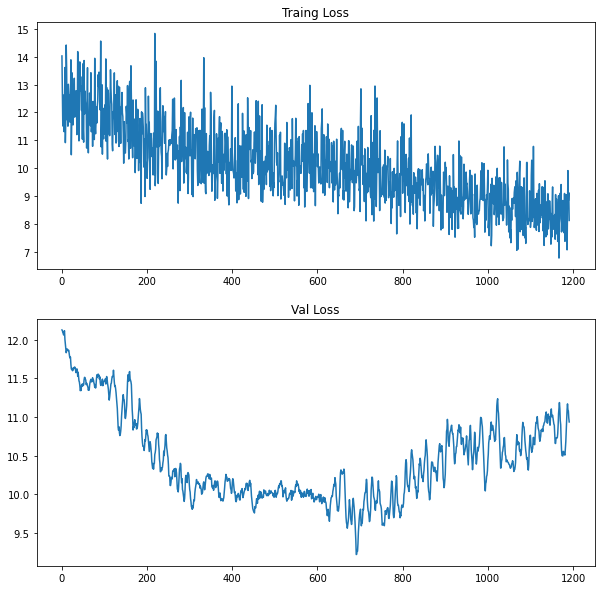

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.plot(train_losses[400:])
plt.title('Traing Loss')

plt.subplot(212)
plt.plot(val_losses[400:])
plt.title('Val Loss')

# Testing
The predictions of your model on testing set will be stored at `pred.csv`.

In [22]:
def save_pred(preds, file):
    ''' Save predictions to specified file '''
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])

model = My_Model(input_dim=x_train.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds,true = predict(train_loader, model, device) 
save_pred(preds, 'pred.csv')         

100%|██████████| 2/2 [00:00<00:00, 347.34it/s]


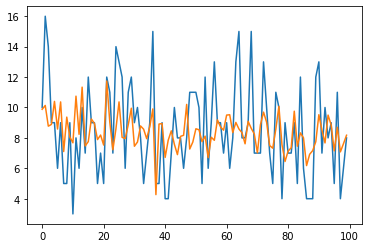

In [29]:
import matplotlib.pyplot as plt

# predict = pd.read_csv('/content/pred.csv')
# preds = list(predict.iloc[:,-1])
# true = pd.read_csv('/content/train_unit3.csv')
# y_true = list(true.iloc[:,-1])


plt.plot(true[:100])
plt.plot(preds[:100])



plt.show()

# Reference
This notebook uses code written by Heng-Jui Chang @ NTUEE (https://github.com/ga642381/ML2021-Spring/blob/main/HW01/HW01.ipynb)